In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Cleaning

Note: before this step, we've verified that the full dataset is balanced. Because the full dataset is too large to effectively work with, we randomly sampled 1% of the full dataset to perform EDA. We are also considering whether to use this sampled dataset for model training.

In [2]:
malware_df = pd.read_csv("../data/dev_small.csv")
malware_df

Unnamed: 0                 MachineIdentifier   ProductName  \
0         3778538  6c6f494003998c9383c76b2518152640  win8defender   
1         6226655  b2b8432b649bd9f208d6a4c5cbf9e951  win8defender   
2          493959  0e336045e09ca390c67b54af6c0a35a9  win8defender   
3         7450186  d5bec8d8f78c95afc0ed74c6b2ae83fa  win8defender   
4         7625118  dac8c41a0d8d506561c110ff6c7256e2  win8defender   
...           ...                               ...           ...   
89210     3261662  5d94137bc804b93923ce14981c4c9698  win8defender   
89211     8545024  f5310851036f116efd7a2ab61b5625d4  win8defender   
89212     4234385  798290f94237de1d23603fc40e2bdc02  win8defender   
89213     1870674  35b017e7cd9c839fbb2ea57d525e6fd0  win8defender   
89214     4330828  7c4b6bd7cbd01e2ff98dc21b85b3f2da  win8defender   

      EngineVersion       AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
0       1.1.15200.1  4.18.1807.18075   1.275.981.0       0               7.0   
1       1.1.15100.1  4.10.14393.1794  1.273.1652.0       0               7.0   
2       1.1.15200.1  4.18.1807.18075   1.275.644.0       0               7.0   
3       1.1.15100.1  4.18.1807.18075  1.273.1552.0       0               7.0   
4       1.1.15200.1  4.18.1807.18075   1.275.948.0       0               7.0   
...             ...              ...           ...     ...               ...   
89210   1.1.15100.1       4.10.209.0   1.273.781.0       0               7.0   
89211   1.1.15200.1   4.13.17134.228   1.275.821.0       0               0.0   
89212   1.1.15100.1  4.18.1807.18075   1.273.591.0       0               7.0   
89213   1.1.15200.1  4.18.1807.18075  1.275.1686.0       0               7.0   
89214   1.1.15000.1     4.13.17134.1  1.269.1263.0       0               7.0   

       IsSxsPassiveMode  DefaultBrowsersIdentifier  ...  \
0                     0                        NaN  ...   
1                     0                        NaN  ...   
2                     0                        NaN  ...   
3                     0                        NaN  ...   
4                     0                        NaN  ...   
...                 ...                        ...  ...   
89210                 0                        NaN  ...   
89211                 1                        NaN  ...   
89212                 0                        NaN  ...   
89213                 0                        NaN  ...   
89214                 0                        NaN  ...   

       Census_FirmwareVersionIdentifier  Census_IsSecureBootEnabled  \
0                                7221.0                           0   
1                               59187.0                           0   
2                               20388.0                           0   
3                               42264.0                           0   
4                               26988.0                           0   
...                                 ...                         ...   
89210                           17556.0                           1   
89211                            7936.0                           0   
89212                           26312.0                           1   
89213                           33145.0                           1   
89214                           63458.0                           0   

       Census_IsWIMBootEnabled  Census_IsVirtualDevice  Census_IsTouchEnabled  \
0                          0.0                     0.0                      0   
1                          NaN                     0.0                      0   
2                          NaN                     0.0                      0   
3                          NaN                     0.0                      0   
4                          NaN                     0.0                      0   
...                        ...                     ...                    ...   
89210                      NaN                     0.0                      1   
89211  

In [3]:
print("# of machines w/ malware: " + str(malware_df['HasDetections'].sum()))
print("# of machines w/o malware: " + str(len(malware_df['HasDetections']) - malware_df['HasDetections'].sum()))

# of machines w/ malware: 44674
# of machines w/o malware: 44541


In [4]:
print(malware_df.dropna().shape)
print(malware_df.shape)
with pd.option_context('display.max_rows', None):
    display(malware_df.isna().sum())

(0, 84)
(89215, 84)


Unnamed: 0                                               0
MachineIdentifier                                        0
ProductName                                              0
EngineVersion                                            0
AppVersion                                               0
AvSigVersion                                             0
IsBeta                                                   0
RtpStateBitfield                                       330
IsSxsPassiveMode                                         0
DefaultBrowsersIdentifier                            84951
AVProductStatesIdentifier                              379
AVProductsInstalled                                    379
AVProductsEnabled                                      379
HasTpm                                                   0
CountryIdentifier                                        0
CityIdentifier                                        3262
OrganizationIdentifier                               276

Every row has at least one nan, so we can't just drop rows with missing values. However, there are certain columns
that have a lot more missing values than others, so we can just drop those columns. It doesn't make sense to try to
impute values for those columns as so many values are missing.

In [5]:
nan_counts = malware_df.isna().sum()

# We consider dropping columns that has more than 1000 nan values. This cutoff value is
# empirically chosen based on the above statistics

features_to_drop = nan_counts[nan_counts >= 1000].index.tolist()
print(features_to_drop)
print("Number of features to be dropped: ", len(features_to_drop))

['DefaultBrowsersIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'PuaMode', 'SMode', 'SmartScreen', 'Census_ProcessorClass', 'Census_InternalBatteryType', 'Census_InternalBatteryNumberOfCharges', 'Census_IsFlightingInternal', 'Census_IsFlightsDisabled', 'Census_ThresholdOptIn', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Census_IsWIMBootEnabled', 'Wdft_IsGamer', 'Wdft_RegionIdentifier']
Number of features to be dropped:  17


In [6]:
malware_df = malware_df.drop(columns=features_to_drop)
malware_df

Unnamed: 0                 MachineIdentifier   ProductName  \
0         3778538  6c6f494003998c9383c76b2518152640  win8defender   
1         6226655  b2b8432b649bd9f208d6a4c5cbf9e951  win8defender   
2          493959  0e336045e09ca390c67b54af6c0a35a9  win8defender   
3         7450186  d5bec8d8f78c95afc0ed74c6b2ae83fa  win8defender   
4         7625118  dac8c41a0d8d506561c110ff6c7256e2  win8defender   
...           ...                               ...           ...   
89210     3261662  5d94137bc804b93923ce14981c4c9698  win8defender   
89211     8545024  f5310851036f116efd7a2ab61b5625d4  win8defender   
89212     4234385  798290f94237de1d23603fc40e2bdc02  win8defender   
89213     1870674  35b017e7cd9c839fbb2ea57d525e6fd0  win8defender   
89214     4330828  7c4b6bd7cbd01e2ff98dc21b85b3f2da  win8defender   

      EngineVersion       AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
0       1.1.15200.1  4.18.1807.18075   1.275.981.0       0               7.0   
1       1.1.15100.1  4.10.14393.1794  1.273.1652.0       0               7.0   
2       1.1.15200.1  4.18.1807.18075   1.275.644.0       0               7.0   
3       1.1.15100.1  4.18.1807.18075  1.273.1552.0       0               7.0   
4       1.1.15200.1  4.18.1807.18075   1.275.948.0       0               7.0   
...             ...              ...           ...     ...               ...   
89210   1.1.15100.1       4.10.209.0   1.273.781.0       0               7.0   
89211   1.1.15200.1   4.13.17134.228   1.275.821.0       0               0.0   
89212   1.1.15100.1  4.18.1807.18075   1.273.591.0       0               7.0   
89213   1.1.15200.1  4.18.1807.18075  1.275.1686.0       0               7.0   
89214   1.1.15000.1     4.13.17134.1  1.269.1263.0       0               7.0   

       IsSxsPassiveMode  AVProductStatesIdentifier  ...  \
0                     0                    53447.0  ...   
1                     0                        NaN  ...   
2                     0                    53447.0  ...   
3                     0                    53447.0  ...   
4                     0                    53447.0  ...   
...                 ...                        ...  ...   
89210                 0                    49545.0  ...   
89211                 1                    57073.0  ...   
89212                 0                    53447.0  ...   
89213                 0                    53447.0  ...   
89214                 0                    11280.0  ...   

       Census_IsPortableOperatingSystem  Census_GenuineStateName  \
0                                     0               IS_GENUINE   
1                                     0               IS_GENUINE   
2                                     0               IS_GENUINE   
3                                     0          INVALID_LICENSE   
4                                     0               IS_GENUINE   
...                                 ...                      ...   
89210                                 0               IS_GENUINE   
89211                                 0               IS_GENUINE   
89212                                 0               IS_GENUINE   
89213                                 0               IS_GENUINE   
89214                                 0               IS_GENUINE   

       Census_ActivationChannel  Census_FlightRing  \
0                        Retail             Retail   
1                        Retail             Retail   
2                    OEM:NONSLP             Retail   
3                        Retail             Retail   
4                        Retail             Retail   
...                         ...                ...   
89210                    Retail             Retail   
89211                    OEM:DM             Retail   
89212                    Retail             Retail   
89213                    OEM:DM             Retail   
89214                    Retail             Retail   

       Census_IsSecureBootEnabled  Census_

In [7]:
print("Number of rows that have null values: ", malware_df.shape[0] - malware_df.dropna().shape[0])

Number of rows that have null values:  5201


We decide to then drop all rows that has null values, because their total number is insignificant.

In [8]:
malware_df = malware_df.dropna()
malware_df

Unnamed: 0                 MachineIdentifier   ProductName  \
0         3778538  6c6f494003998c9383c76b2518152640  win8defender   
2          493959  0e336045e09ca390c67b54af6c0a35a9  win8defender   
3         7450186  d5bec8d8f78c95afc0ed74c6b2ae83fa  win8defender   
4         7625118  dac8c41a0d8d506561c110ff6c7256e2  win8defender   
5         7218352  cf1abe3dcfa1fb6612215df83c3ae5d7  win8defender   
...           ...                               ...           ...   
89210     3261662  5d94137bc804b93923ce14981c4c9698  win8defender   
89211     8545024  f5310851036f116efd7a2ab61b5625d4  win8defender   
89212     4234385  798290f94237de1d23603fc40e2bdc02  win8defender   
89213     1870674  35b017e7cd9c839fbb2ea57d525e6fd0  win8defender   
89214     4330828  7c4b6bd7cbd01e2ff98dc21b85b3f2da  win8defender   

      EngineVersion       AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
0       1.1.15200.1  4.18.1807.18075   1.275.981.0       0               7.0   
2       1.1.15200.1  4.18.1807.18075   1.275.644.0       0               7.0   
3       1.1.15100.1  4.18.1807.18075  1.273.1552.0       0               7.0   
4       1.1.15200.1  4.18.1807.18075   1.275.948.0       0               7.0   
5       1.1.15100.1  4.18.1807.18075  1.273.1504.0       0               7.0   
...             ...              ...           ...     ...               ...   
89210   1.1.15100.1       4.10.209.0   1.273.781.0       0               7.0   
89211   1.1.15200.1   4.13.17134.228   1.275.821.0       0               0.0   
89212   1.1.15100.1  4.18.1807.18075   1.273.591.0       0               7.0   
89213   1.1.15200.1  4.18.1807.18075  1.275.1686.0       0               7.0   
89214   1.1.15000.1     4.13.17134.1  1.269.1263.0       0               7.0   

       IsSxsPassiveMode  AVProductStatesIdentifier  ...  \
0                     0                    53447.0  ...   
2                     0                    53447.0  ...   
3                     0                    53447.0  ...   
4                     0                    53447.0  ...   
5                     0                    53447.0  ...   
...                 ...                        ...  ...   
89210                 0                    49545.0  ...   
89211                 1                    57073.0  ...   
89212                 0                    53447.0  ...   
89213                 0                    53447.0  ...   
89214                 0                    11280.0  ...   

       Census_IsPortableOperatingSystem  Census_GenuineStateName  \
0                                     0               IS_GENUINE   
2                                     0               IS_GENUINE   
3                                     0          INVALID_LICENSE   
4                                     0               IS_GENUINE   
5                                     0               IS_GENUINE   
...                                 ...                      ...   
89210                                 0               IS_GENUINE   
89211                                 0               IS_GENUINE   
89212                                 0               IS_GENUINE   
89213                                 0               IS_GENUINE   
89214                                 0               IS_GENUINE   

       Census_ActivationChannel  Census_FlightRing  \
0                        Retail             Retail   
2                    OEM:NONSLP             Retail   
3                        Retail             Retail   
4                        Retail             Retail   
5                        OEM:DM             Retail   
...                         ...                ...   
89210                    Retail             Retail   
89211                    OEM:DM             Retail   
89212                    Retail             Retail   
89213                    OEM:DM             Retail   
89214                    Retail             Retail   

       Census_IsSecureBootEnabled  Census_

In [9]:
malware_df.drop("Unnamed: 0", axis=1, inplace=True)

# Preliminary Investigation on the remaining features

In [10]:
print(malware_df.columns)

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'HasTpm', 'CountryIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer',
       'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'IeVerIdentifier',
       'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor',
       'Census_DeviceFamily', 'Census_OEMNameIdentifier',
       'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_Interna

By analyzing the above features, we separated them into the following 4 categories:

**Identifiers**: AVProductStatesIdentifier, CountryIdentifier, GeoNameIdentifier, Census_OEMNameIdentifier, Census_ProcessorModelIdentifier, Census_ProcessorManufacturerIdentifier, Census_ProcessorModelIdentifier, Census_OSInstallLanguageIdentifier

**Categorical Variables**: ProductName, EngineVersion, AppVersion, AvSigVersion, IsBeta, RtpStateBitfield, IsSxsPassiveMode, HasTpm, Platform, Processor, OsVer, OsBuild, OsSuite, OsPlatformSubRelease, OsBuildLab, SkuEdition, IsProtected, IeVerIdentifier, Firewall, UacLuaenable, Census_MDC2FormFactor, Census_PrimaryDiskTypeName, Census_HasOpticalDiskDrive, Census_ChassisTypeName, Census_PowerPlatformRoleName, Census_OSVersion, Census_OSArchitecture, Census_OSBranch, Census_OSBuildNumber, Census_OSBuildRevision, Census_OSEdition, Census_OSSkuName, Census_OSInstallTypeName, Census_OSWUAutoUpdateOptionsName, Census_IsPortableOperatingSystem, Census_GenuineStateName, Census_ActivationChannel, Census_FlightRing, Census_IsSecureBootEnabled, Census_IsVirtualDevice, Census_IsTouchEnabled, Census_IsPenCapable, Census_IsAlwaysOnAlwaysConnectedCapable

**Numerical Variables**: AVProductsInstalled, AVProductsEnabled, Census_ProcessorCoreCount, Census_PrimaryDiskTotalCapacity, Census_SystemVolumeTotalCapacity, Census_TotalPhysicalRAM,

**Target Variable**: HasDetections

**To remove**: MachineIdentifier, LocaleEnglishNameIdentifier, AutoSampleOptIn, Census_DeviceFamily, Census_InternalPrimaryDiagonalDisplaySizeInInches, Census_InternalPrimaryDisplayResolutionHorizontal, Census_InternalPrimaryDisplayResolutionVertical, Census_OSUILocaleIdentifier

**Highly Important**: AVProductsInstalled, AVProductsEnabled, IsProtected, Firewall, UacLuaenable, Census_OSVersion, Census_OSArchitecture, Census_IsSecureBootEnabled, Census_IsVirtualDevice, Census_IsAlwaysOnAlwaysConnectedCapable

As you can see, most of the features in this dataset is **categorical**. This may imply that tree-based models are more suitable to be used in the project.

The **Highly Important** features are selected based on the background information on the features. These features can all potentially directly impact the possibility of a machine being infected by malewares. Therefore, we would like to focus our analysis on these attributes.

In [11]:
# Remove all unnecessary features

to_remove = ["MachineIdentifier", "LocaleEnglishNameIdentifier", "AutoSampleOptIn", "Census_DeviceFamily", "Census_InternalPrimaryDiagonalDisplaySizeInInches", "Census_InternalPrimaryDisplayResolutionHorizontal", "Census_InternalPrimaryDisplayResolutionVertical", "Census_OSUILocaleIdentifier"]

malware_df.drop(columns=to_remove, inplace=True)
malware_df

ProductName EngineVersion       AppVersion  AvSigVersion  IsBeta  \
0      win8defender   1.1.15200.1  4.18.1807.18075   1.275.981.0       0   
2      win8defender   1.1.15200.1  4.18.1807.18075   1.275.644.0       0   
3      win8defender   1.1.15100.1  4.18.1807.18075  1.273.1552.0       0   
4      win8defender   1.1.15200.1  4.18.1807.18075   1.275.948.0       0   
5      win8defender   1.1.15100.1  4.18.1807.18075  1.273.1504.0       0   
...             ...           ...              ...           ...     ...   
89210  win8defender   1.1.15100.1       4.10.209.0   1.273.781.0       0   
89211  win8defender   1.1.15200.1   4.13.17134.228   1.275.821.0       0   
89212  win8defender   1.1.15100.1  4.18.1807.18075   1.273.591.0       0   
89213  win8defender   1.1.15200.1  4.18.1807.18075  1.275.1686.0       0   
89214  win8defender   1.1.15000.1     4.13.17134.1  1.269.1263.0       0   

       RtpStateBitfield  IsSxsPassiveMode  AVProductStatesIdentifier  \
0                   7.0                 0                    53447.0   
2                   7.0                 0                    53447.0   
3                   7.0                 0                    53447.0   
4                   7.0                 0                    53447.0   
5                   7.0                 0                    53447.0   
...                 ...               ...                        ...   
89210               7.0                 0                    49545.0   
89211               0.0                 1                    57073.0   
89212               7.0                 0                    53447.0   
89213               7.0                 0                    53447.0   
89214               7.0                 0                    11280.0   

       AVProductsInstalled  AVProductsEnabled  ...  \
0                      1.0                1.0  ...   
2                      1.0                1.0  ...   
3                      1.0                1.0  ...   
4                      1.0                1.0  ...   
5                      1.0                1.0  ...   
...                    ...                ...  ...   
89210                  2.0                2.0  ...   
89211                  2.0                1.0  ...   
89212                  1.0                1.0  ...   
89213                  1.0                1.0  ...   
89214                  2.0                1.0  ...   

       Census_IsPortableOperatingSystem  Census_GenuineStateName  \
0                                     0               IS_GENUINE   
2                                     0               IS_GENUINE   
3                                     0          INVALID_LICENSE   
4                                     0               IS_GENUINE   
5                                     0               IS_GENUINE   
...                                 ...                      ...   
89210                                 0               IS_GENUINE   
89211                                 0               IS_GENUINE   
89212                                 0               IS_GENUINE   
89213                                 0               IS_GENUINE   
89214                                 0               IS_GENUINE   

       Census_ActivationChannel Census_FlightRing Census_IsSecureBootEnabled  \
0                        Retail            Retail                          0   
2                    OEM:NONSLP            Retail                          0   
3                        Retail            Retail                          0   
4                        Retail            Retail                          0   
5                        OEM:DM            Retail                          1   
...                         ...               ...                        ...   
89210                    Retail            Retail                          1   
89211                    OEM:DM            Retail                          0   
89212                    Retail            R

# Data Visualization

Things to explore:

1. The distribution of each of the remaining features, either categorical or numerical

2. Does the highly important features have any correlation with the target variable?

3. Are there any highly correlated features?

4. Some of the features are highly connected. For example: The Census_OSBuildNumber and Census_OSBuildRevision. Consider grouping such features and analyzing their impact on the target variables as a whole.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical Features
categorical_features = [
    'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta', 'RtpStateBitfield',
    'IsSxsPassiveMode', 'HasTpm', 'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite',
    'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'IsProtected', 'IeVerIdentifier',
    'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor', 'Census_PrimaryDiskTypeName',
    'Census_HasOpticalDiskDrive', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
    'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSBuildNumber',
    'Census_OSBuildRevision', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName',
    'Census_OSWUAutoUpdateOptionsName', 'Census_IsPortableOperatingSystem', 'Census_GenuineStateName',
    'Census_ActivationChannel', 'Census_FlightRing', 'Census_IsSecureBootEnabled',
    'Census_IsVirtualDevice', 'Census_IsTouchEnabled', 'Census_IsPenCapable',
    'Census_IsAlwaysOnAlwaysConnectedCapable'
]

# Numerical Features
numerical_features = [
    'AVProductsInstalled', 'AVProductsEnabled', 'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM'
]

# Target Variable
target_variable = 'HasDetections'






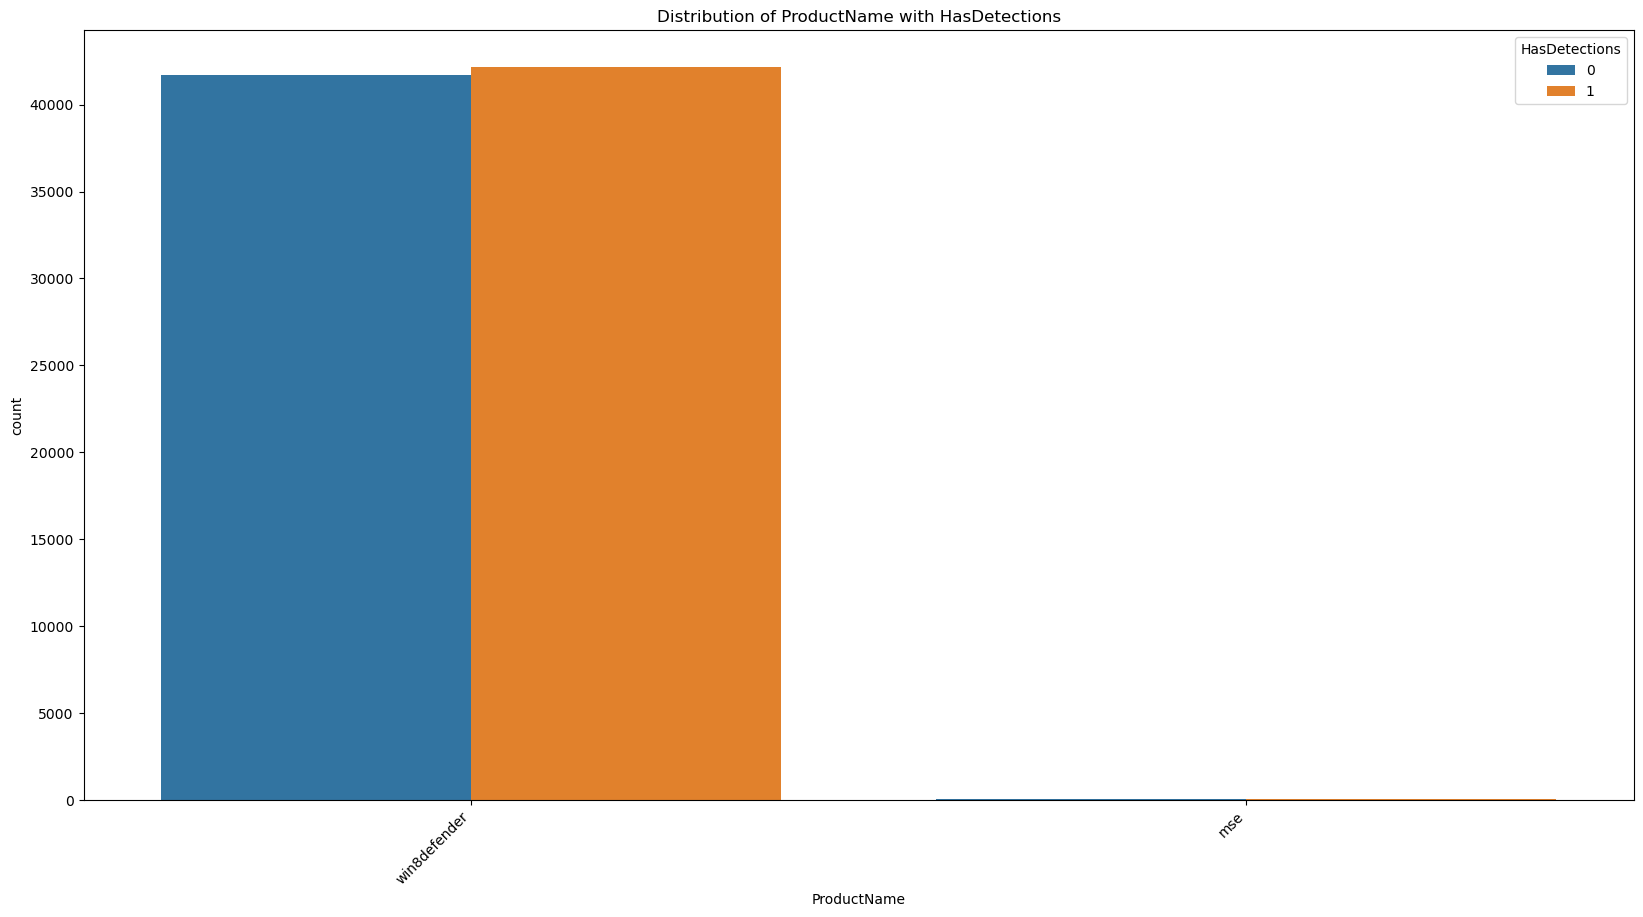

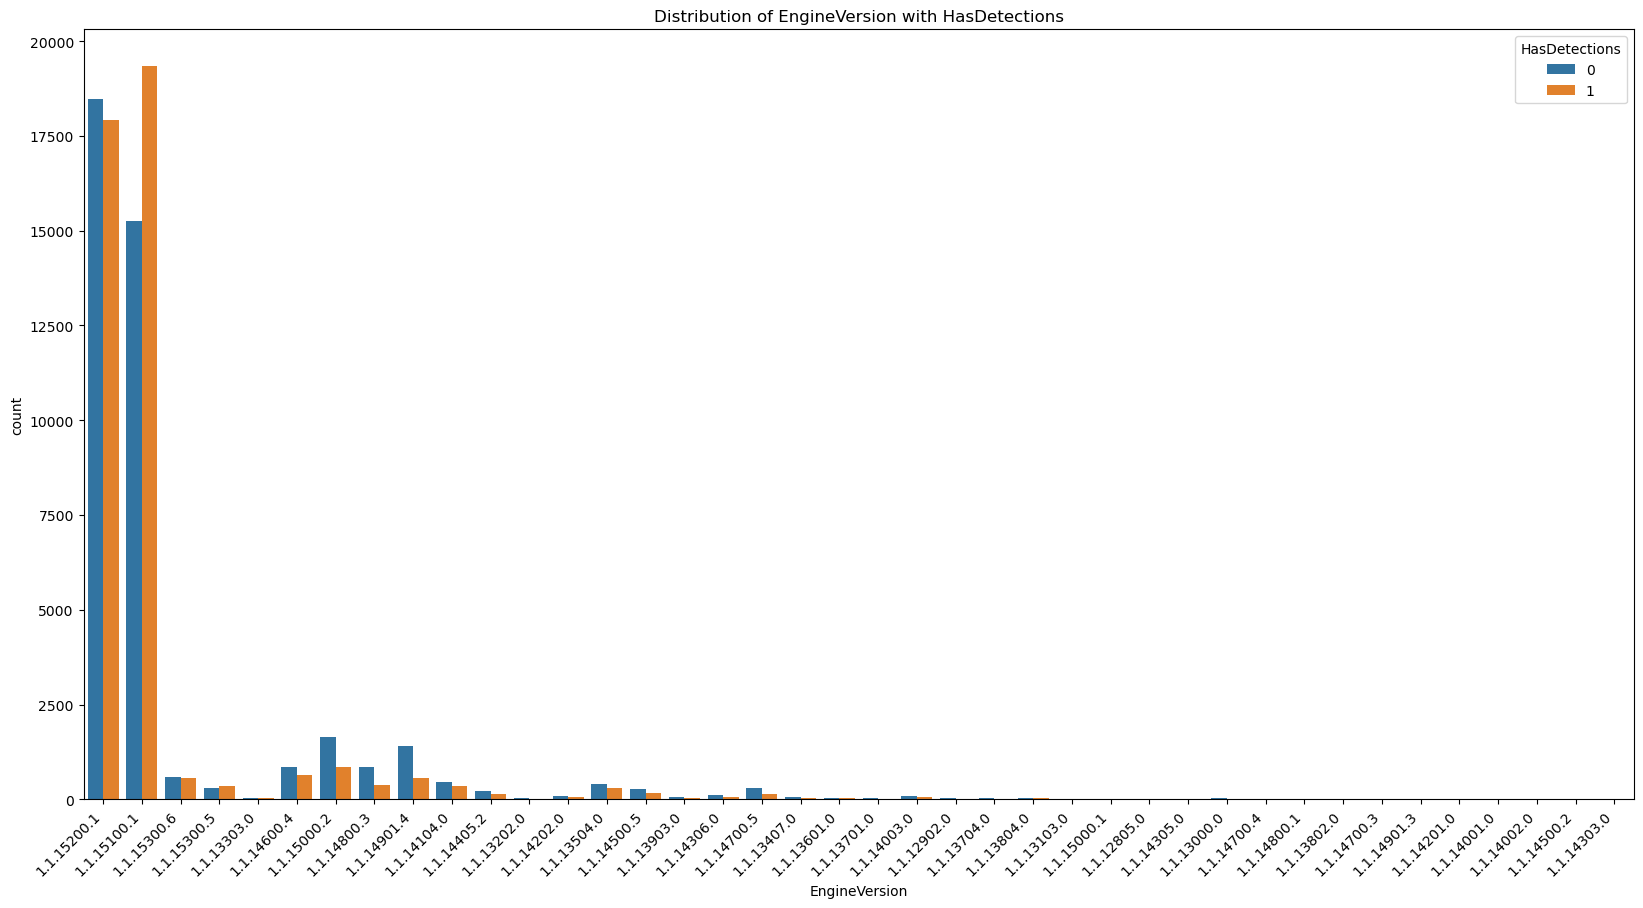

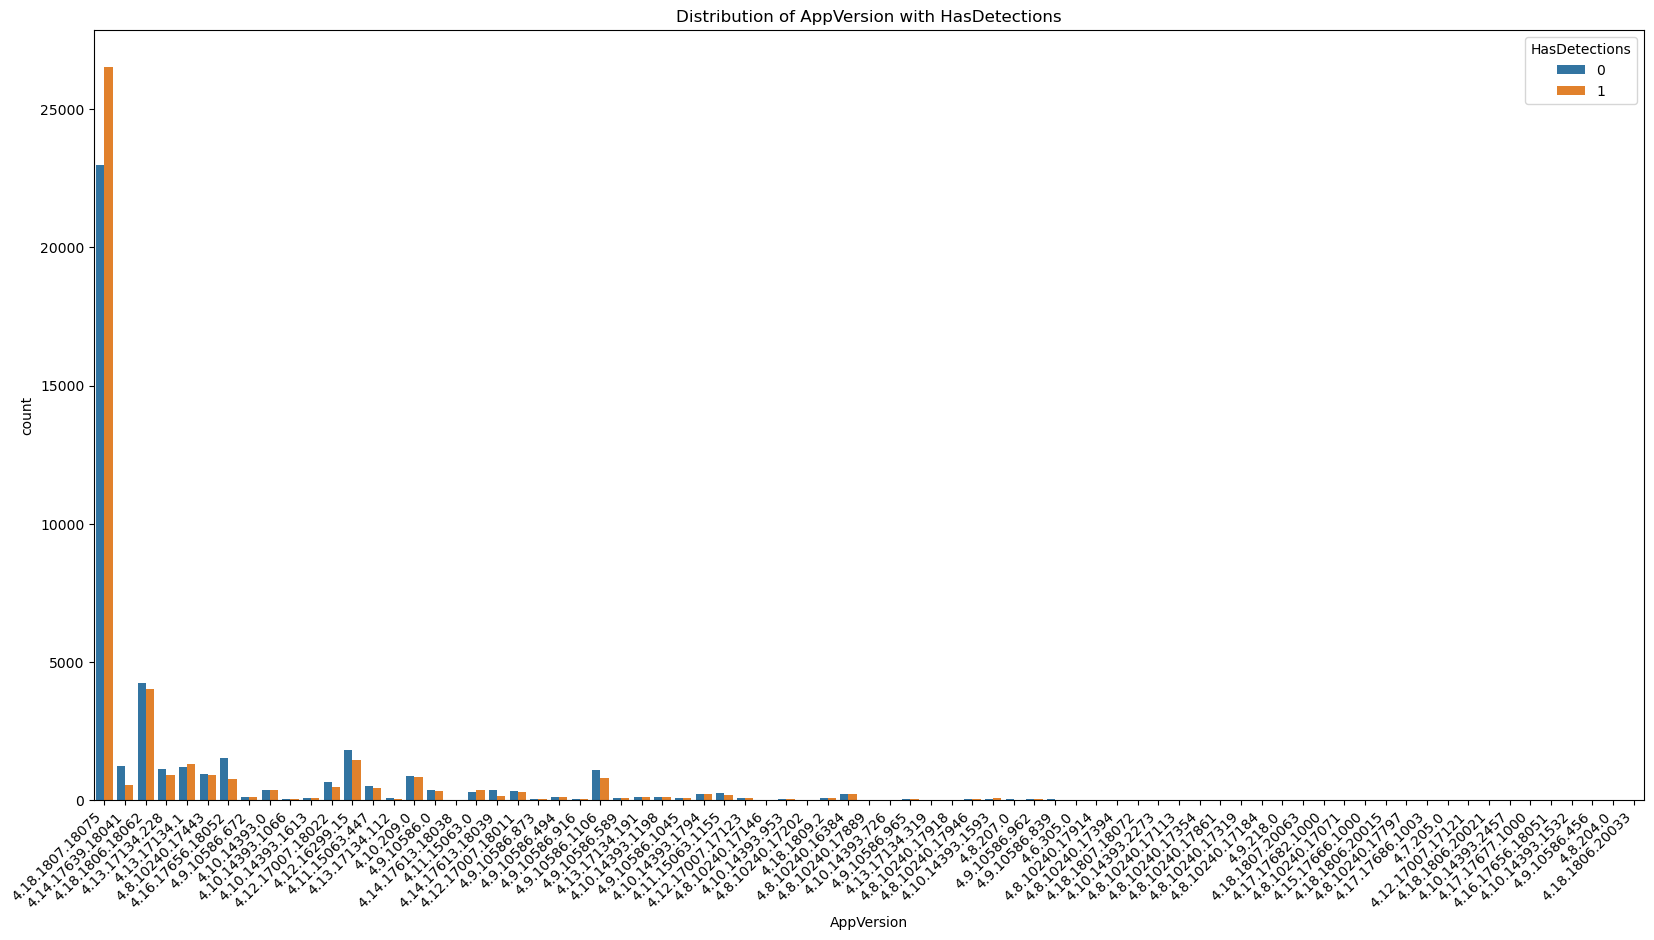

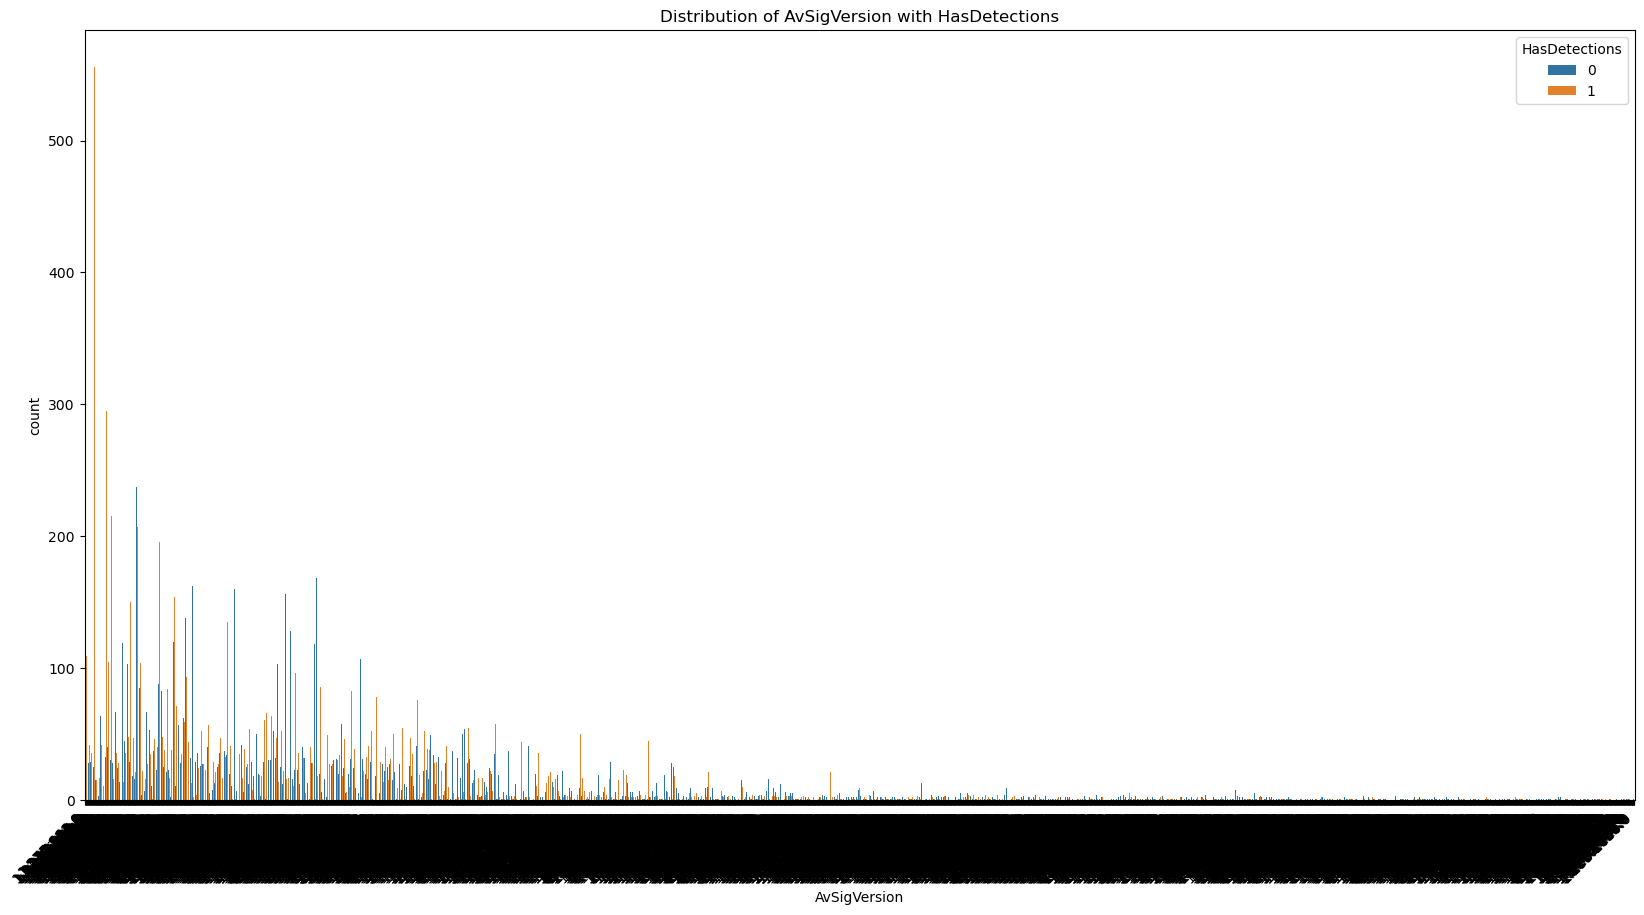

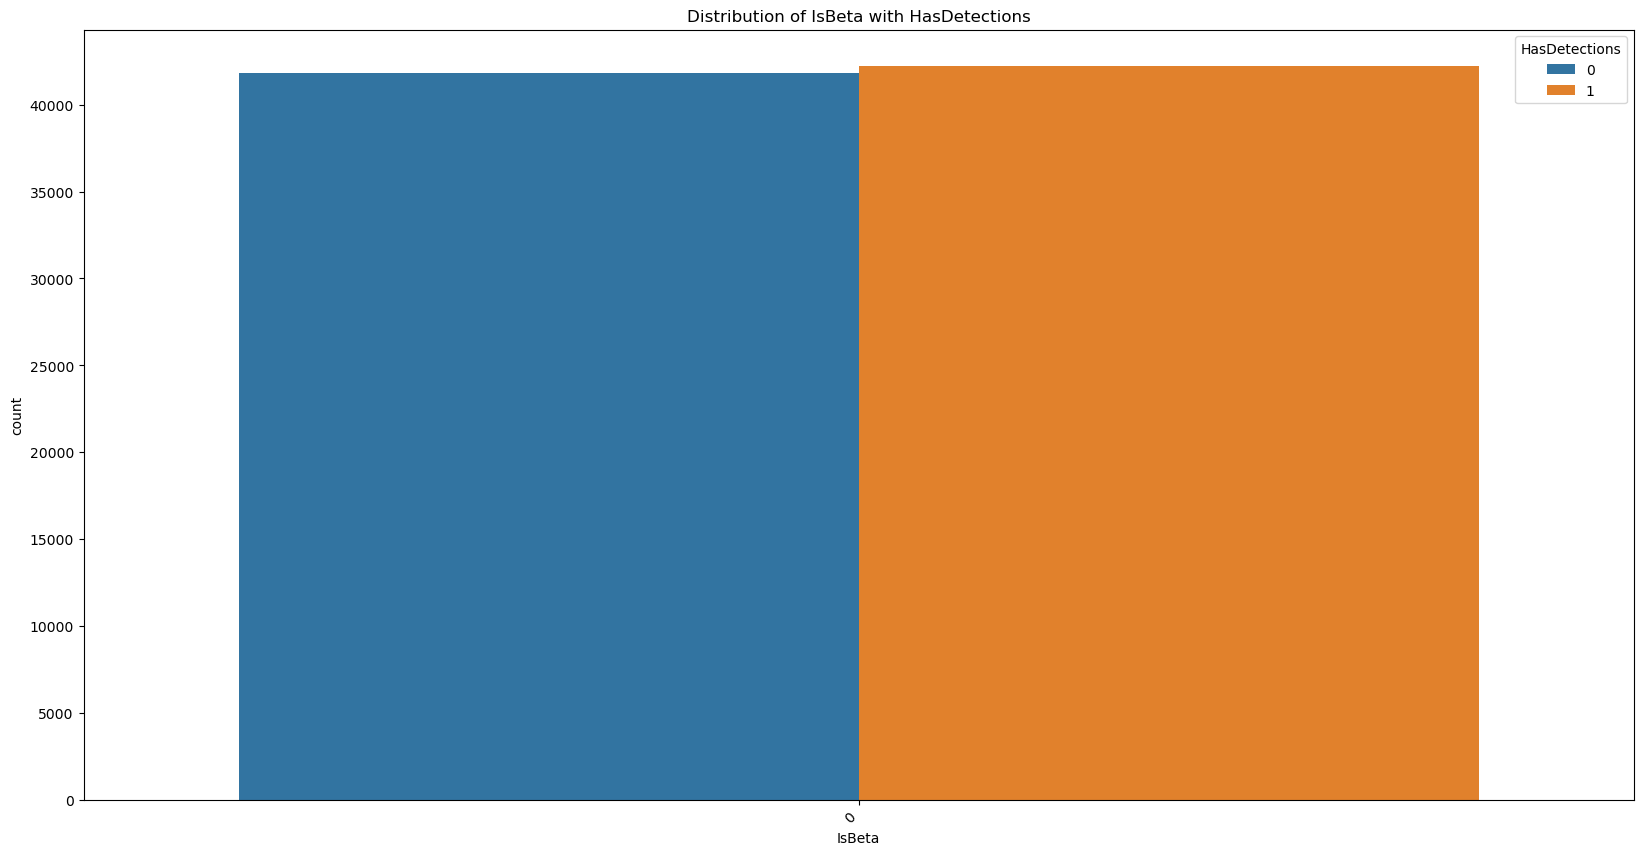

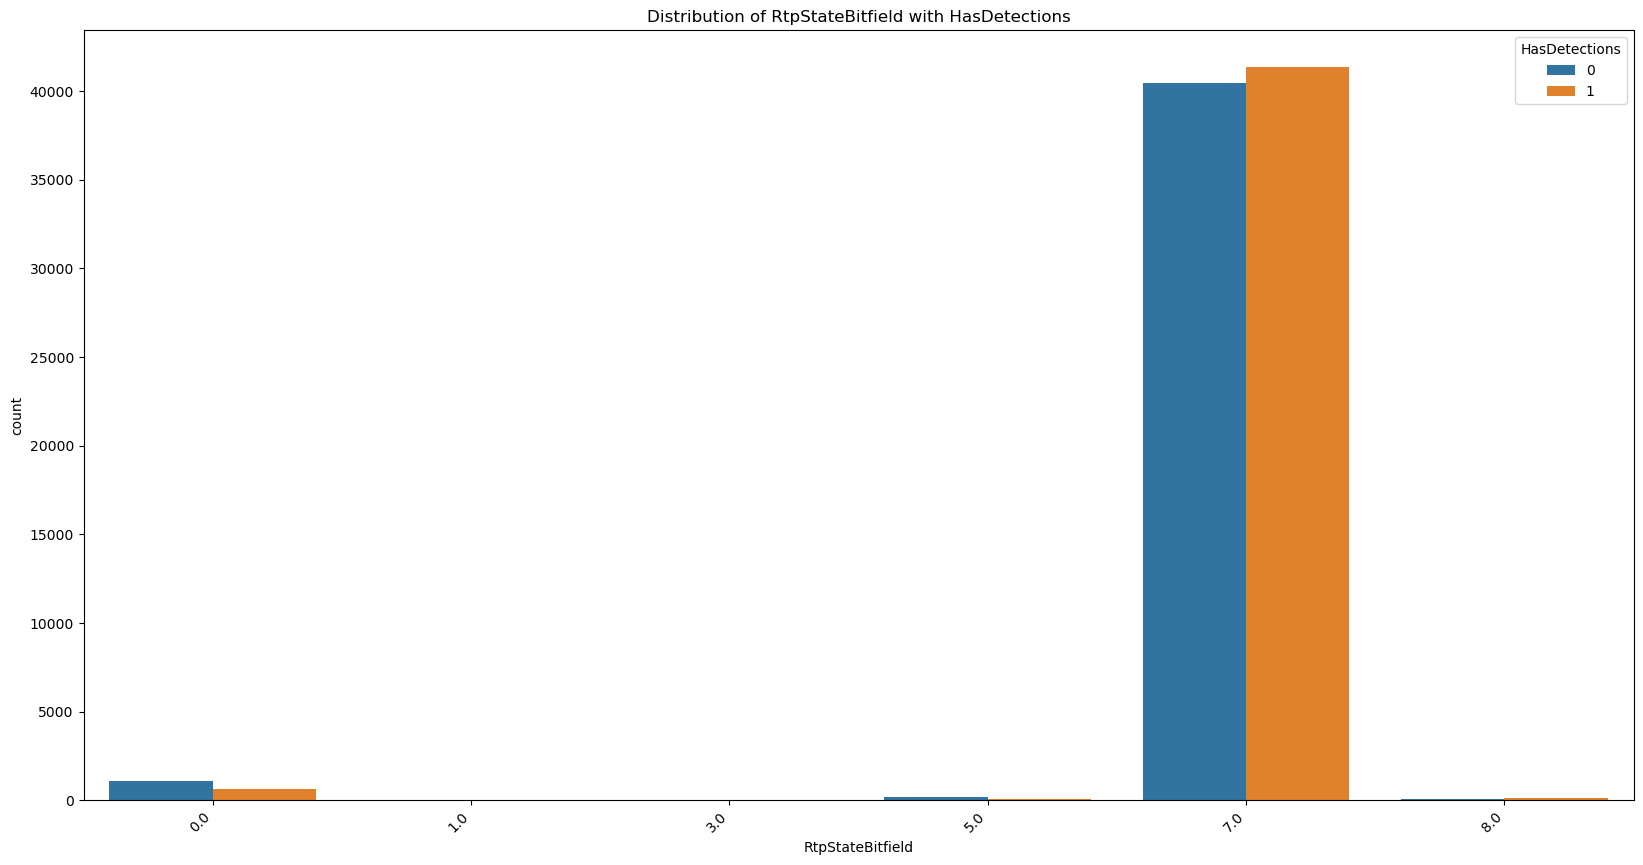

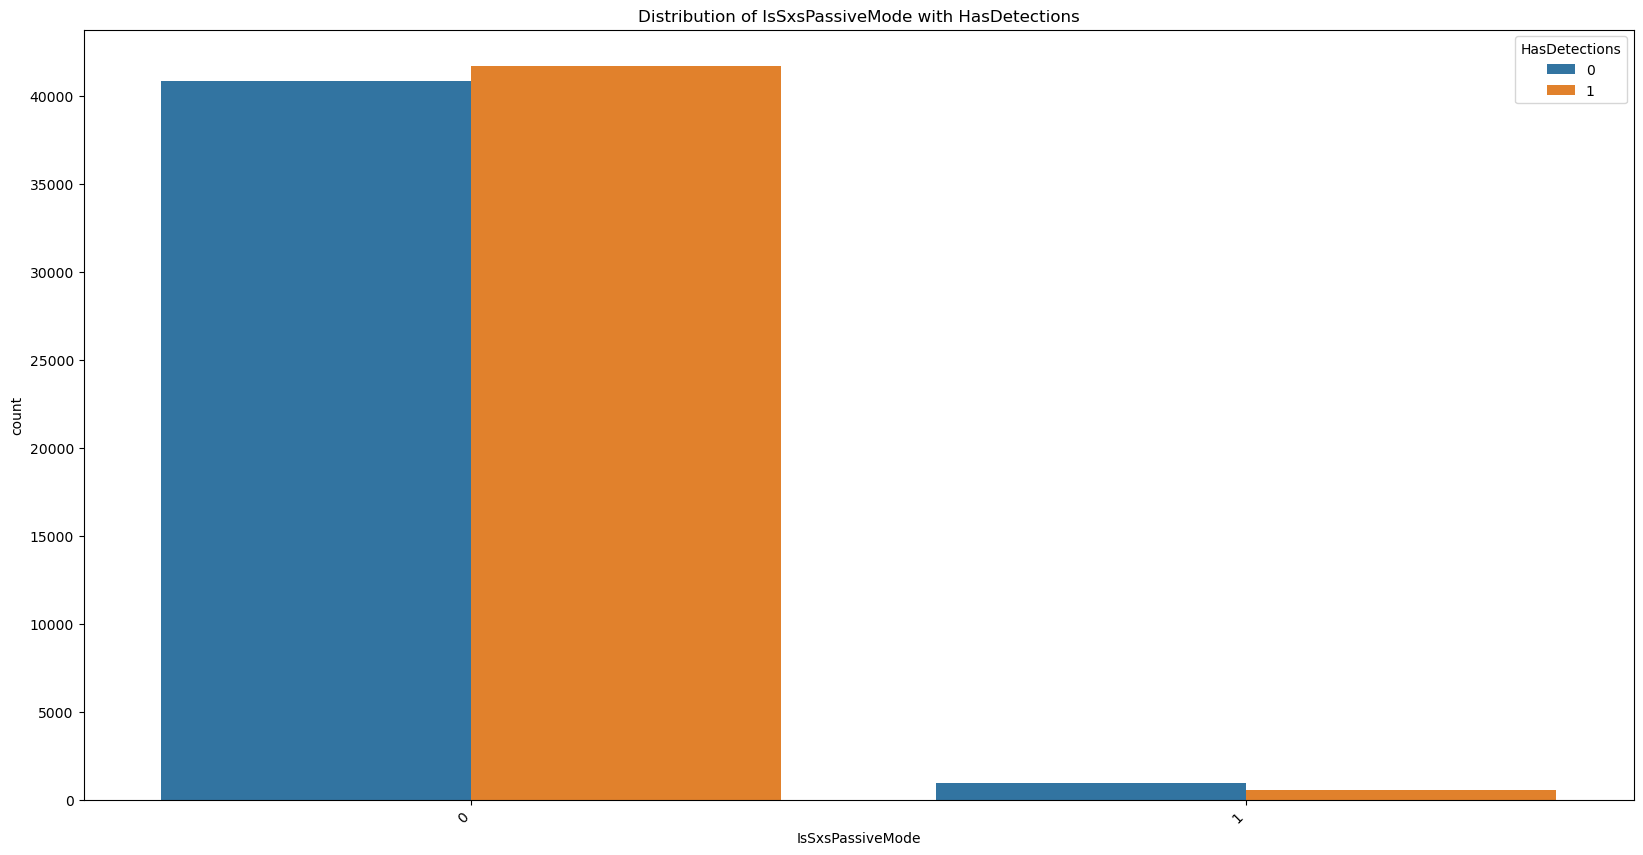

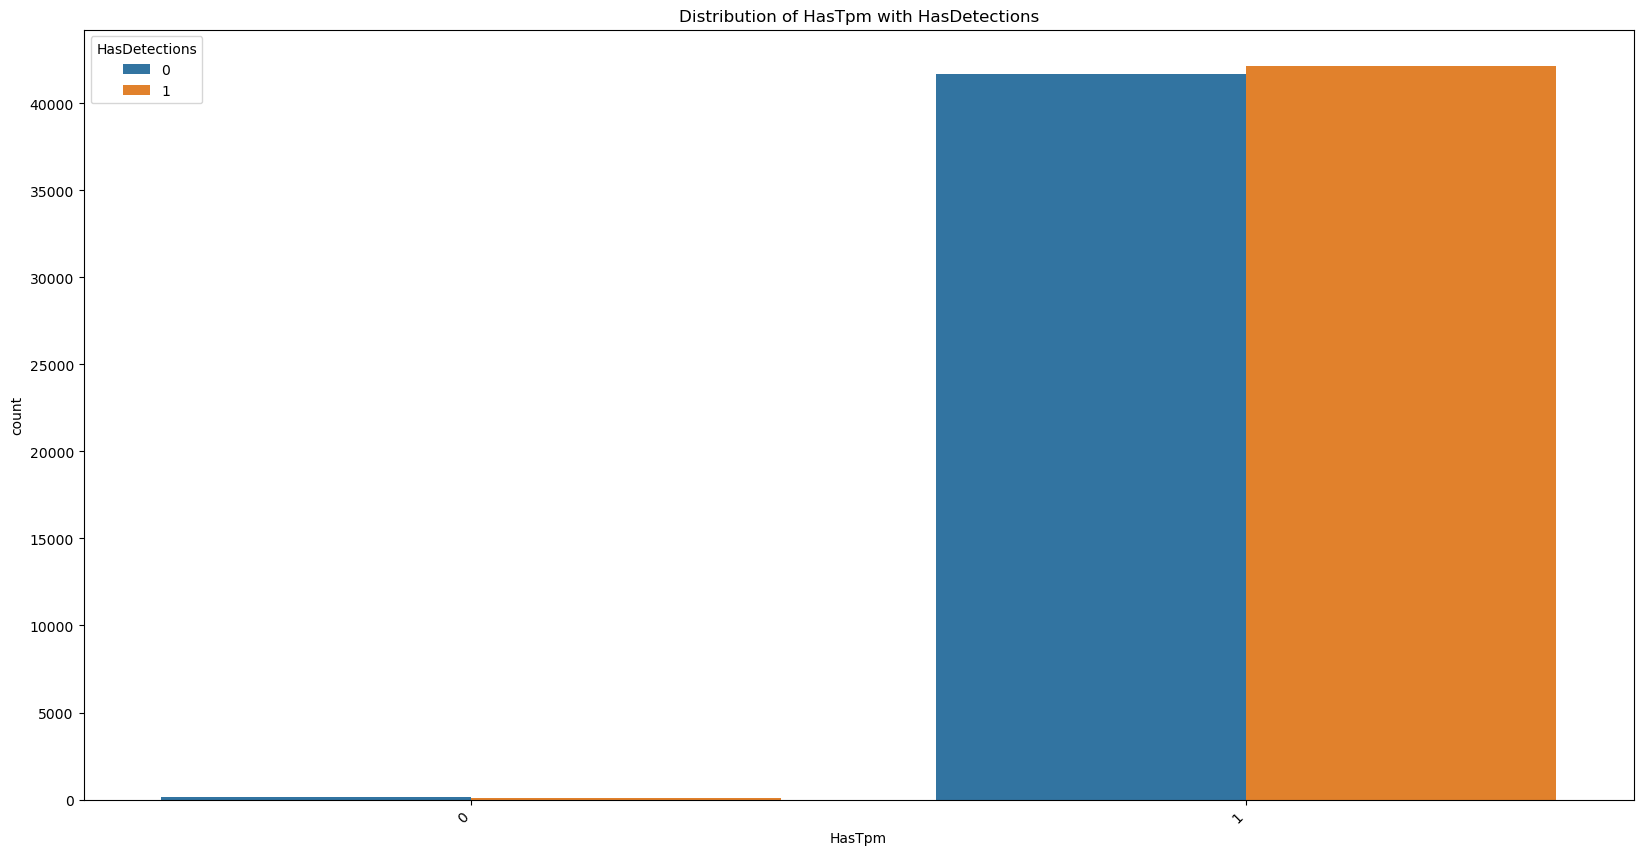

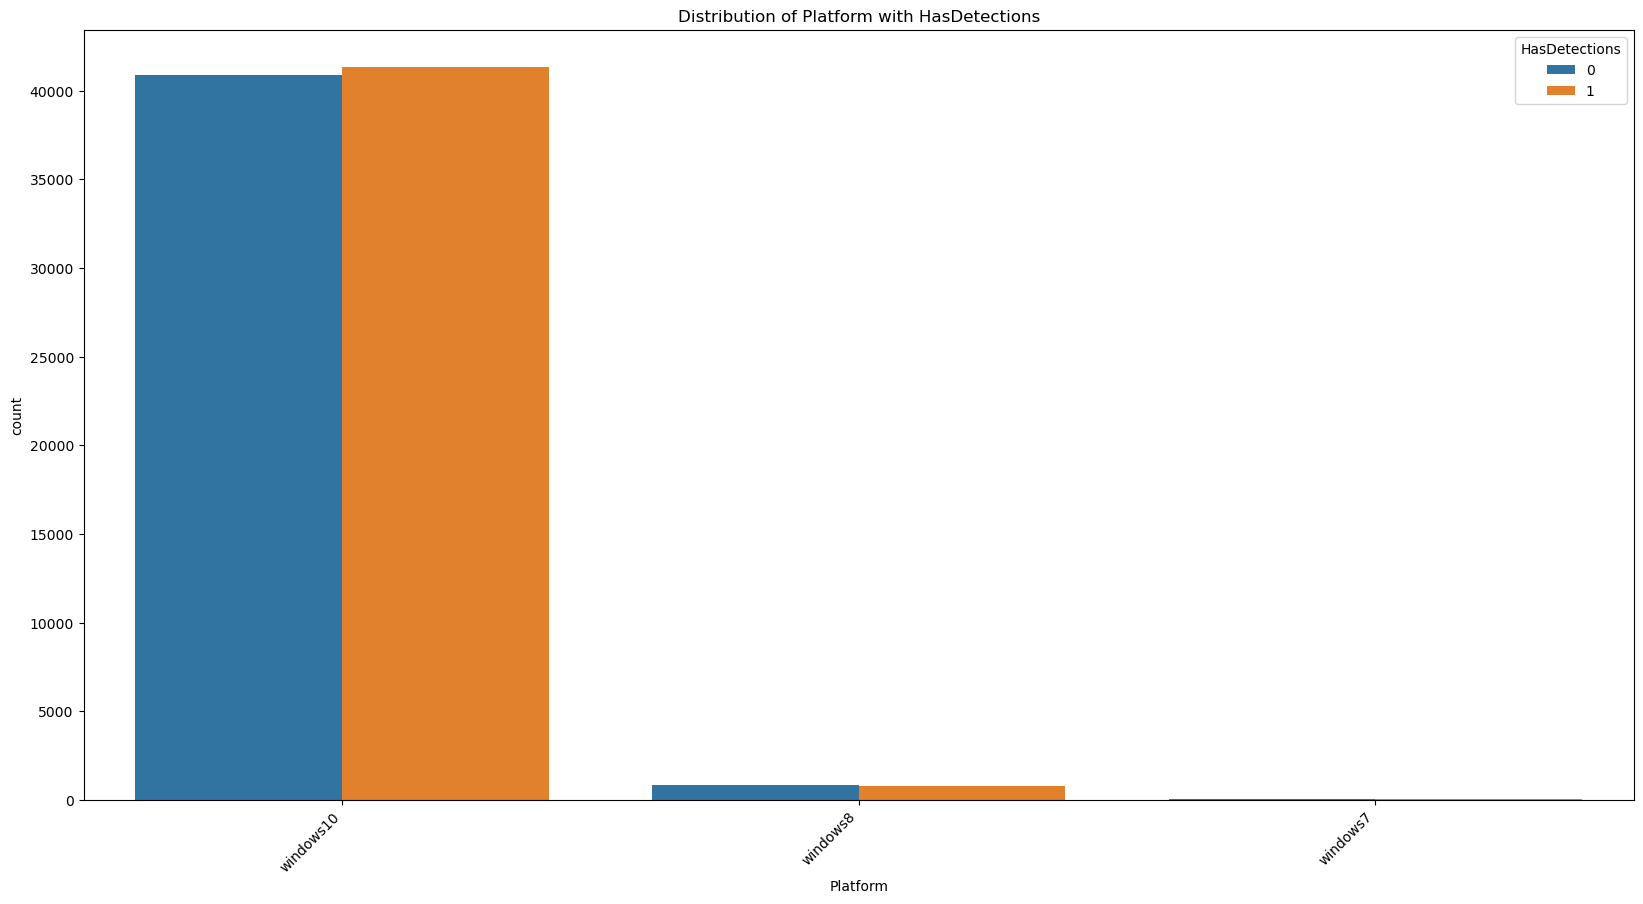

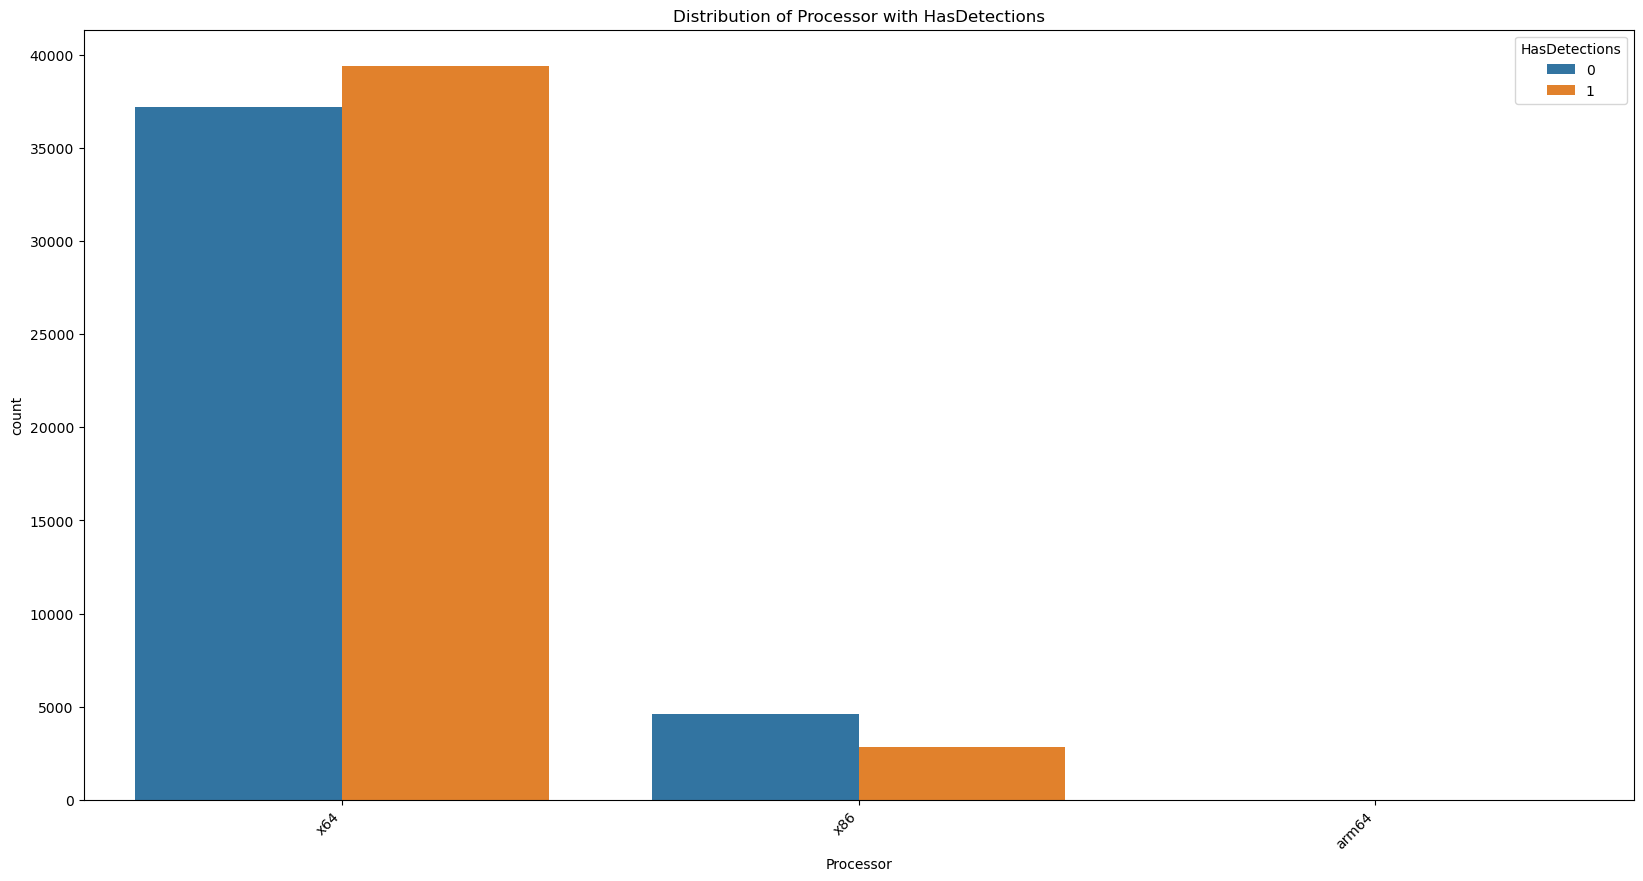

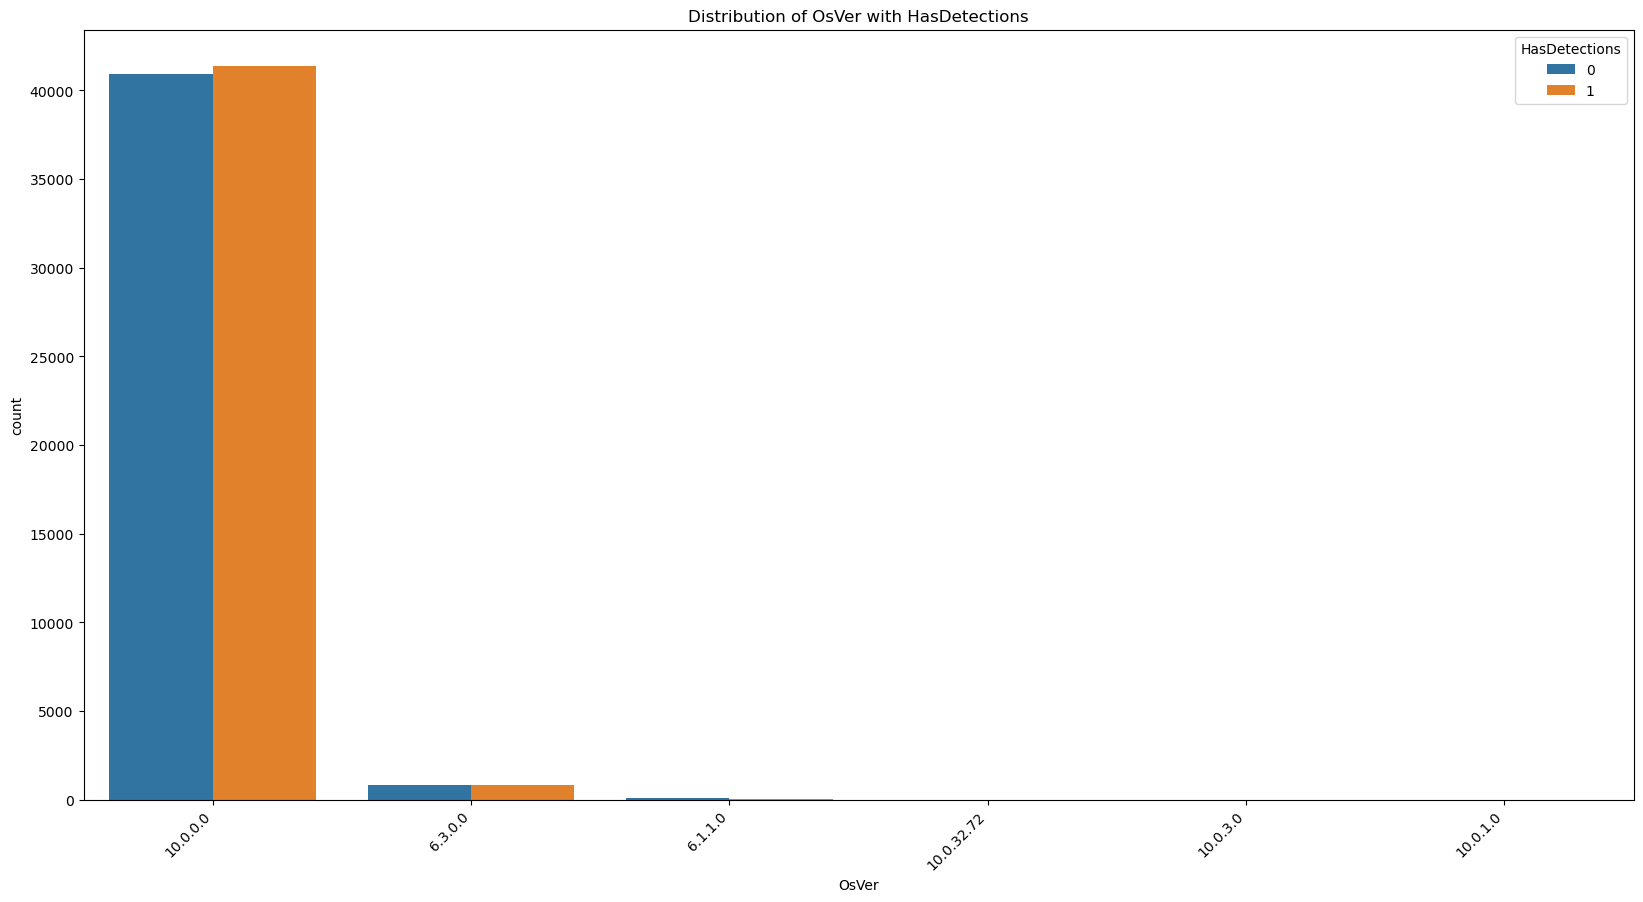

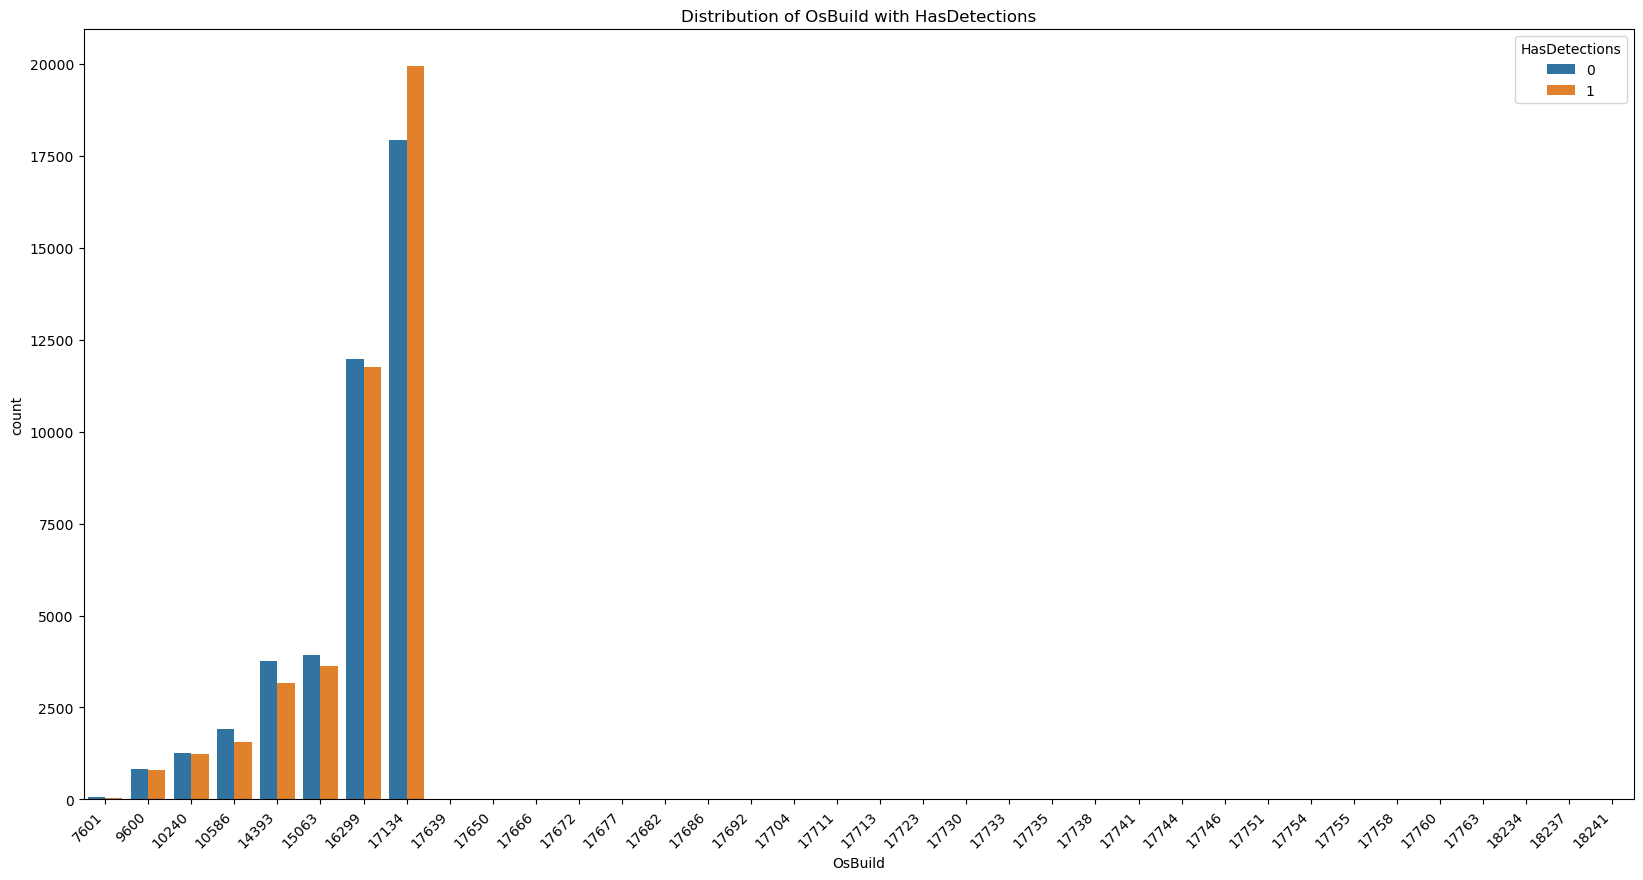

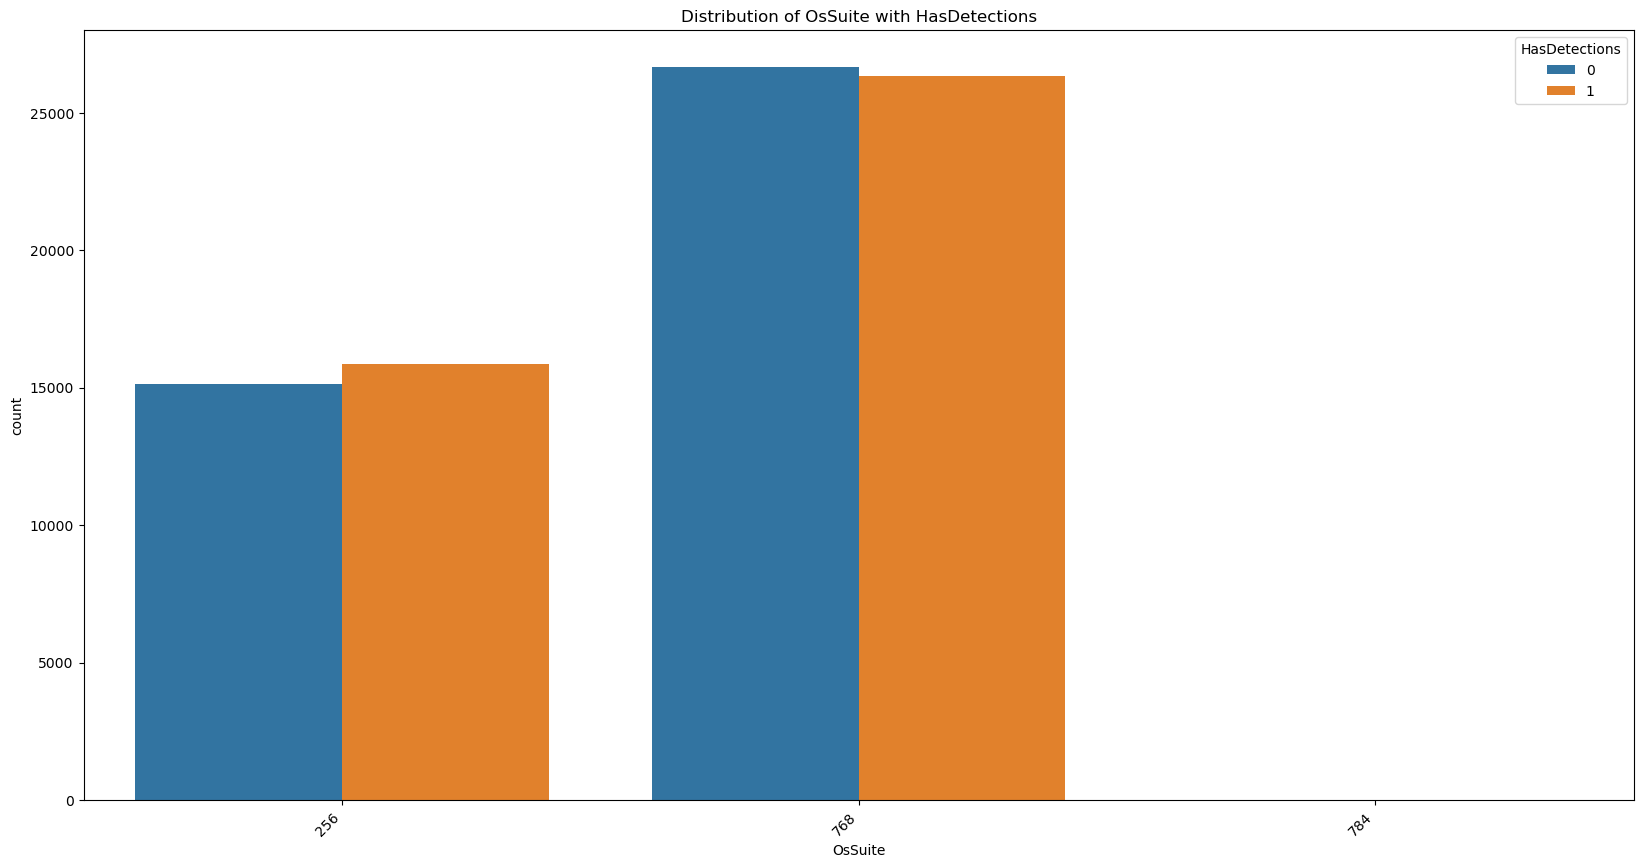

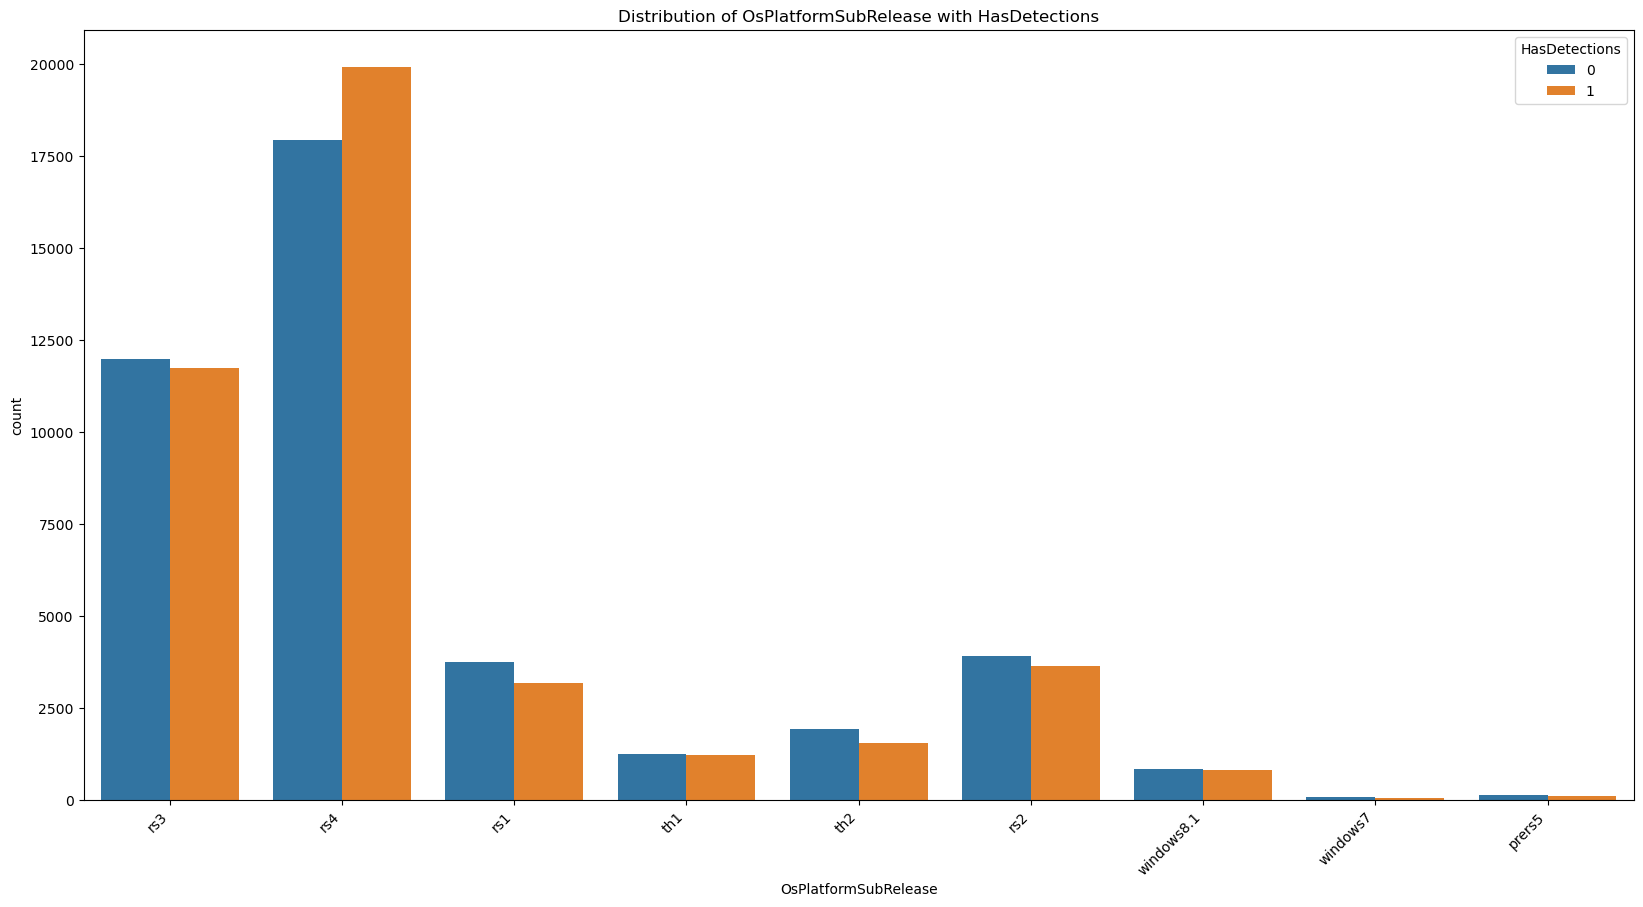

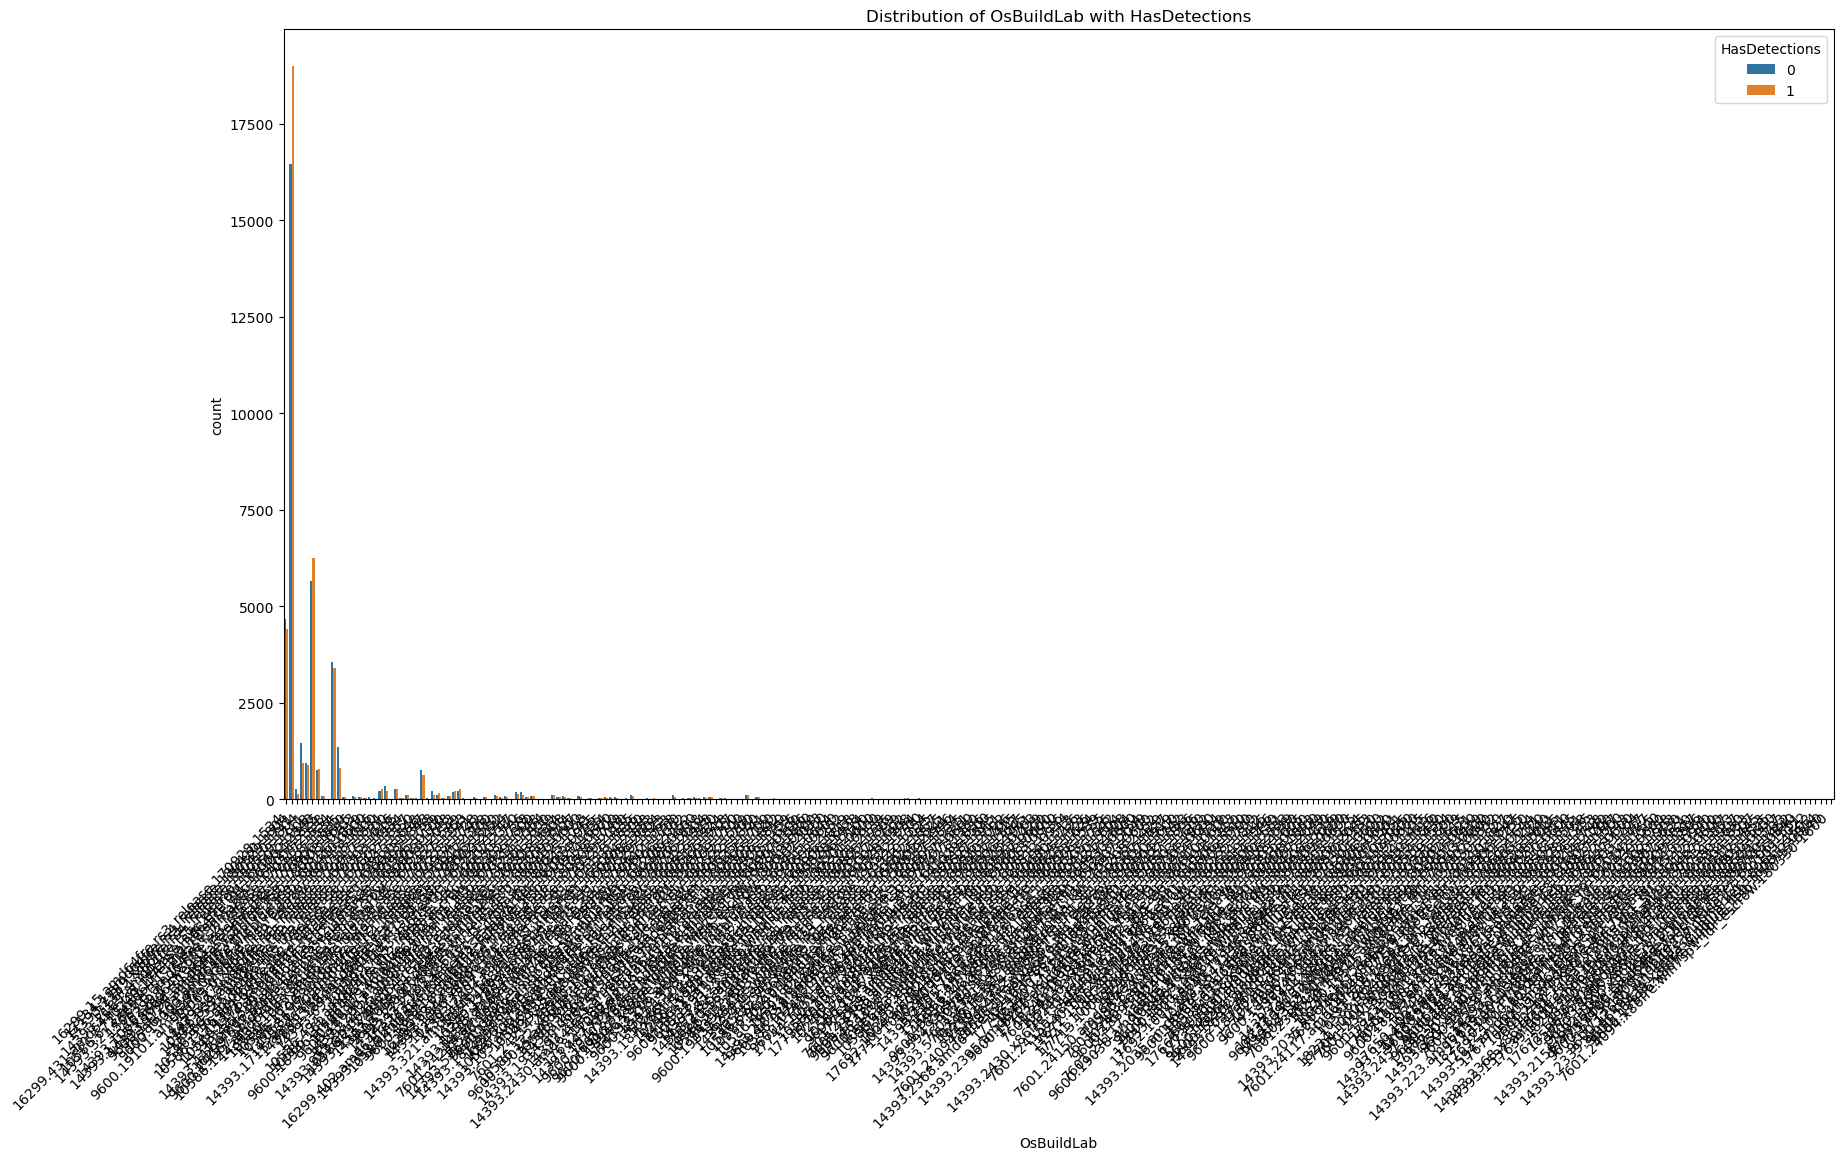

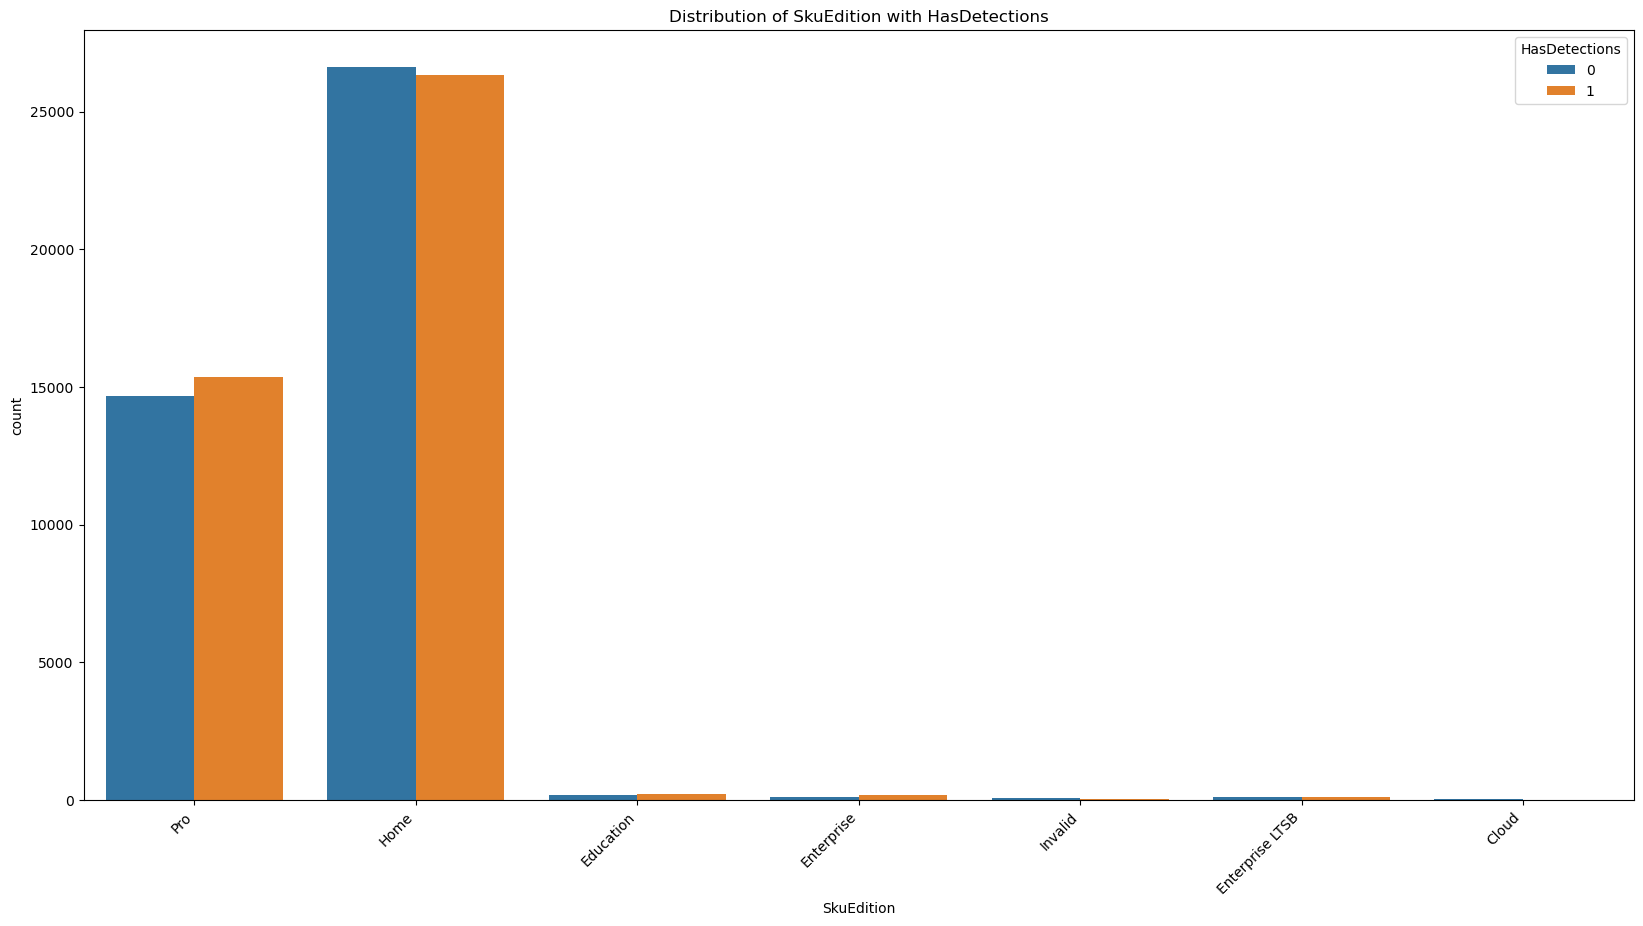

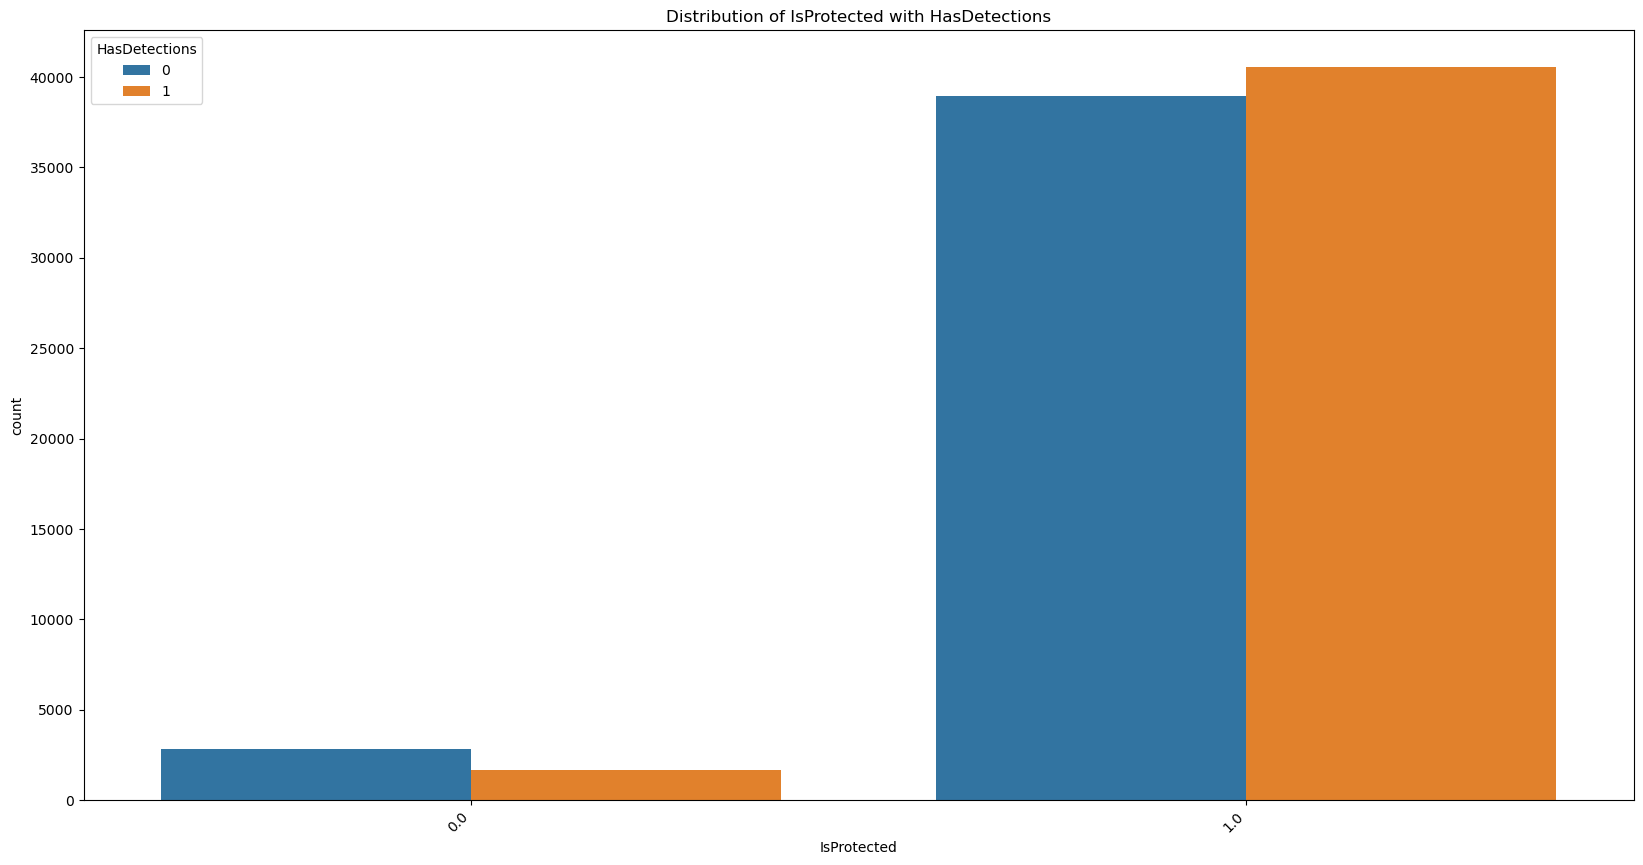

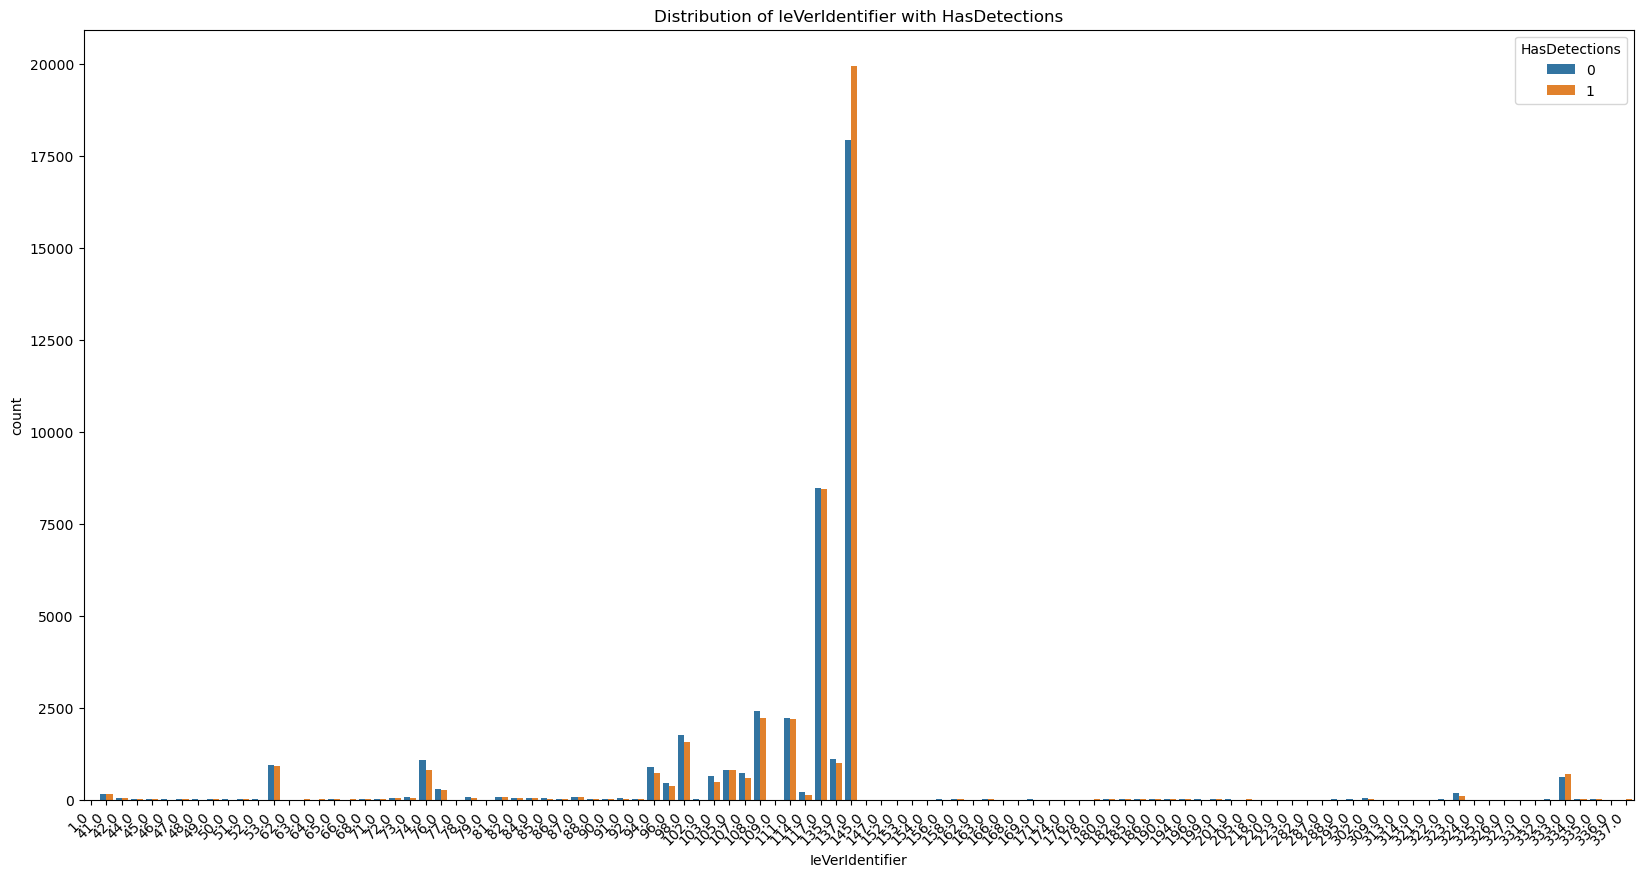

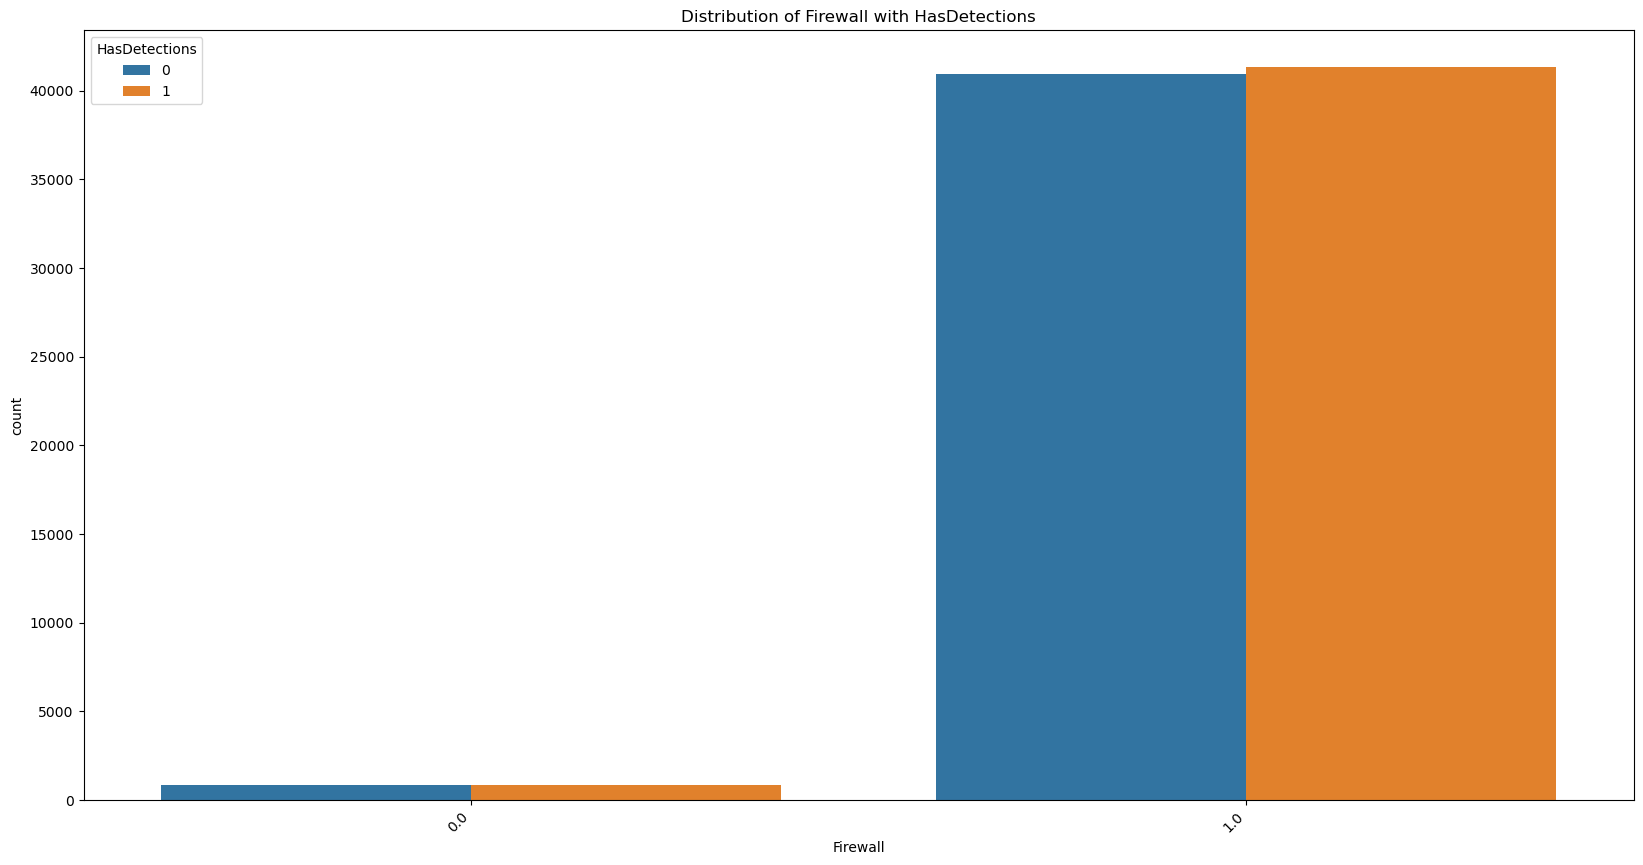

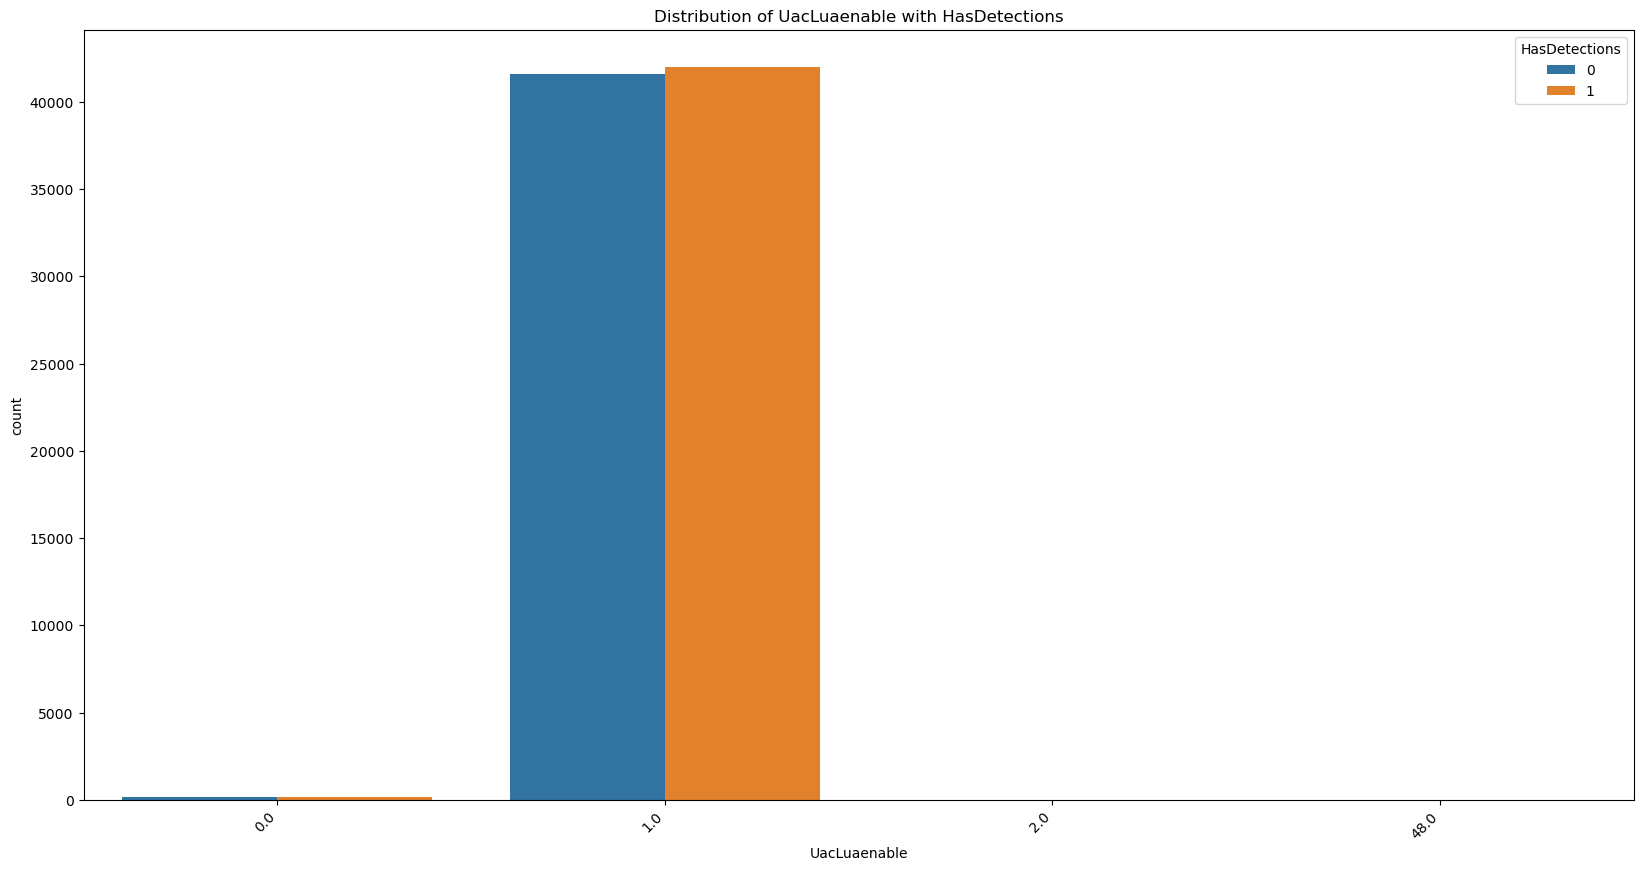

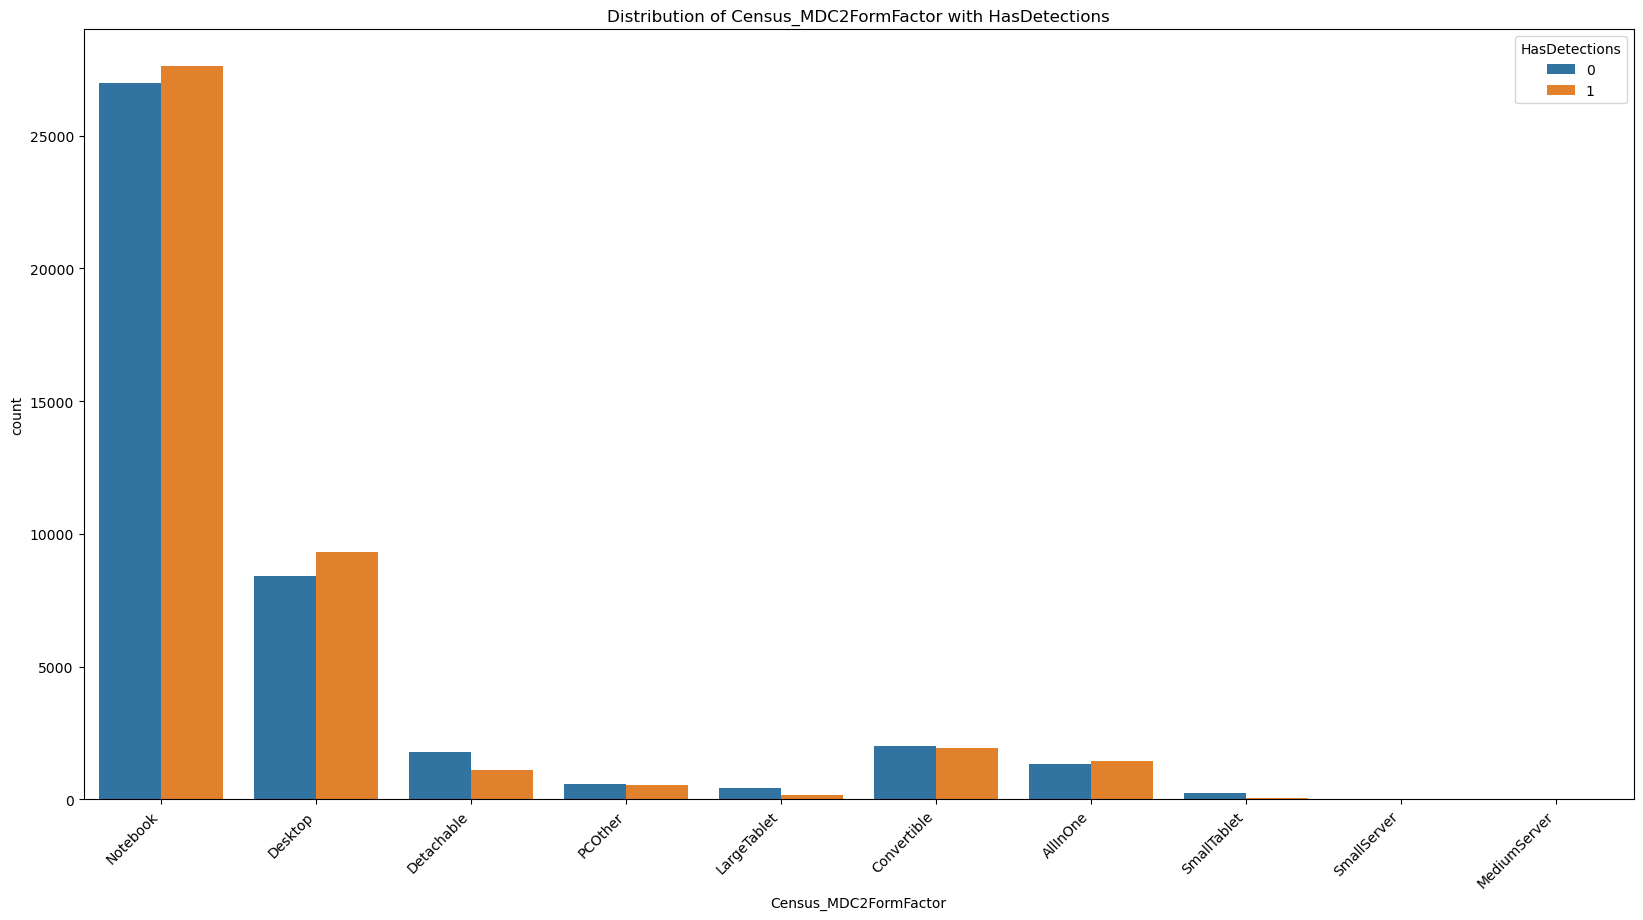

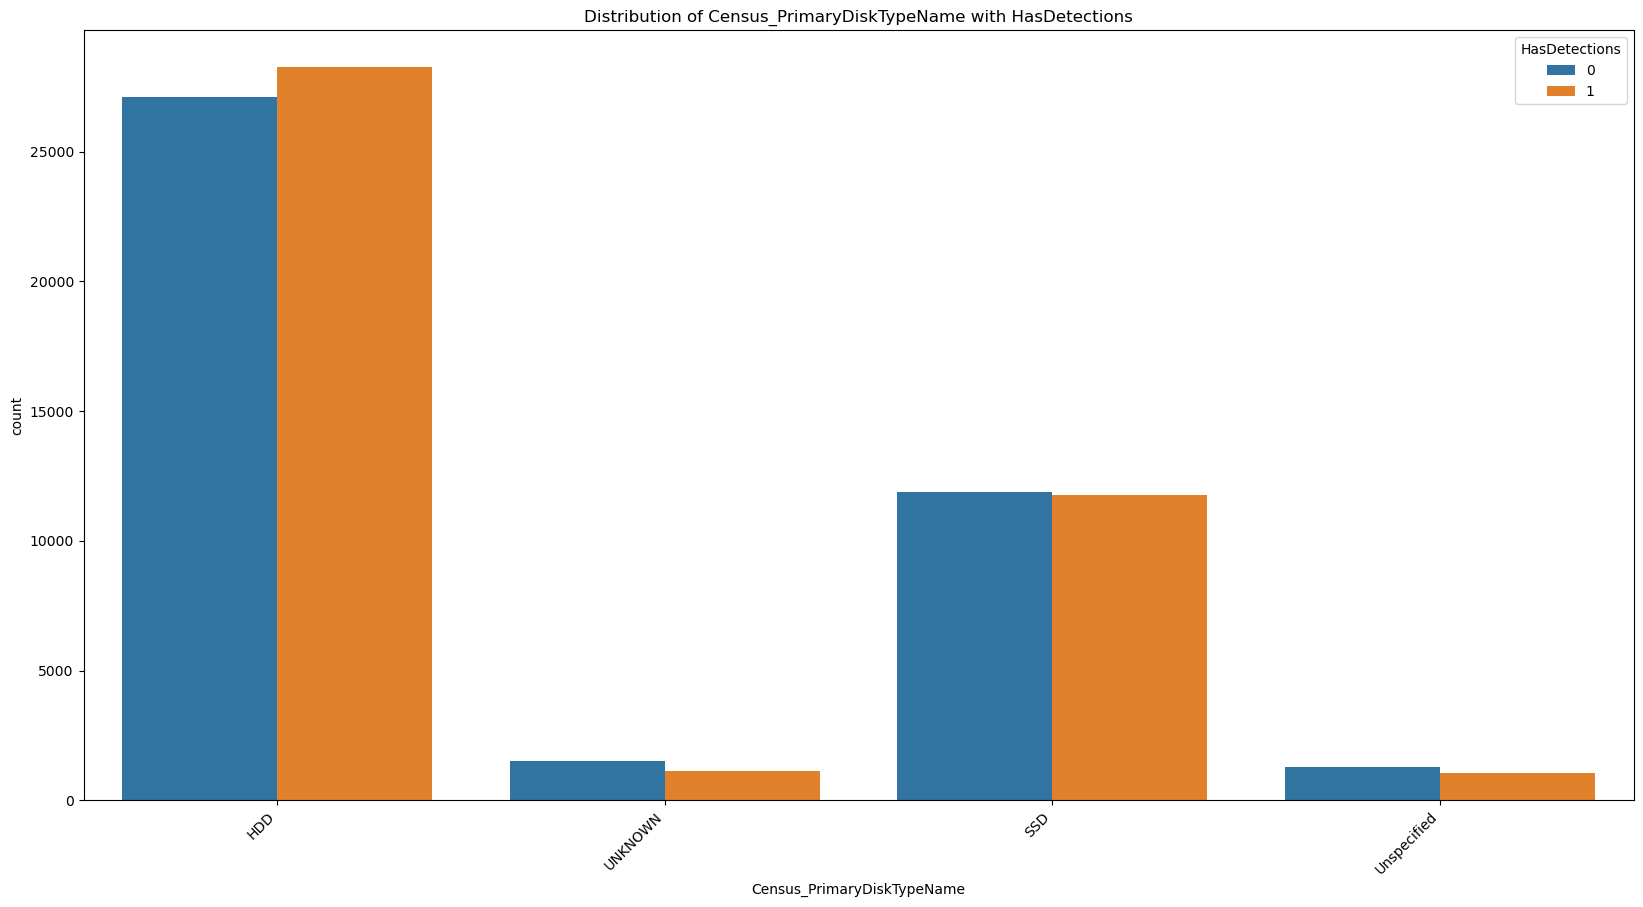

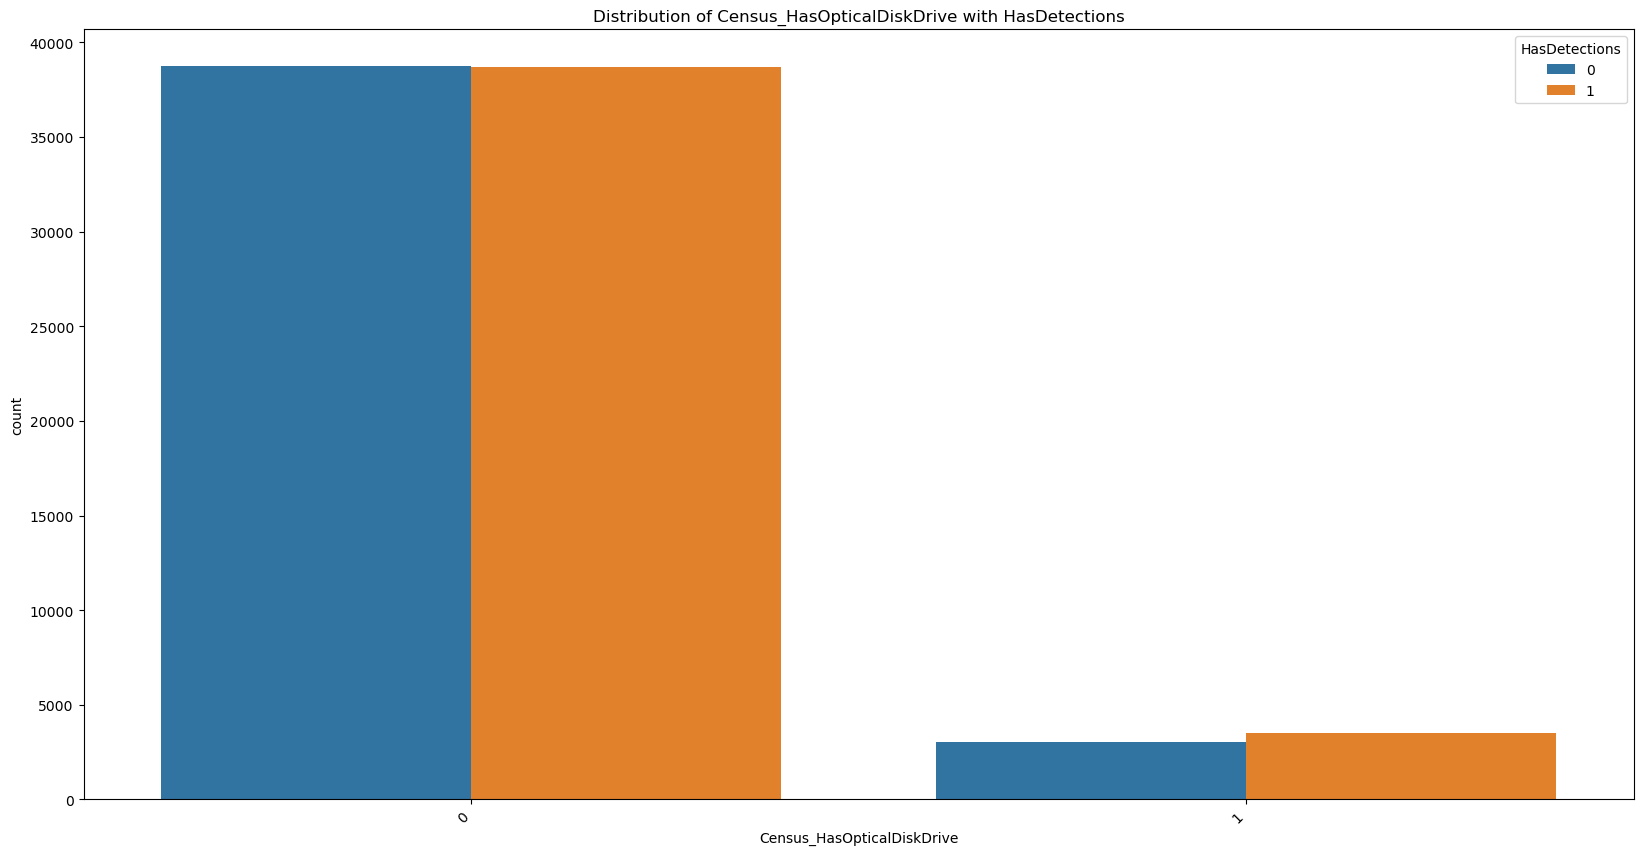

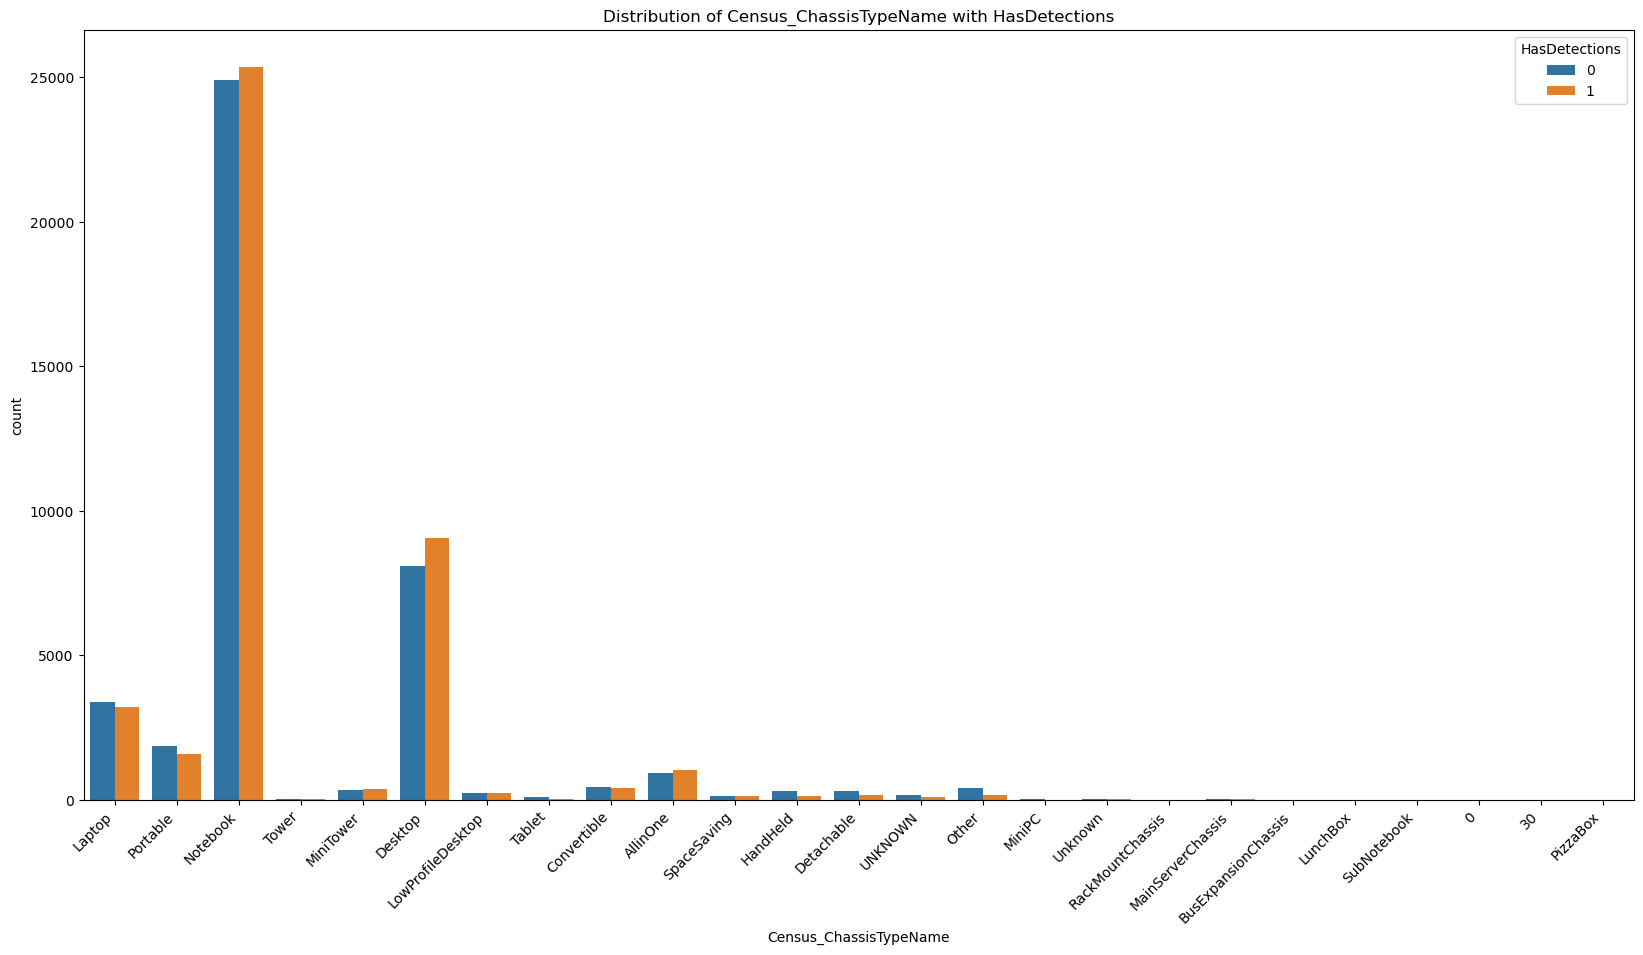

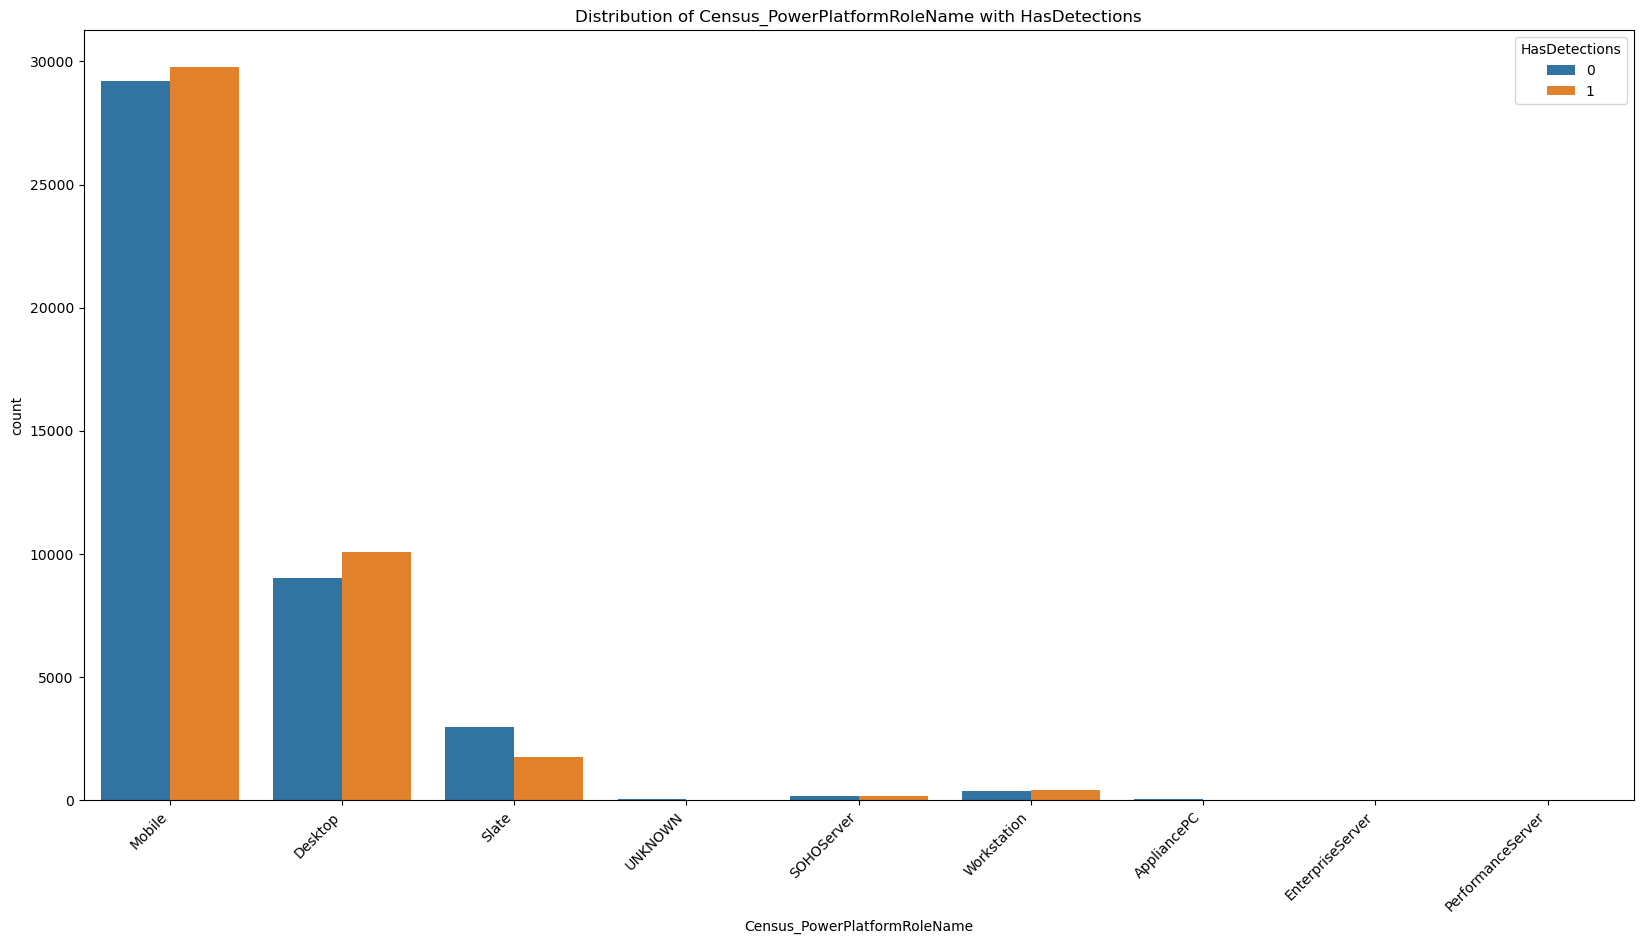

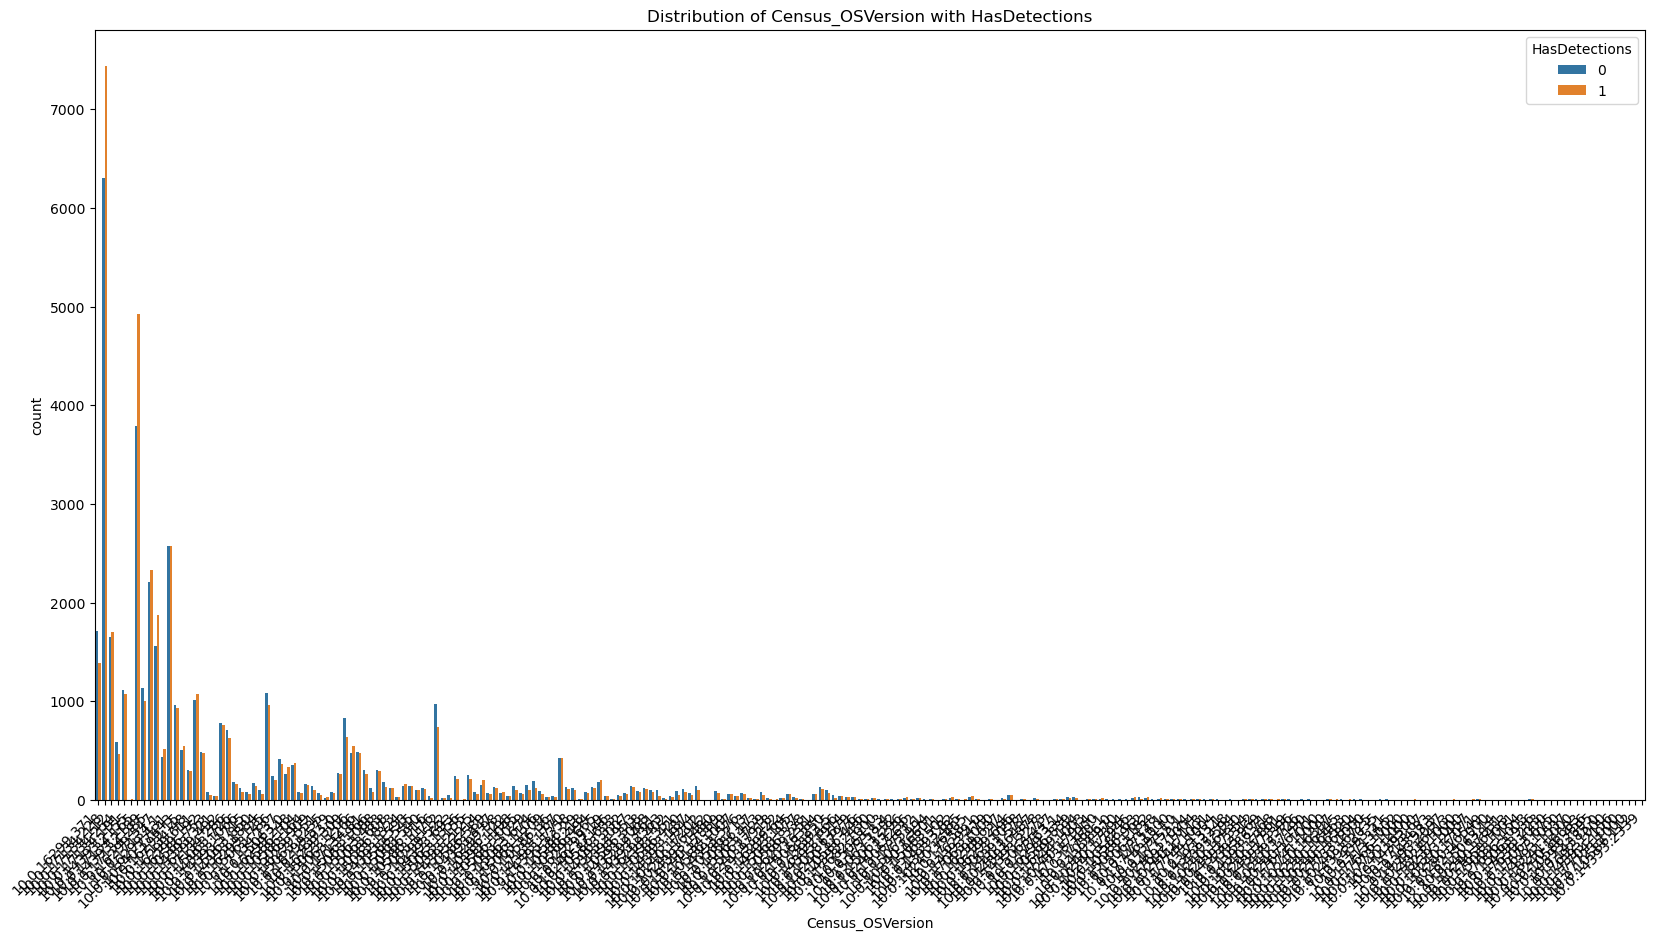

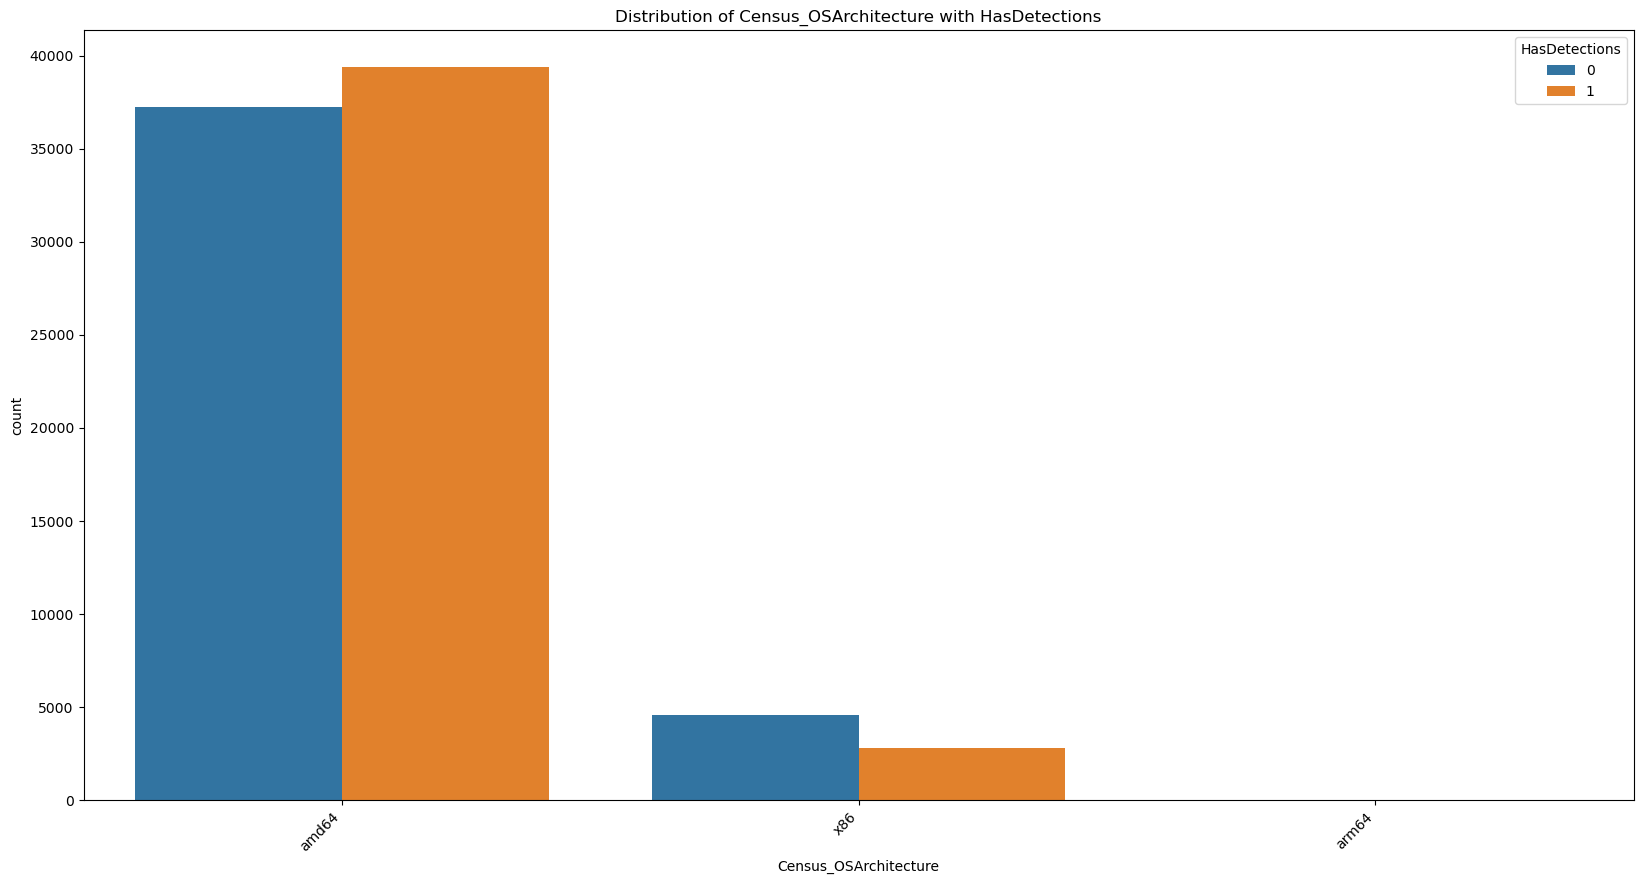

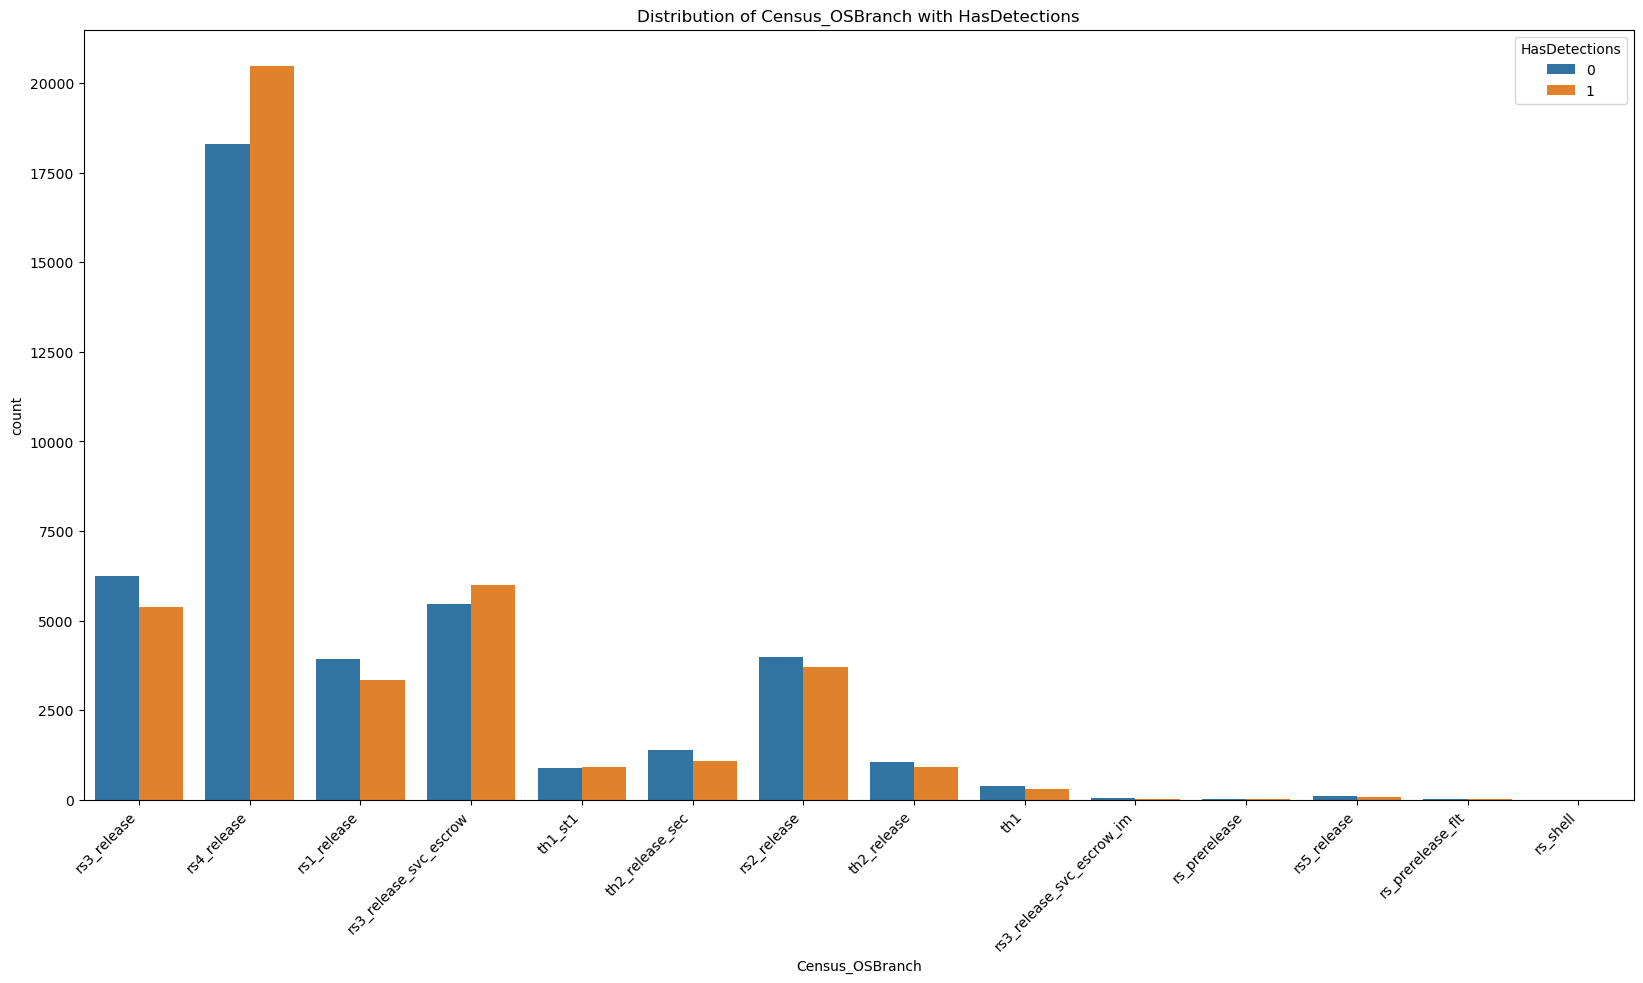

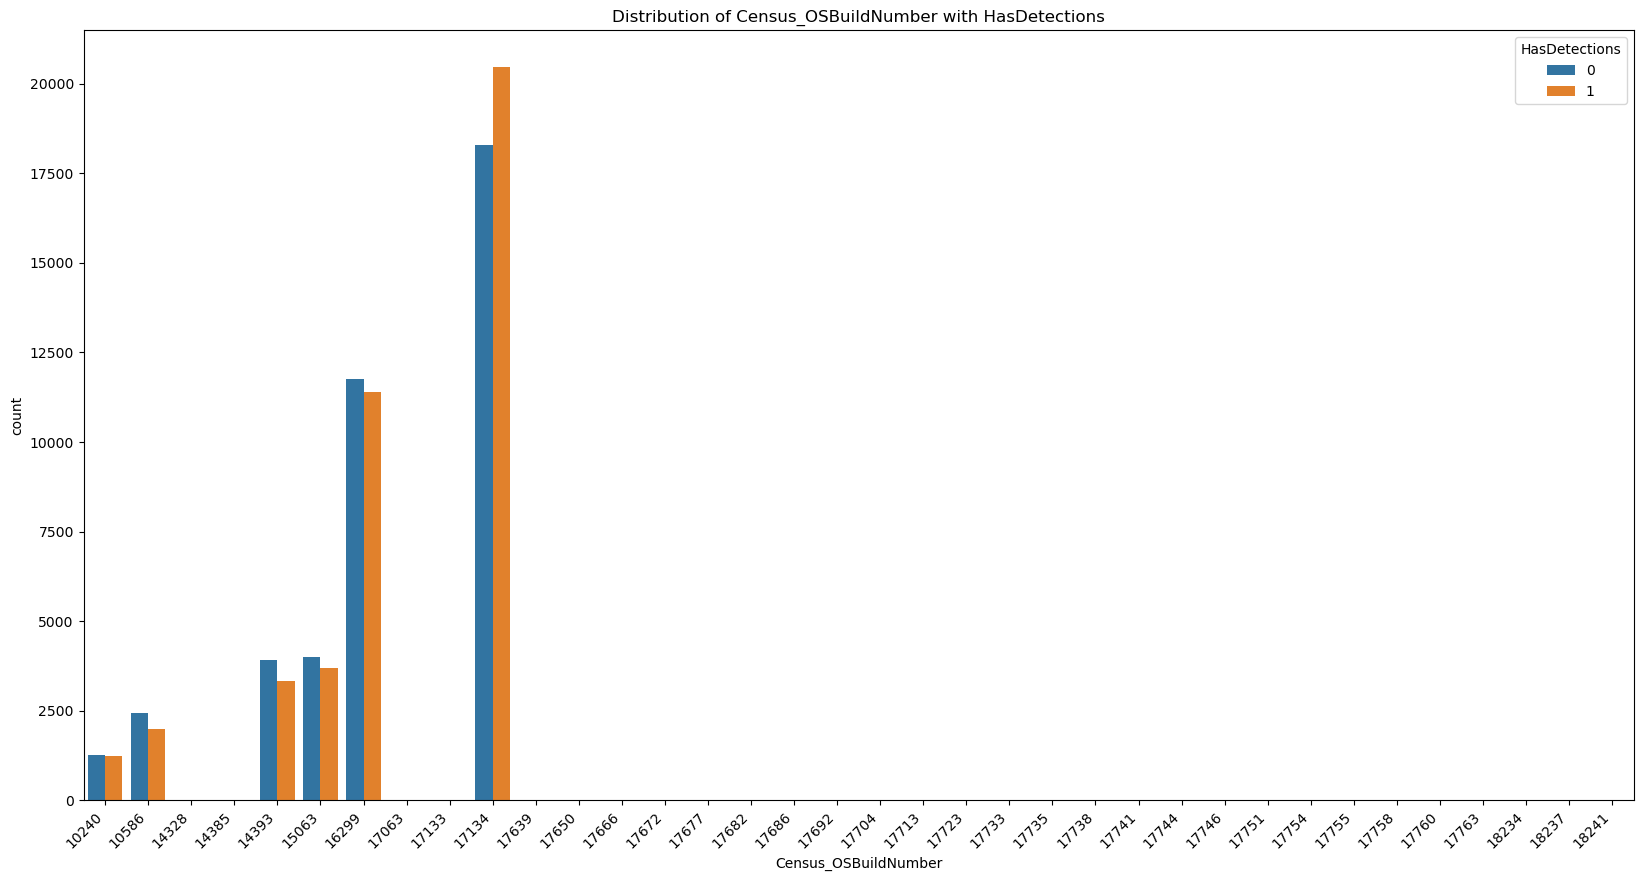

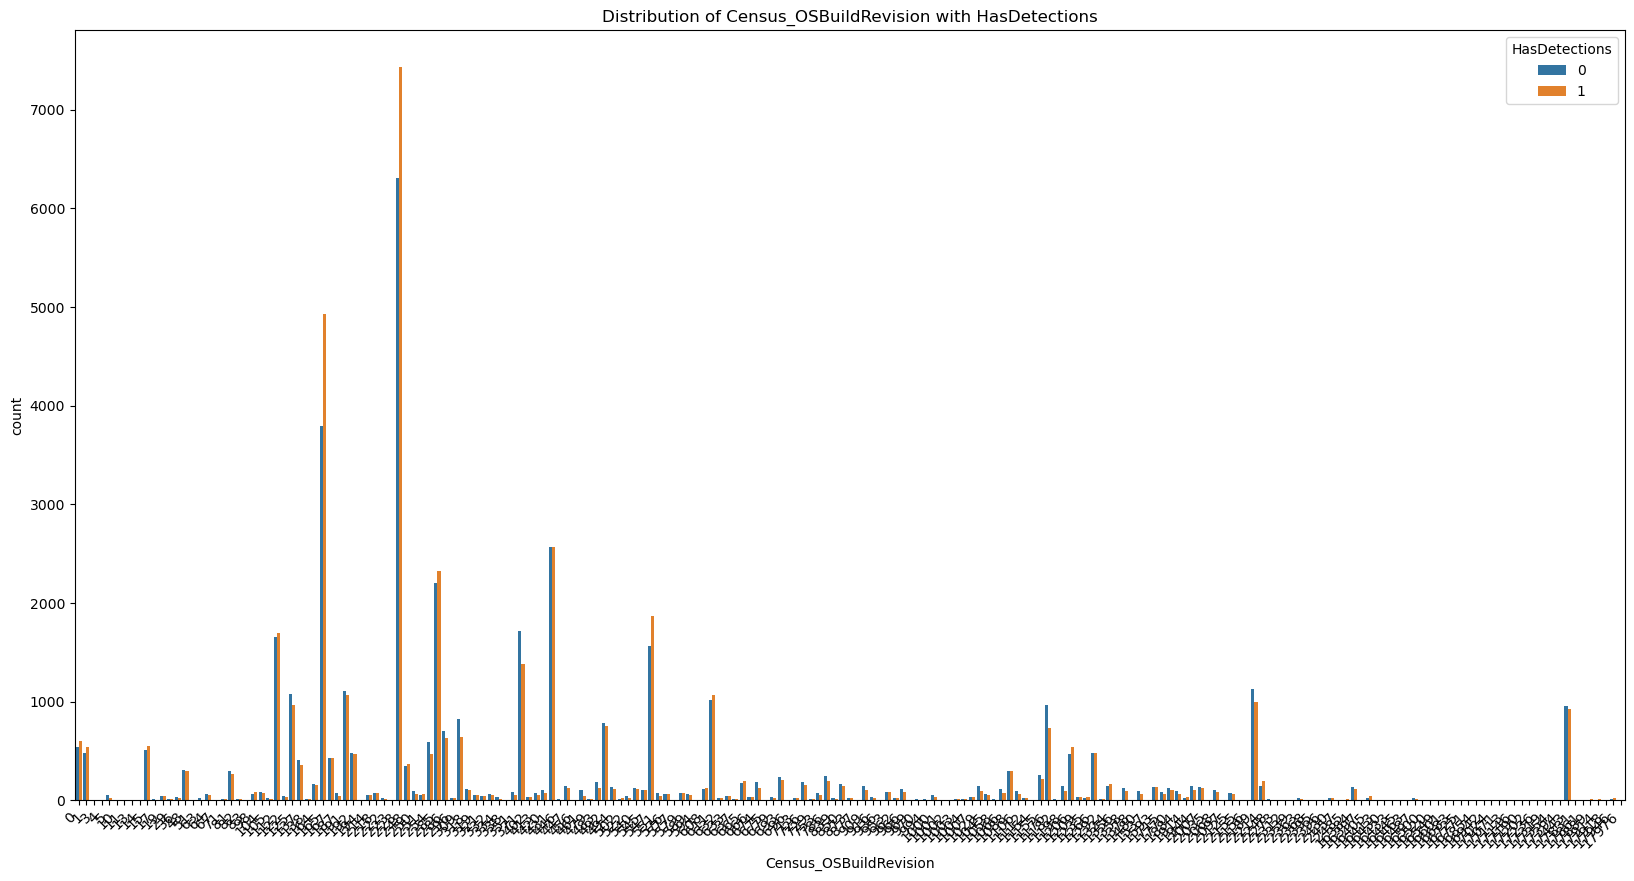

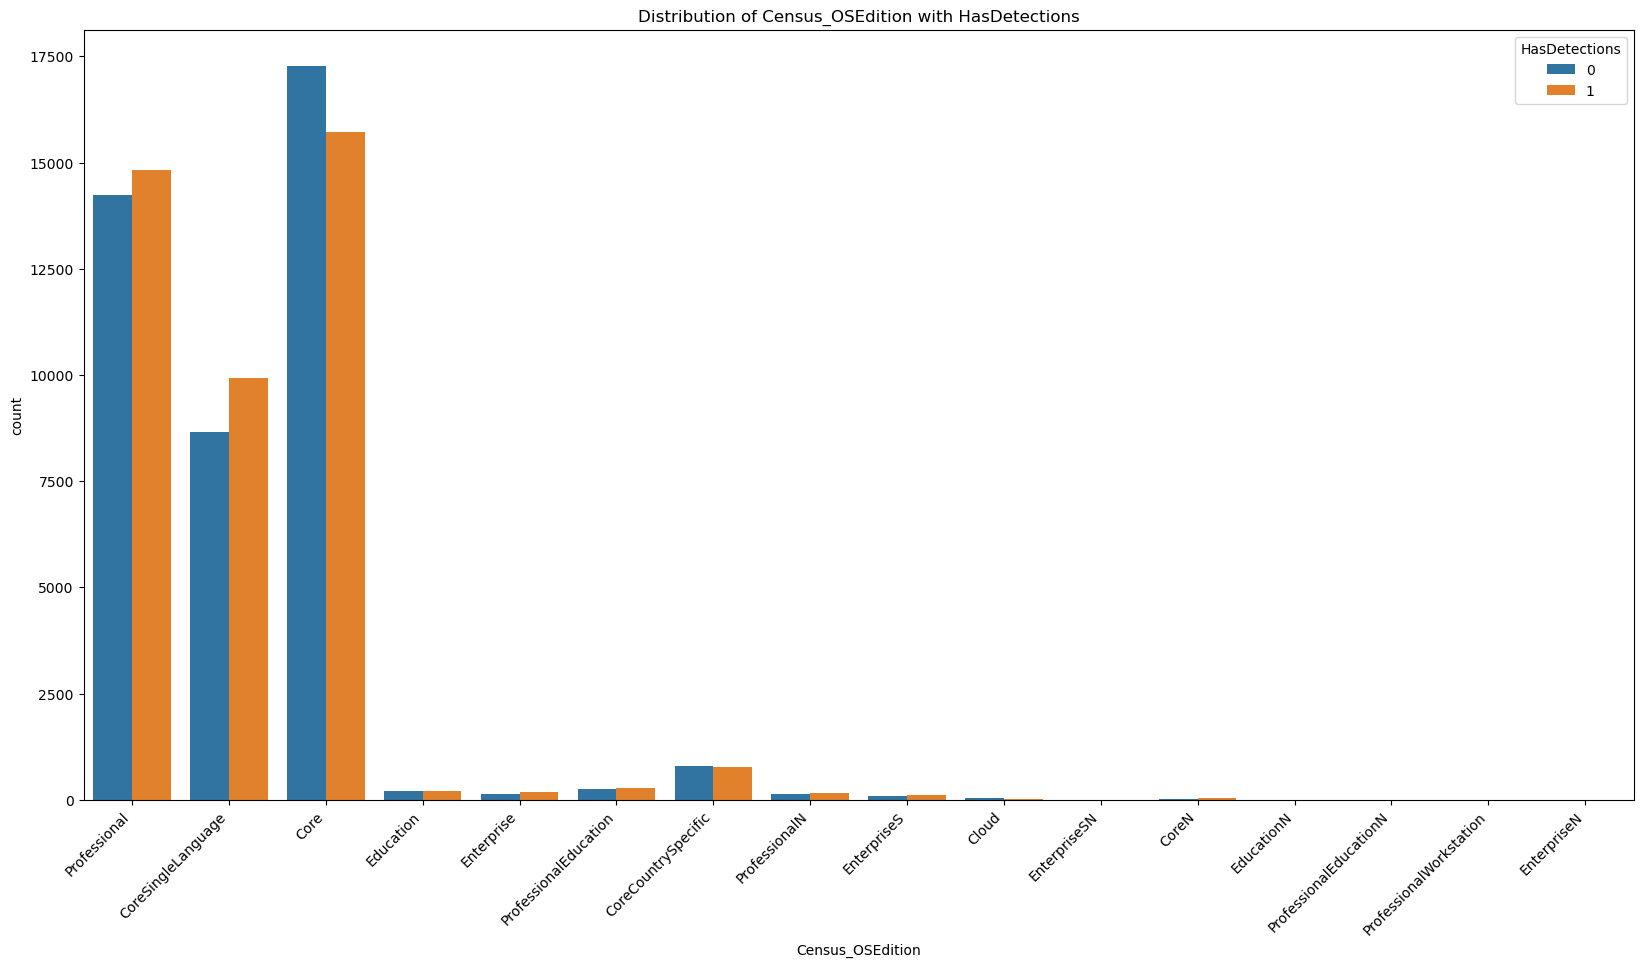

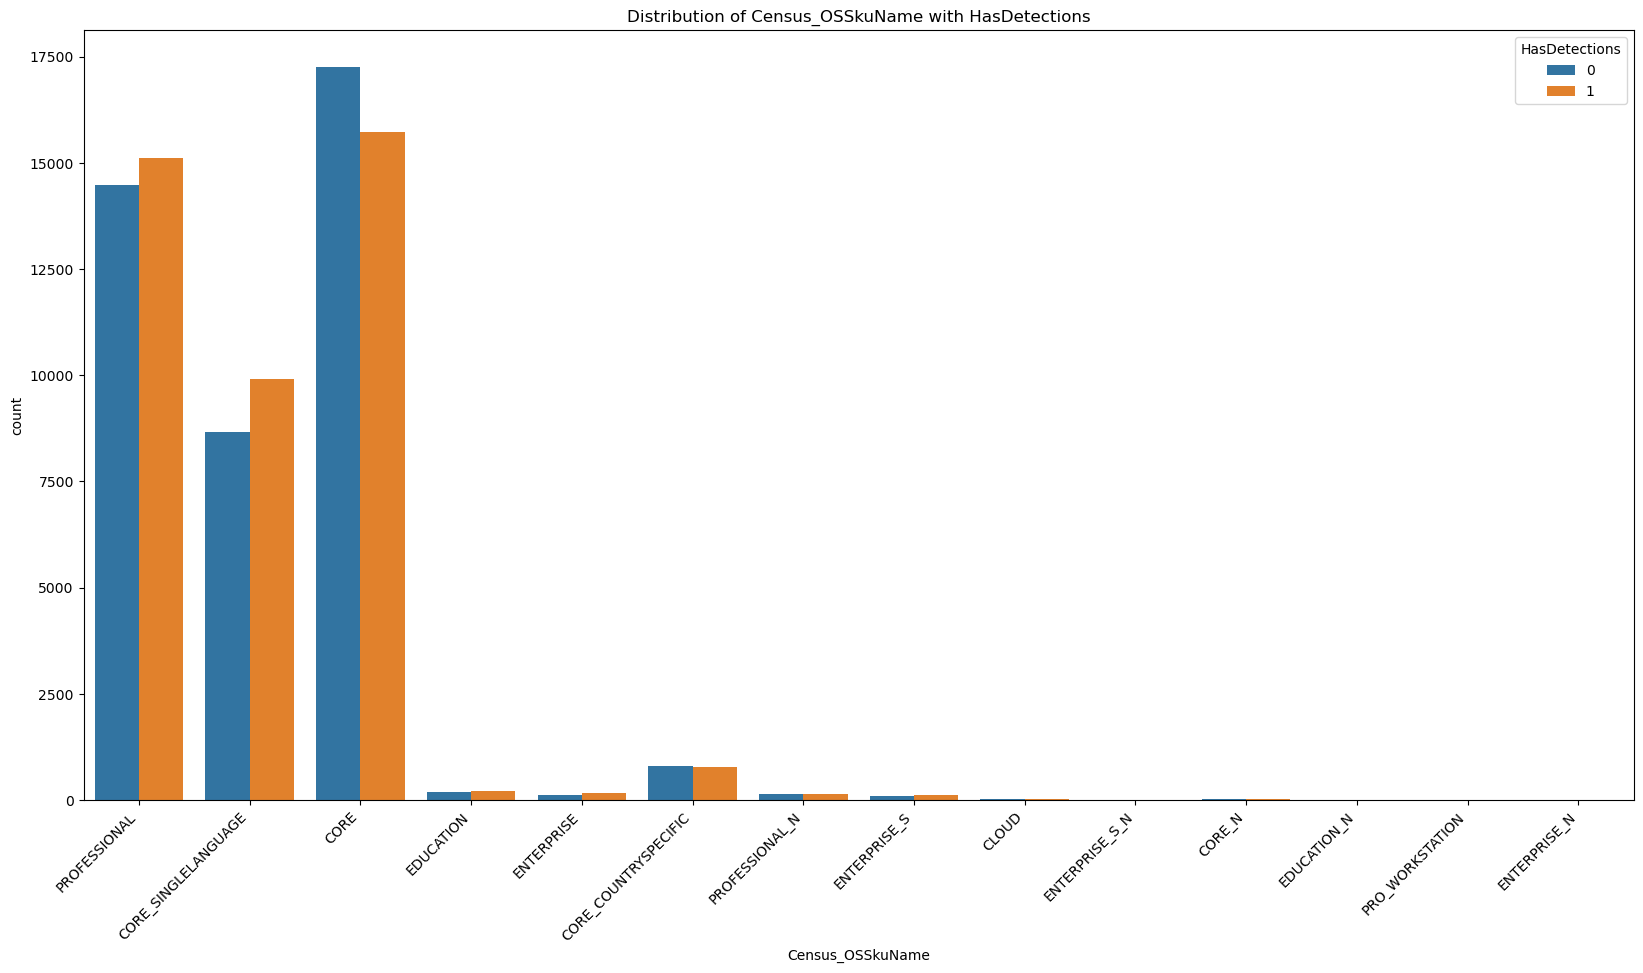

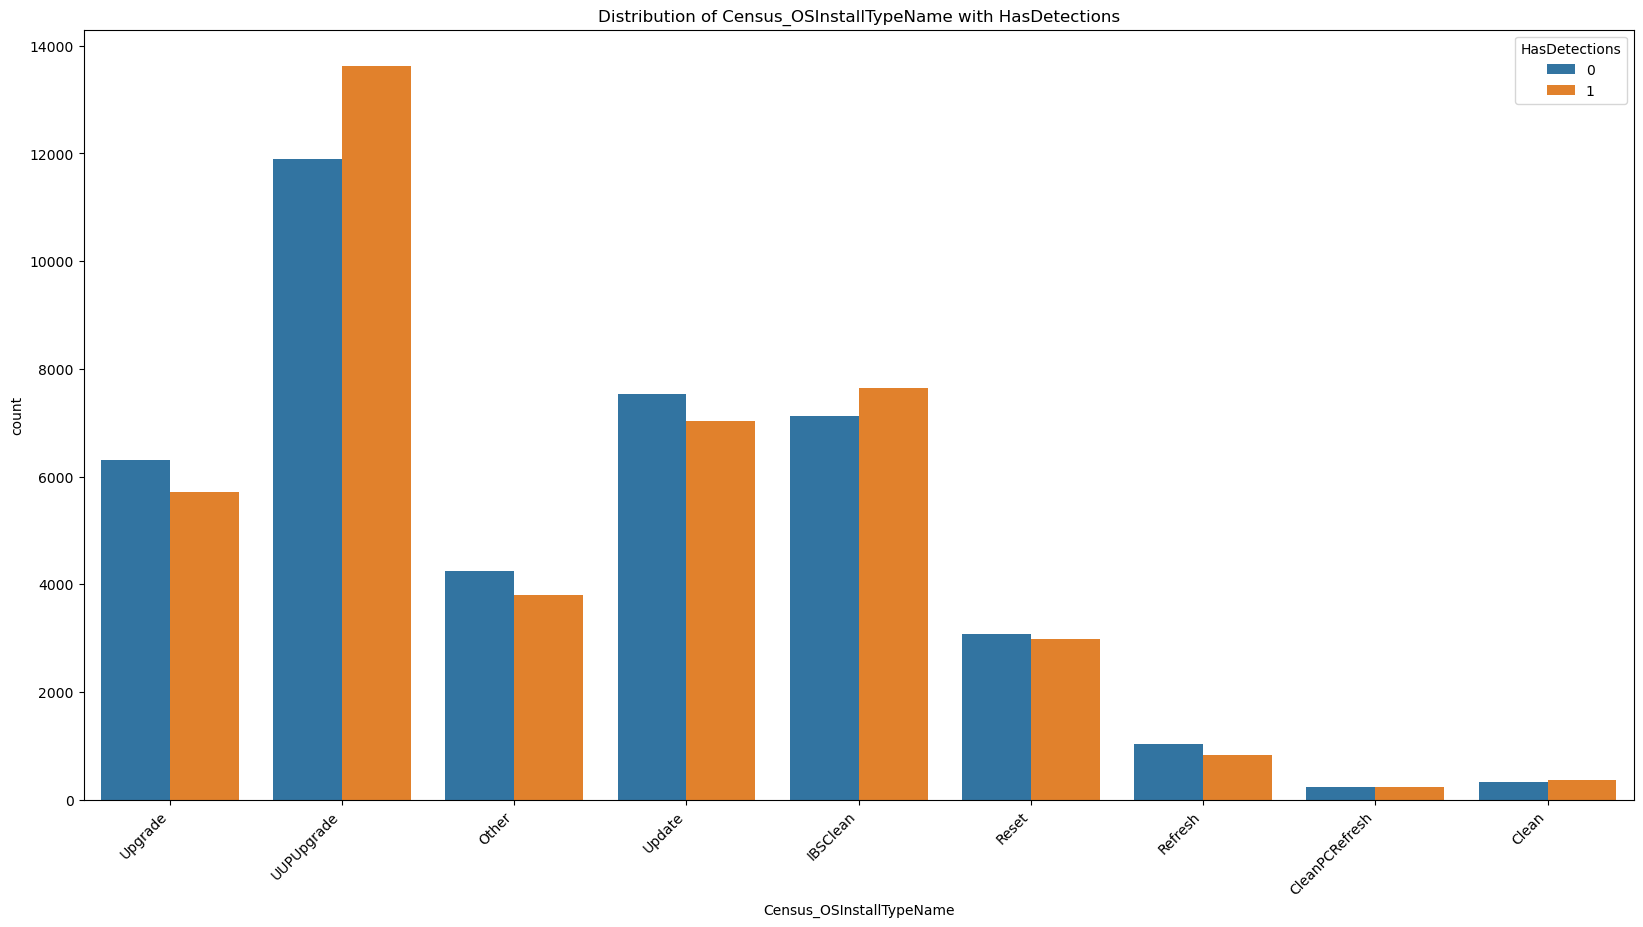

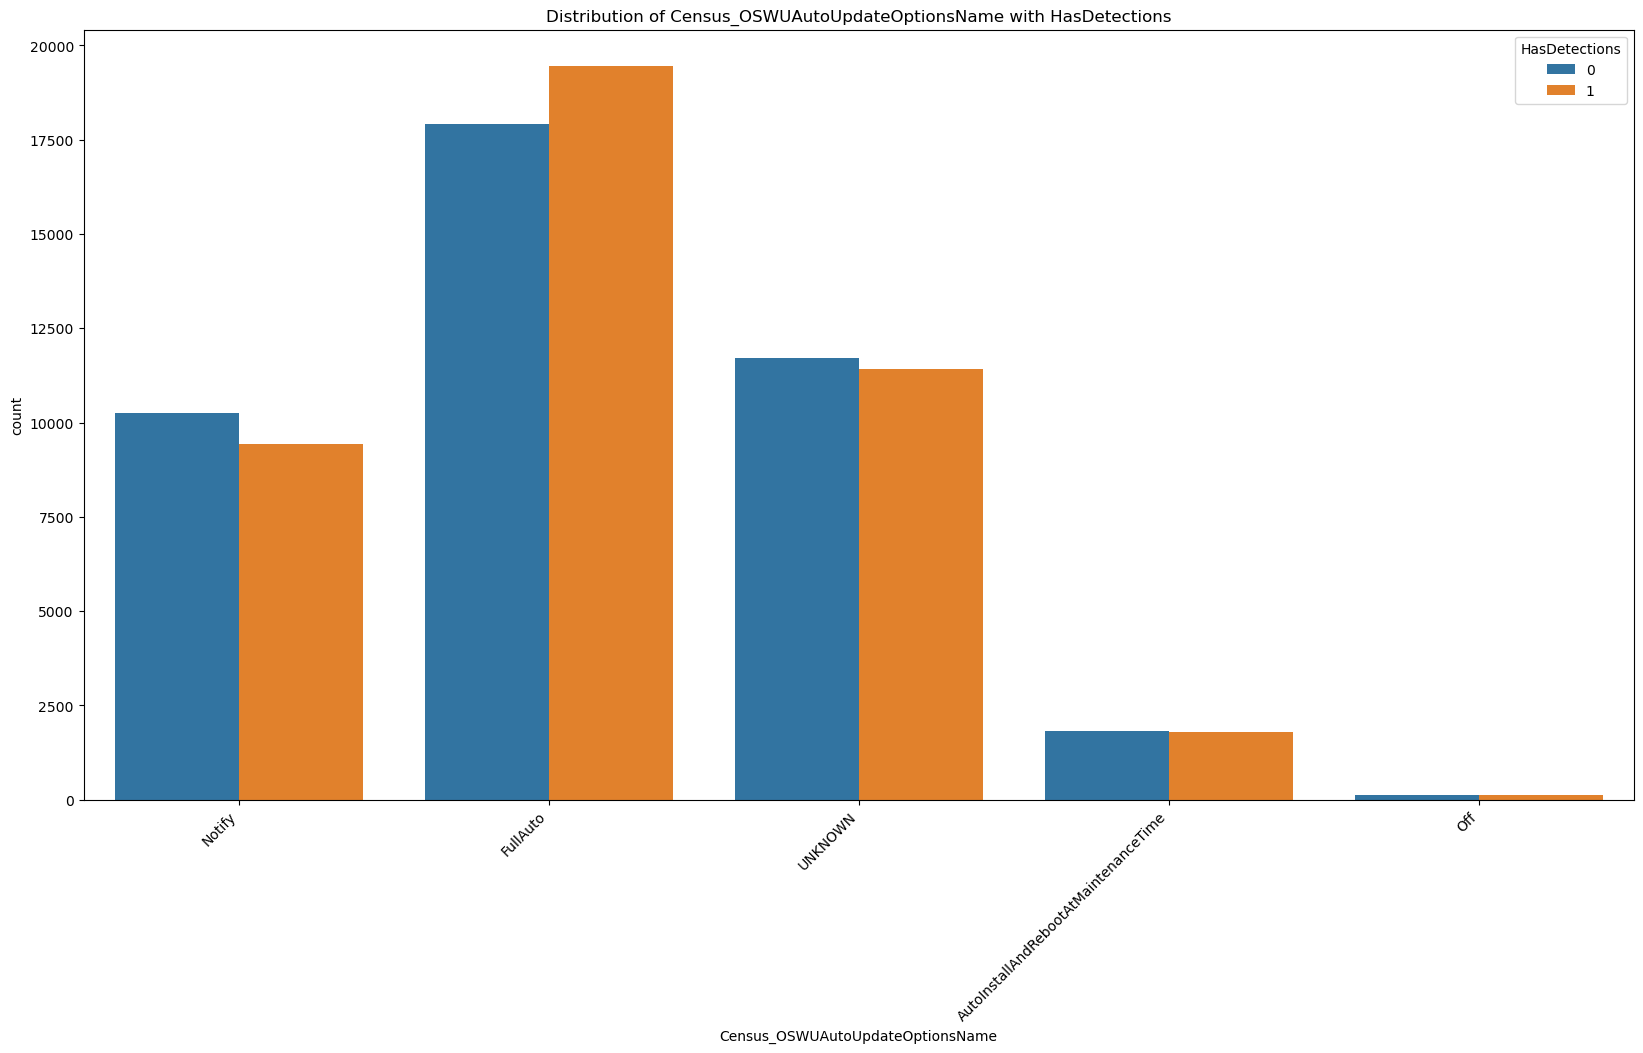

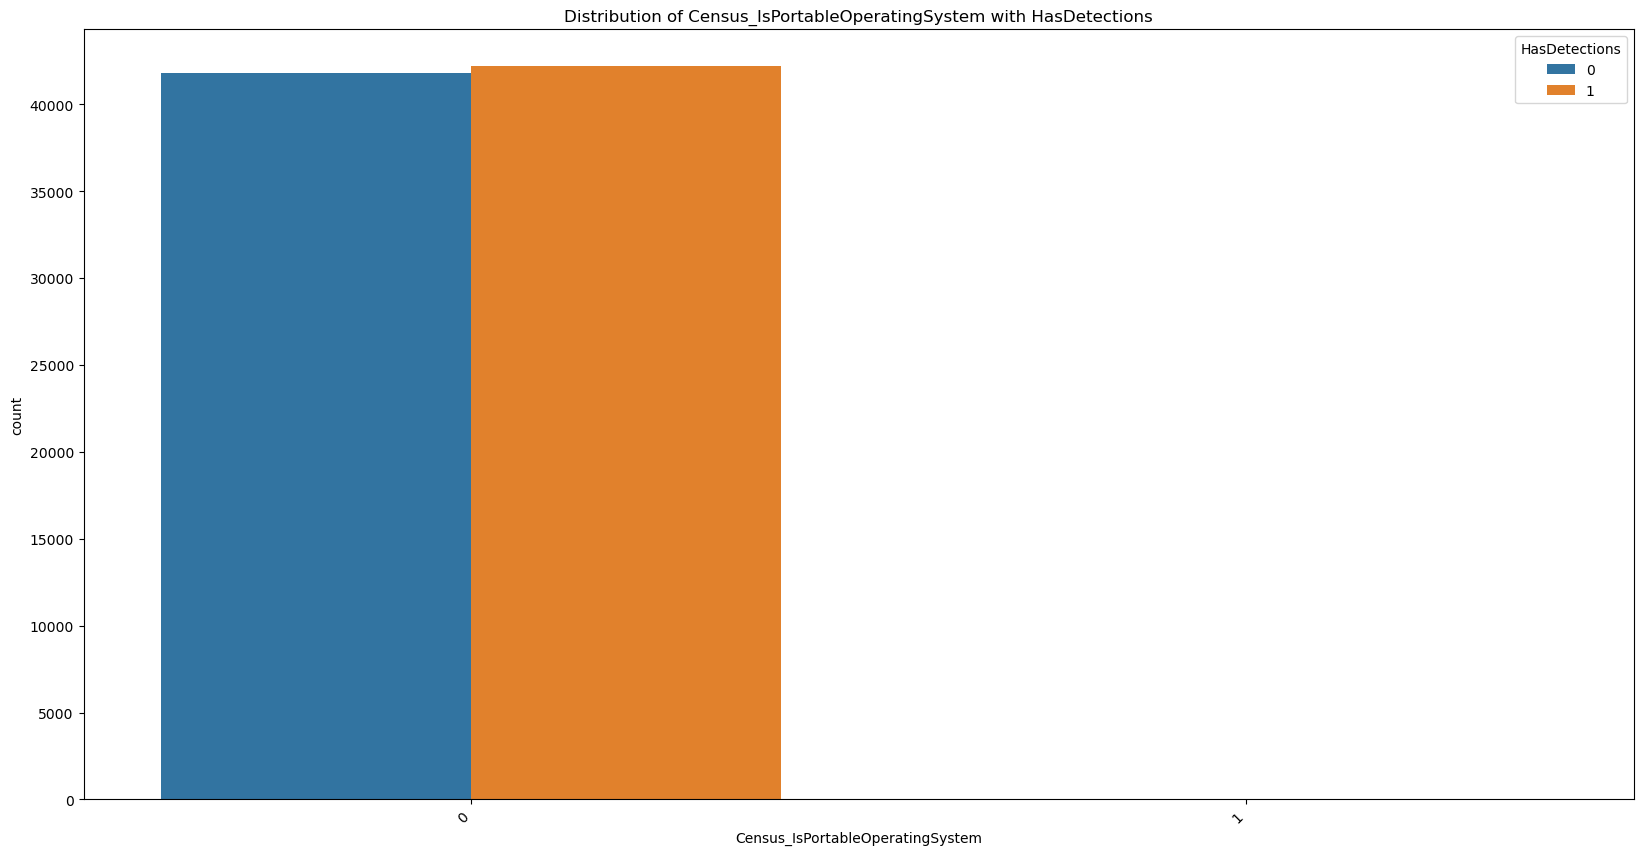

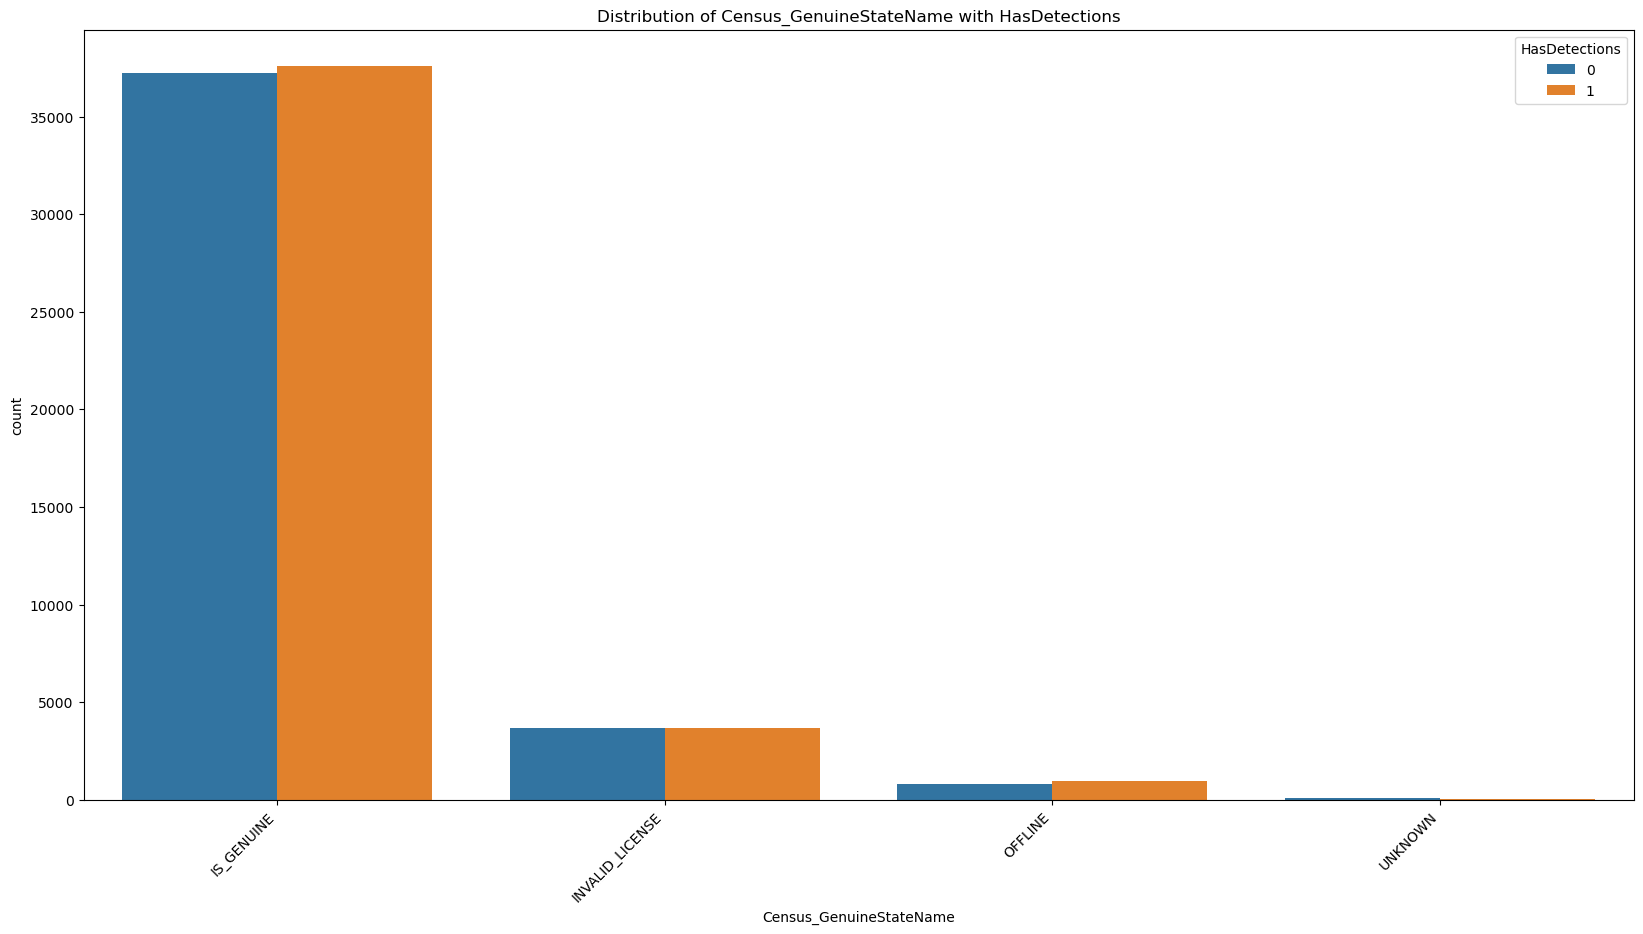

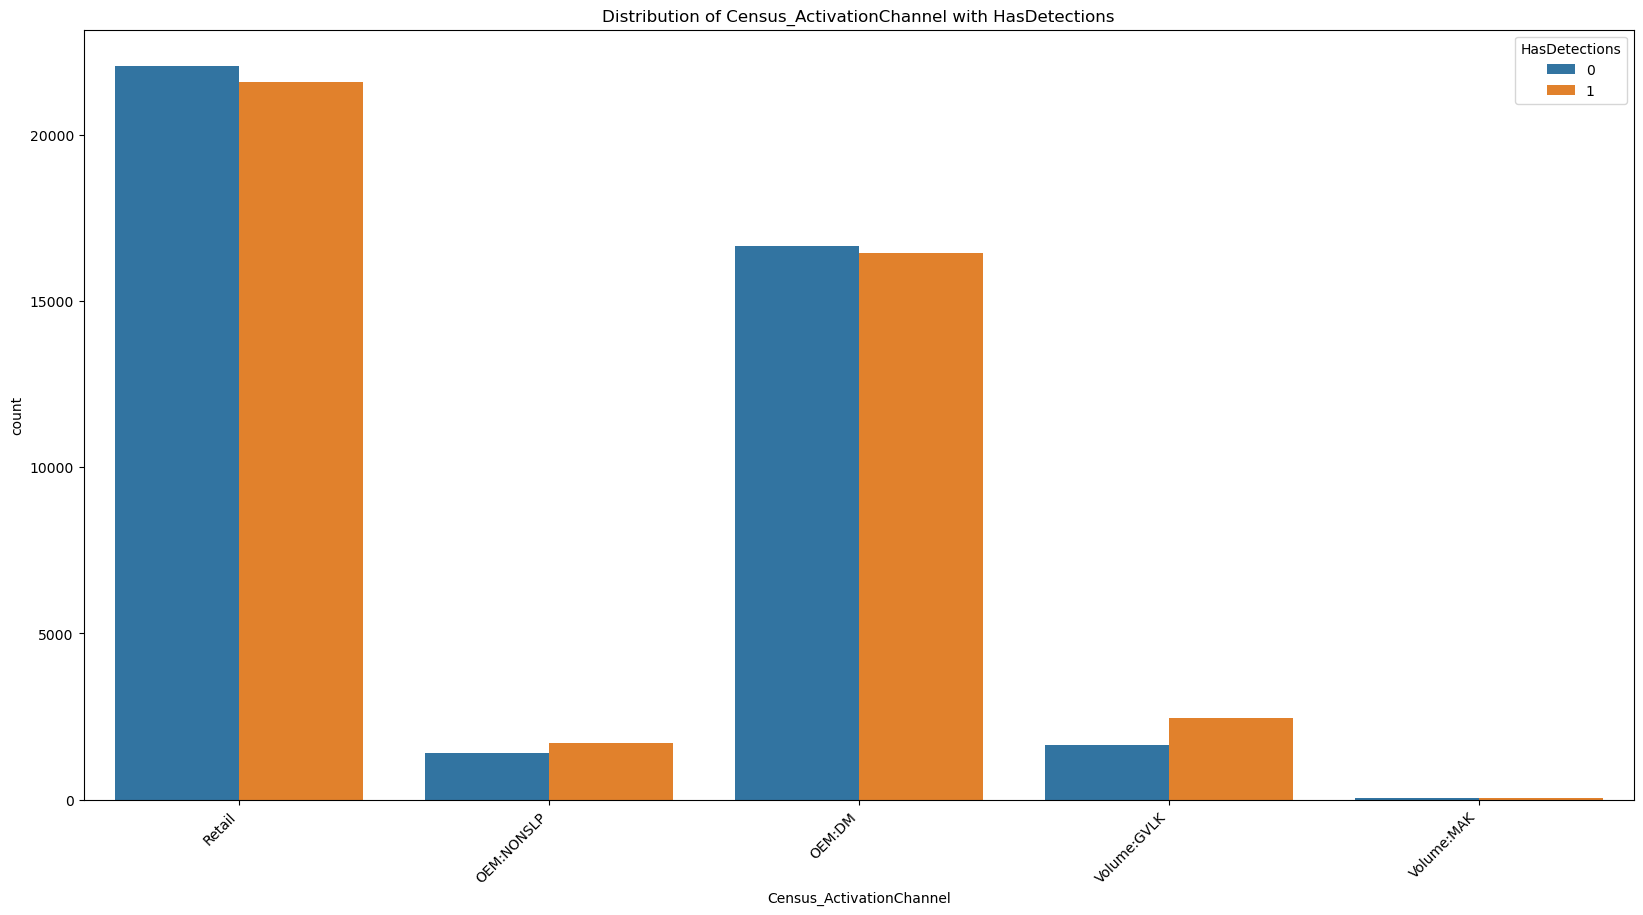

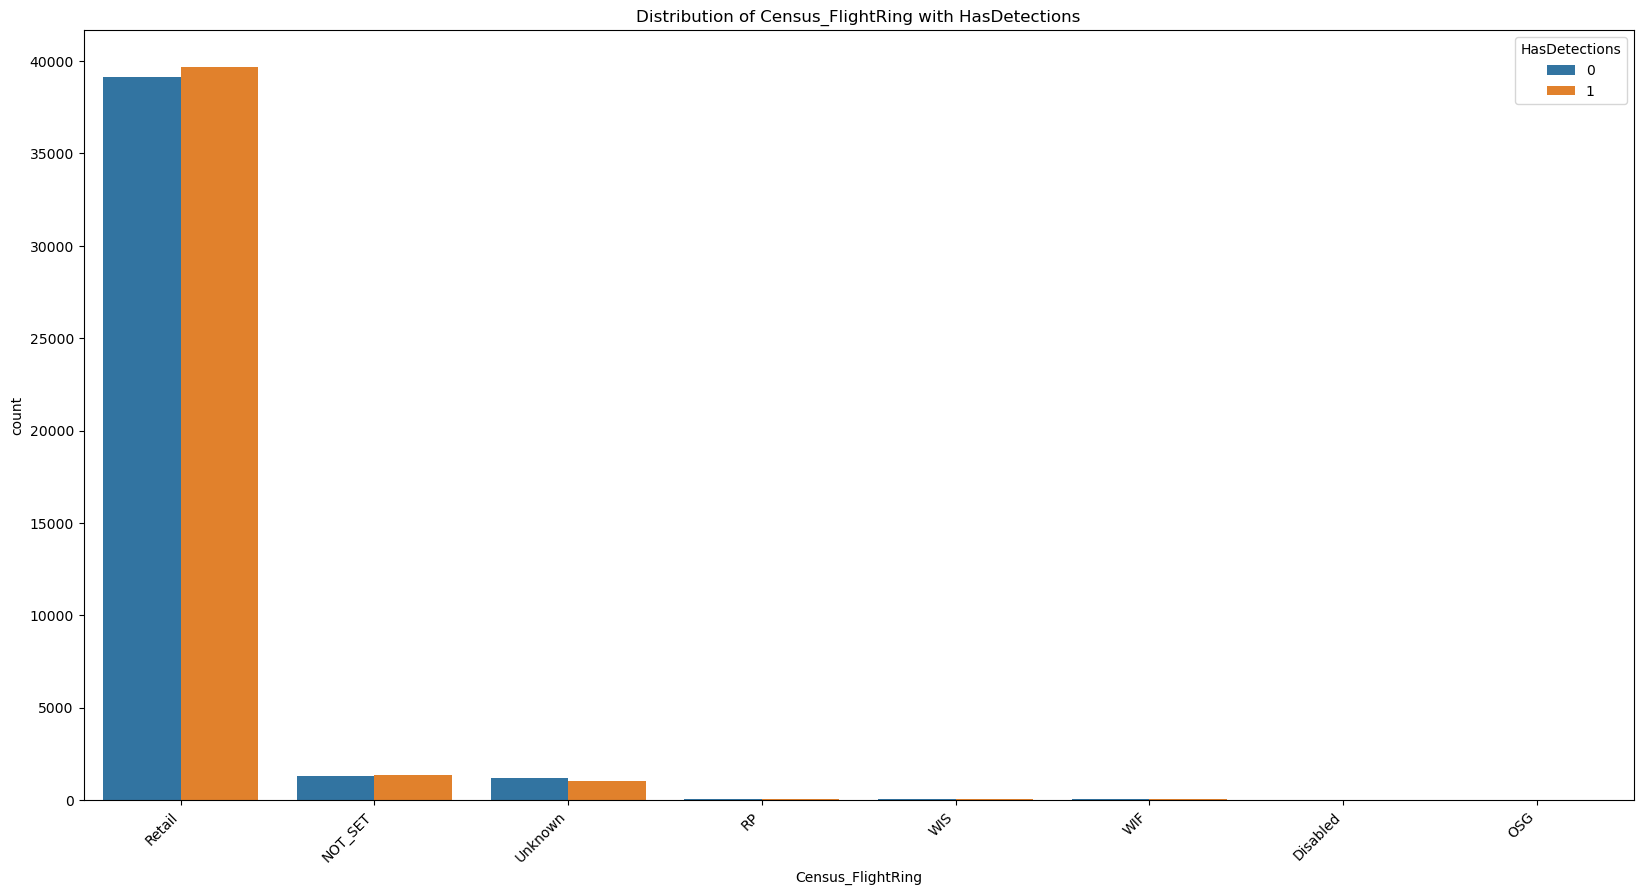

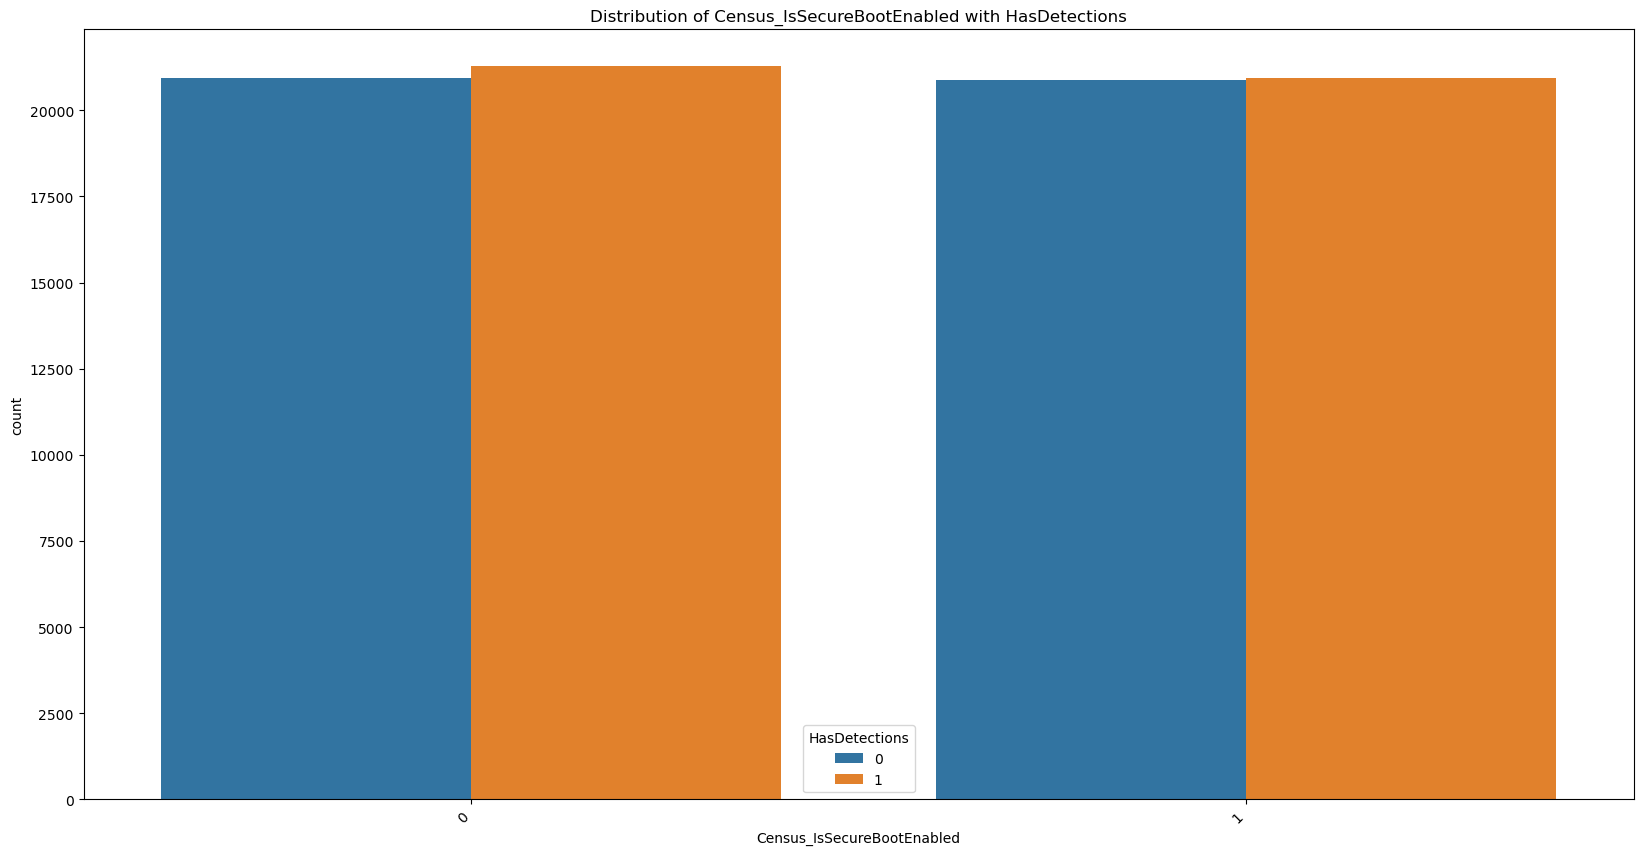

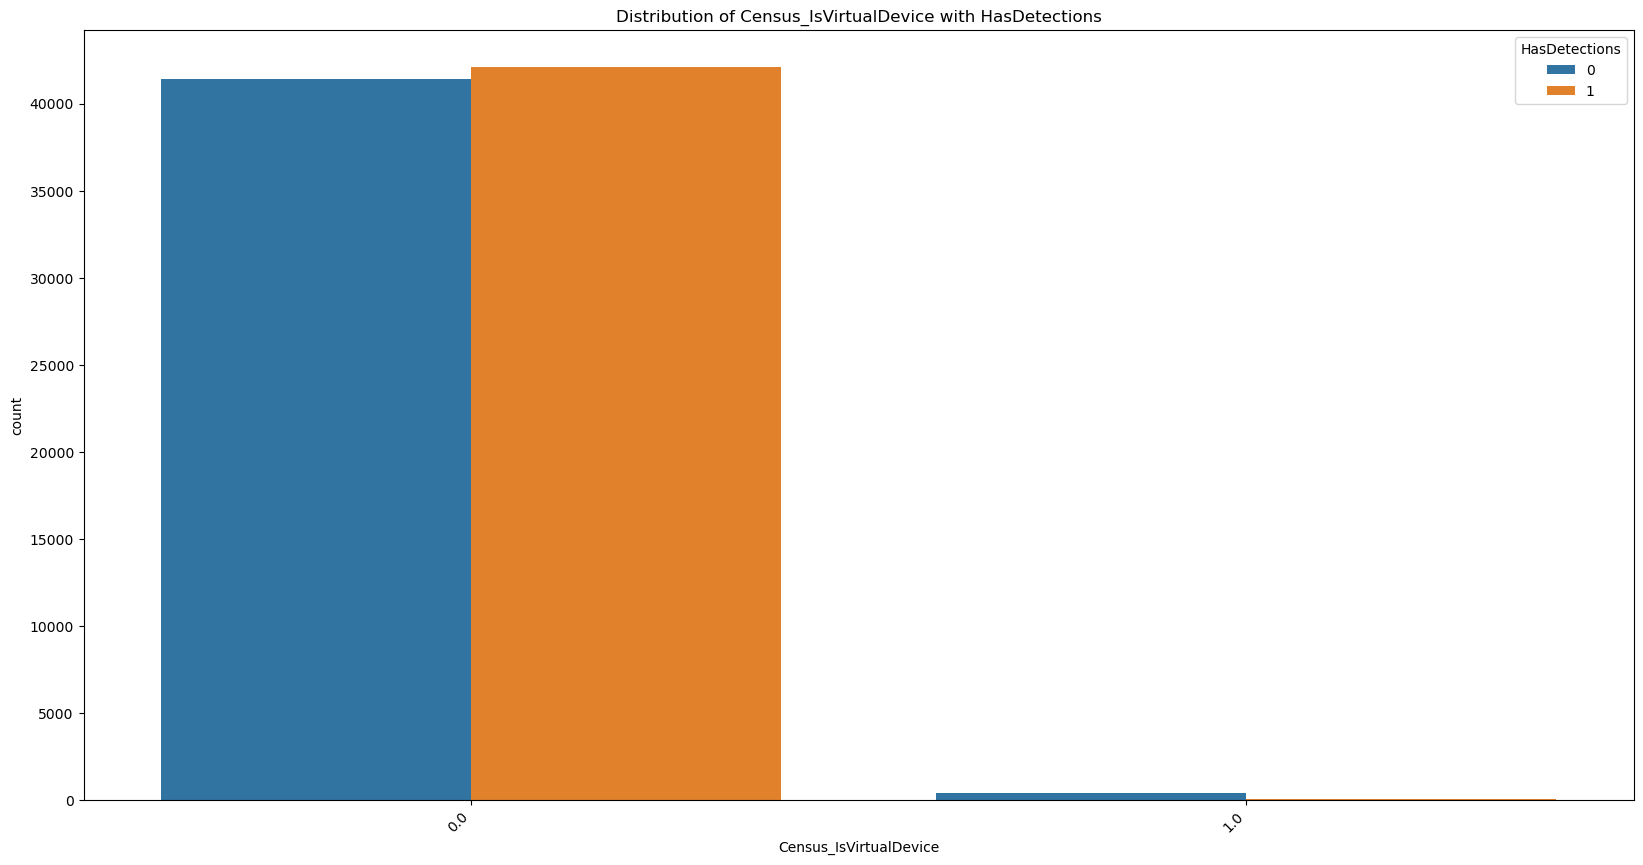

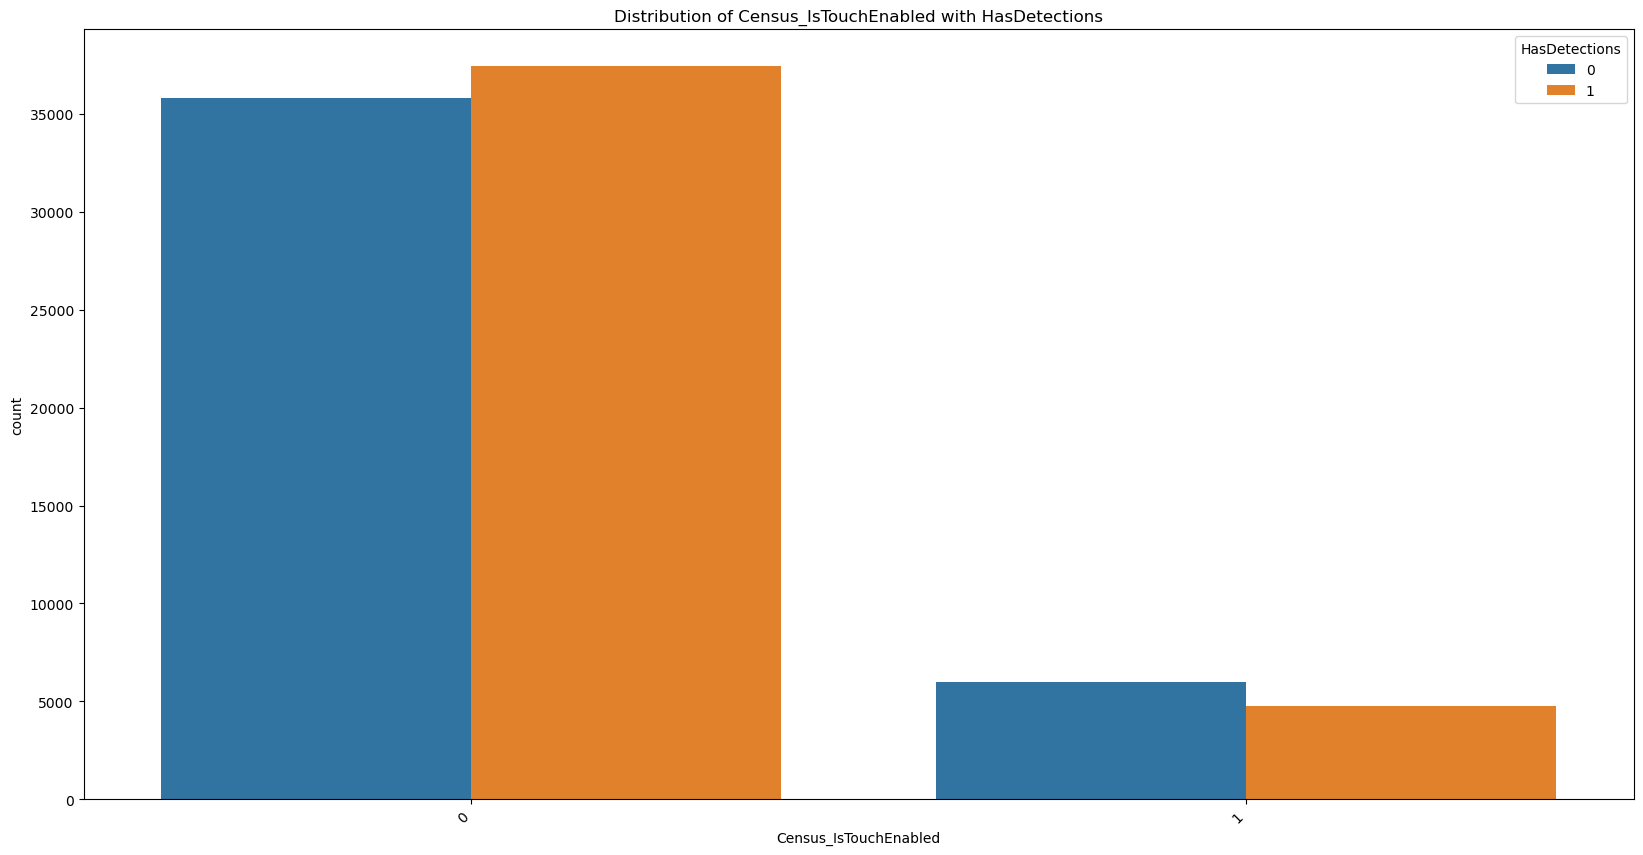

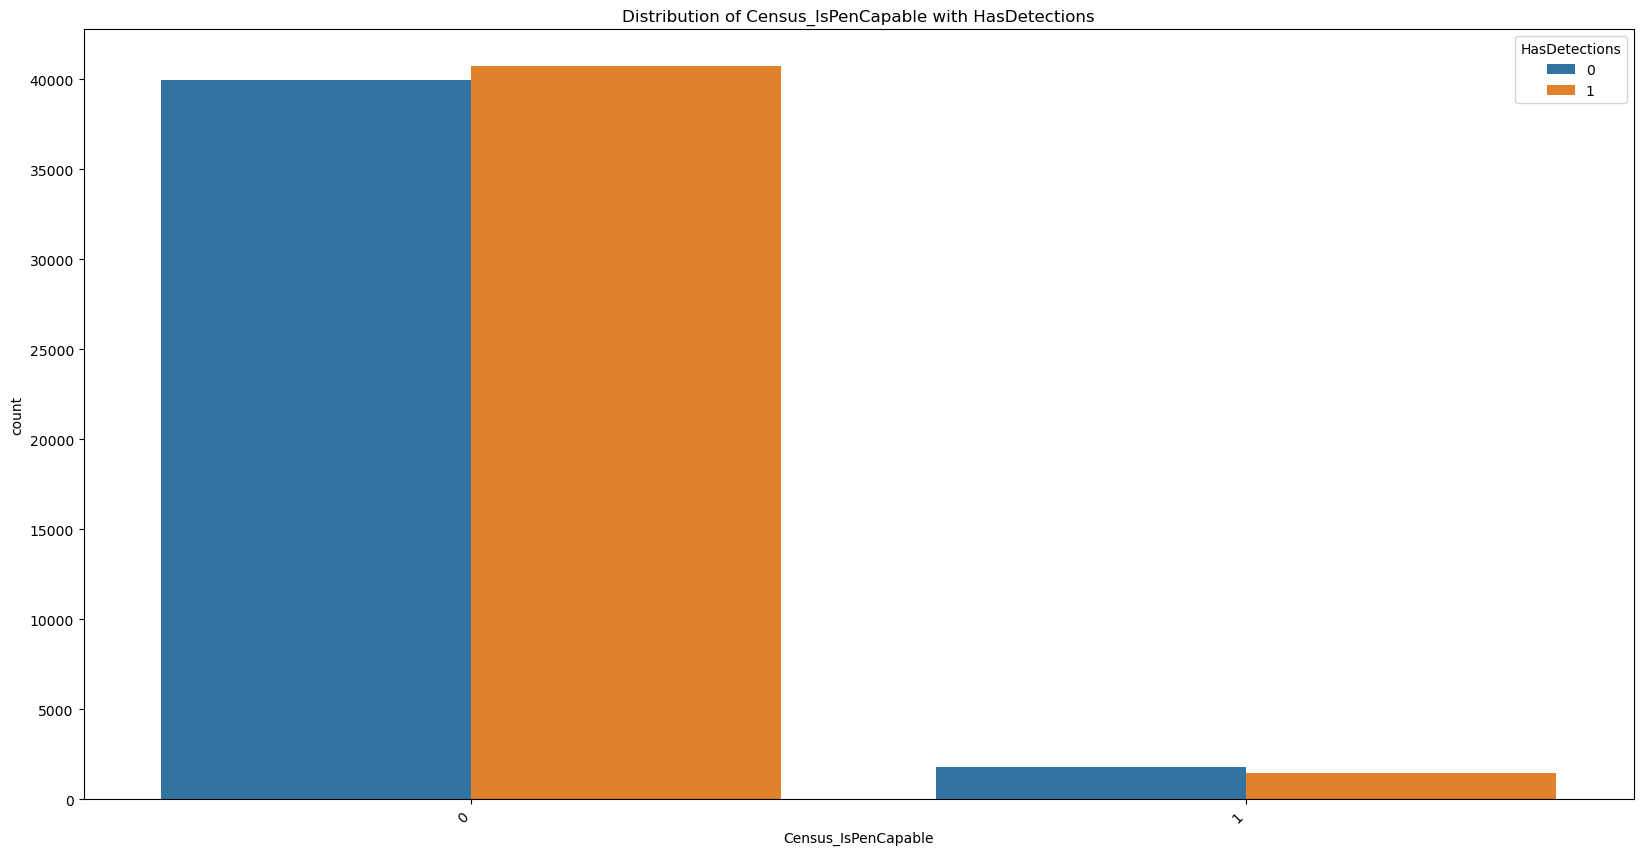

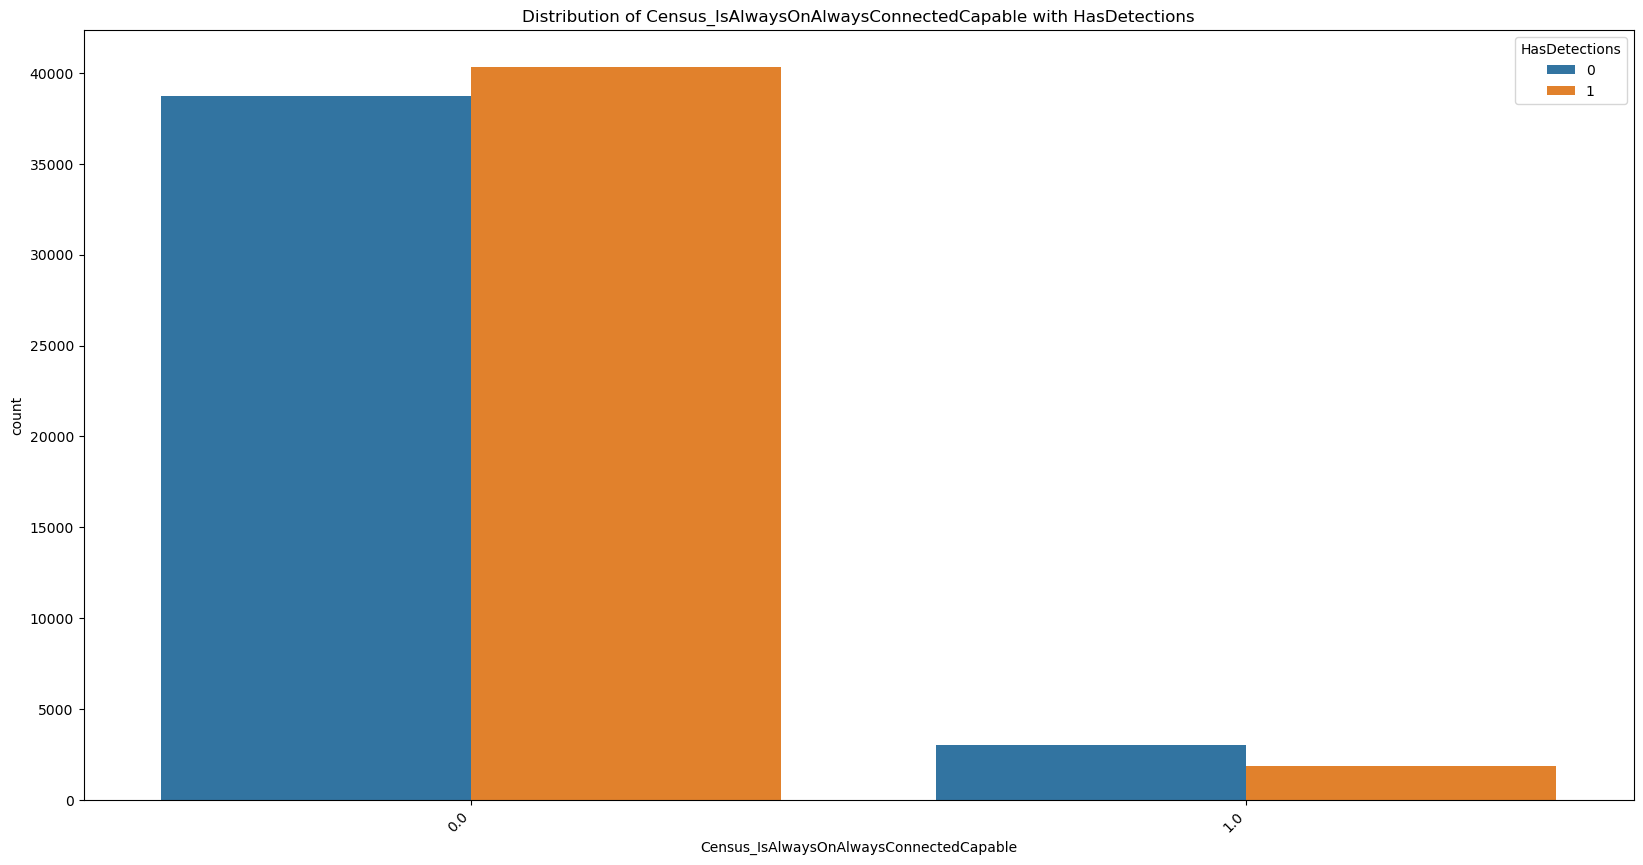

In [13]:
# 1. Distribution of Categorical Variables
for feature in categorical_features:
    plt.figure(figsize=(20, 10))  # Increase the figure size for better readability
    plot = sns.countplot(x=feature, hue=target_variable, data=malware_df)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
    plt.title(f'Distribution of {feature} with {target_variable}')
    plt.show()



Let's try to observe some features in detail and examine the others deeply with different distributions. We can see that-

1. **ProductName**: has a balanced distribution of target variable for win8defender in favor of hasDetections=1, but no significant result for mse, which implies that mse is less likely to be associated with detections.

2. **IsBeta**: plot shows an equal count of HasDetections variables equal to 0 and 1, it means that there is no significant difference in malware detection rates between the two categories of the isBeta feature.

3. **RtpStateBitfield**:
   - Machines with a `RtpStateBitfield` value of 0.0 have a lower detection rate compared to those with a value of 7.0. However, the counts for both `HasDetections` variables are relatively small for the value of 0.0, indicating that this feature might not strongly influence malware detection on its own.

4. **IsSxsPassiveMode**:
   - Machines with an `IsSxsPassiveMode` value of 0 have higher detection rates compared to those with a value of 1. This suggests that the `IsSxsPassiveMode` feature might be correlated with a lower likelihood of malware detection.

5. **HasTpm**:
   - Machines with a `HasTpm` value of 1 have both higher counts and detection rates compared to those with a value of 0. This indicates that the presence of a TPM (Trusted Platform Module) might be associated with a higher likelihood of malware detection.

6. **Platform**:
   - Most of the machines in the dataset are running on Windows 10 (`Platform` value of windows10), followed by a smaller number running on Windows 8 (`Platform` value of windows8). Machines running on Windows 7 do not seem to be present in the dataset. This suggests that the distribution of malware detections varies across different platforms, with Windows 10 having the highest counts.

7. **Processor**:
   - Machines with a `Processor` value of x64 have higher counts and detection rates compared to those with a value of x86. Machines with a `Processor` value of arm64 do not appear to be present in the dataset. This implies that the processor architecture might have some influence on malware detection.

8. **OsVer**:
   - Most of the machines in the dataset are running on version 10.0.0.0 of the operating system (`OsVer`), followed by a smaller number running on version 6.3.0.0. Other versions do not seem to have significant representation in the dataset. This suggests that the distribution of malware detections varies across different operating system versions.

9. **OsBuild**:
   - The distribution of malware detections appears to increase with higher values of `OsBuild`, with the lowest count at 7601 and the highest at 17134. This indicates that newer builds of the operating system might have higher malware detection rates.

10. **OsSuite**:
   - Machines with an `OsSuite` value of 256 have slightly higher counts and detection rates compared to those with a value of 768. Machines with an `OsSuite` value of 784 do not appear to be present in the dataset. This suggests that the suite of operating system features might have some influence on malware detection.

11. **OsPlatformSubRelease**:
    - The distribution indicates that machines with an `OsPlatformSubRelease` value of "rs3" and "rs4" have the highest counts of malware detections (HasDetections=1), with "rs4" slightly leading. The count for "rs1" and "th2" is lower, but still significant, with "rs1" showing a higher incidence of detections than "th2".

12. **SkuEdition**:
    - The `SkuEdition` of the operating system seems to have some correlation with the occurrence of malware detections. 'Pro' and 'Home' editions are predominant, with 'Pro' showing a higher count of detections. The 'Education' edition, despite its lower prevalence, shows a noteworthy detection rate.

13. **IsProtected**:
    - `IsProtected` is a significant feature in terms of malware detection. Machines with active protection seem to have a balanced distribution of malware detection, which highlights the importance of having such protective measures in place.

14. **IeVerIdentifier**:
    - The distribution of `IeVerIdentifier` across the dataset indicates a few versions of Internet Explorer that are most prevalent. The correlation between Internet Explorer versions and malware detections does not show a strong pattern, which may suggest that the version of Internet Explorer alone is not a strong predictor of malware detection.
    
15. **Firewall**:
    - There is a substantial majority of machines with the firewall enabled. Among these, there is a nearly equal count of machines with malware detections (`HasDetections`=1) and without (`HasDetections`=0), indicating that while firewalls are widely used, they are not fully preventative against malware.

16. **UacLuaenable**:
    - For machines with `UacLuaenable` set to 1, indicating UAC is enabled, there is a significant count with a fairly even distribution between machines that have malware detections and those that do not. A very small number of machines have `UacLuaenable` set to 0 or 2, which suggests that UAC is disabled or possibly in a non-standard configuration. Among these, the counts are too small to determine a clear trend, but it appears that machines with UAC disabled (`UacLuaenable`=0) have malware detections. The `UacLuaenable` value of 48 seems to be an outlier or an error in the data, as it does not correspond to standard settings for UAC and has no associated malware detections.

17. **Census_MDC2FormFactor**:
    - The `Census_MDC2FormFactor` indicates that laptops ('Notebook') and 'Desktops' are the most commonly used device types in this dataset, with notebooks experiencing a higher incidence of malware detections.

18. **Census_PrimaryDiskTypeName**:
    - 'HDD' (Hard Disk Drives) have the highest total count and also the highest count of machines with malware detections. 'SSD' (Solid State Drives) show a slightly lower total count compared to HDDs, but a proportionally similar count of machines with and without malware detections. The 'UNKNOWN' category has a significantly lower total count, with slightly more machines without detections than with. The 'Unspecified' category has the least total count and a higher number of machines with detections compared to those without.

19. **Census_HasOpticalDiskDrive**:
    - The vast majority of machines do not have an optical disk drive (`Census_HasOpticalDiskDrive`=0), and within this group, there is a close distribution between machines with and without malware detections. There is a much smaller count of machines that do have an optical disk drive (`Census_HasOpticalDiskDrive`=1), and within this group, the number of machines without malware detections is somewhat larger than those with detections.

20. **Census_ChassisTypeName**:
    - The `Census_ChassisTypeName` indicates that laptops and notebooks are prevalent in the dataset and experience a considerable number of malware detections, reinforcing the importance of robust security measures on these types of devices.

21. **Census_PowerPlatformRoleName**:
    - The `Census_PowerPlatformRoleName` category shows that 'Mobile' and 'Desktop' devices are more likely to encounter malware compared to other types of devices, possibly due to their widespread use and exposure to riskier environments.
    
22. **Census_OSArchitecture**:
    - The `Census_OSArchitecture` data suggests that the architecture type of an operating system might not be a decisive factor in the likelihood of malware detection on its own.

23. **Census_OSBranch**:
    - The `Census_OSBranch` data indicates that certain OS branches are more commonly represented in the dataset and that malware detections are correspondingly high for these branches.

24. **Census_OSBuildNumber**:
    - The `Census_OSBuildNumber` indicates that newer or widely-used OS builds encounter a notable amount of malware detections. This could suggest that regardless of the OS build, devices may still be vulnerable to malware attacks, underscoring the importance of continuous security updates and practices.

25. **Census_OSEdition**:
    - The 'Professional', 'Core', and 'CoreSingleLanguage' editions are the most utilized, likely reflecting their popularity in consumer and business environments. These editions also experience a substantial number of malware detections. The pattern of detections in 'Education' edition might indicate specific vulnerabilities or usage patterns that make these systems more susceptible to malware.
    
26. **Census_OSSkuName**:
    - The `Census_OSSkuName` data implies that while certain OS SKUs are more commonly used and thus exhibit a higher number of malware detections, the type of OS SKU alone is not necessarily a strong indicator of malware presence.

27. **Census_OSInstallTypeName**:
    - The `Census_OSInstallTypeName` indicates that the type of OS installation could be related to the likelihood of encountering malware. Installation types that are more routine, such as updates and upgrades, show more detections, potentially due to a larger number of these systems being in use.
    
28. **Census_OSWUAutoUpdateOptionsName**:
    - The `Census_OSWUAutoUpdateOptionsName` data implies that while most users keep their devices on automatic updates, this does not fully protect against malware detections.

29. **Census_IsPortableOperatingSystem**:
    - The `Census_IsPortableOperatingSystem` data indicates that the prevalence of malware detections is primarily associated with non-portable operating systems, likely due to their dominance in the market.

30. **Census_GenuineStateName**:
    - The `Census_GenuineStateName` data indicates that having a genuine operating system does not necessarily correlate with fewer malware detections. On the contrary, genuine systems appear to encounter malware more often, perhaps due to being more likely to receive all types of software updates, including those with vulnerabilities that can be exploited.
    
31. **Census_ActivationChannel**:
    - The `Census_ActivationChannel` data implies that the method of operating system activation may have some correlation with malware detections, but the relationship is not strongly evident.
    
32. **Census_FlightRing**:
    - The `Census_FlightRing` data points to a distribution where the standard 'Retail' consumer systems are the most common and have a relatively balanced level of malware risk.

33. **Census_IsSecureBootEnabled**:
    - Secure Boot is a security standard designed to ensure that a device boots using only software that is trusted by the Original Equipment Manufacturer (OEM). In theory, it should help in protecting against malware that targets the boot process. Both the Secure Boot enabled and disabled groups show substantial counts of malware detections, which underscores the complexity of cybersecurity and the need for multiple layers of security.

34. **Census_IsVirtualDevice**:
    - A majority of devices in the dataset are identified as non-virtual `0`, which is expected in a typical device population. The number of devices without malware detections (`HasDetections`=0) is roughly equivalent to the number with detections (`HasDetections`=1) in the non-virtual category, showing a balanced distribution.

35. **Census_IsTouchEnabled**:
    - Devices with touch capabilities `1` are less prevalent in this dataset, which is reflected in the lower counts of detections and non-detections. The proportion of detections to non-detections in touch-enabled devices seems comparable to that of non-touch devices, suggesting a similar risk profile for malware detections.

36. **Census_IsPenCapable**:
    - Pen-capable devices `1` represent a smaller fraction of the dataset. This reflects the niche market for devices like tablets and convertibles with stylus support. Similar to the non-pen-capable devices, the ratio of malware detections to non-detections in pen-capable devices does not show a significant variance, which implies that pen capability is not a strong indicator of malware presence.

37. **Census_IsAlwaysOnAlwaysConnectedCapable**:
    - The devices that are AOAC capable `1` constitute a smaller segment of the dataset, which is expected since AOAC is a relatively new feature and not all devices support it. The distribution of malware detections to non-detections for AOAC capable devices is proportional to that of non-AOAC capable devices, suggesting that having AOAC capability does not correlate strongly with the presence of detections.
    
In further steps,

1. Let's order the values of the version features EngineVersion, AppVersion, AvgSigVersion, Census_OSVersion to observe trends, if any, in further plots.

2. Examine the ordred bar charts of features OsBuildLab, Census_OSBuildRevision with sampled unique values to improve readability.


**Now, let's observe the visualisations of the version categorical variables EngineVersion and AppVersion by ordering them and looking into their point plot distributions.**

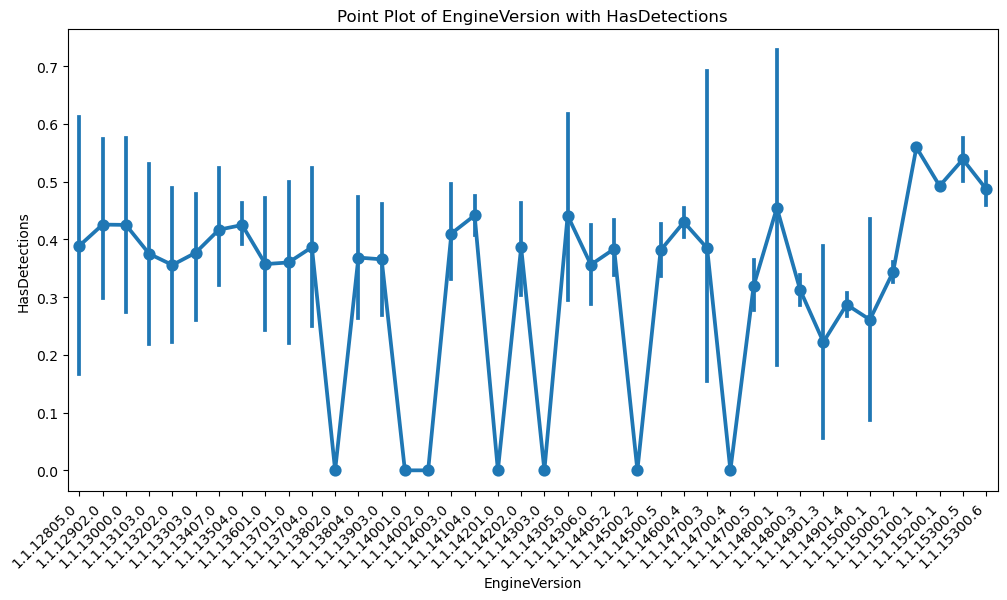

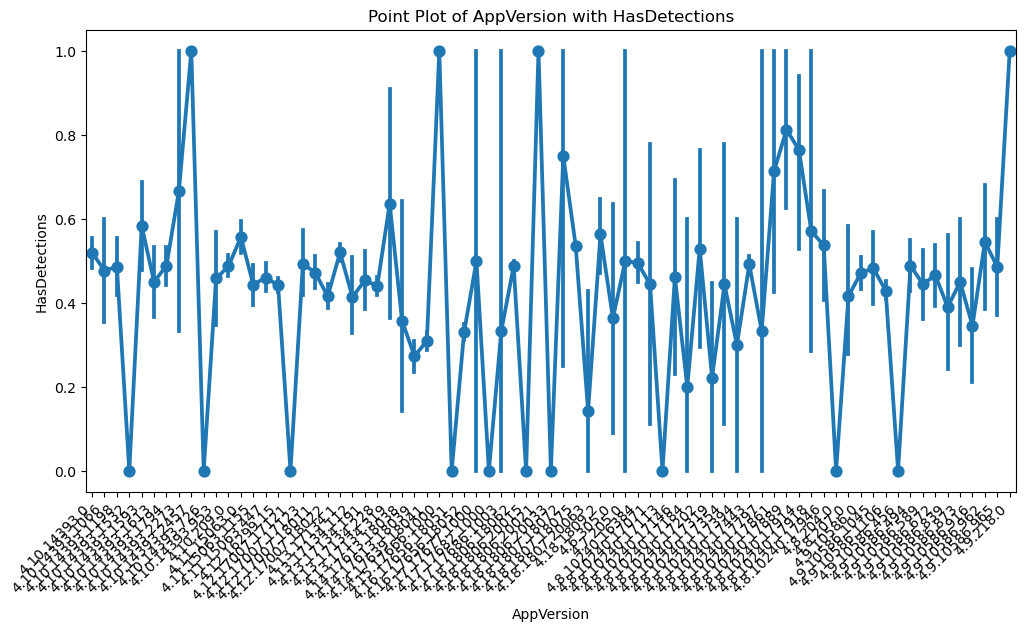

In [14]:
# Order the values for the specified categorical variables
selected_features = ['EngineVersion', 'AppVersion']

# Set the order of values on the x-axis
order_dict = {}

for feature in selected_features:
    ordered_values = malware_df[feature].unique()
    ordered_values.sort()  # Sort the unique values in ascending order
    order_dict[feature] = ordered_values

# Plot the point plot distribution
for feature in selected_features:
    plt.figure(figsize=(12, 6))
    plot = sns.pointplot(x=feature, y=target_variable, data=malware_df, order=order_dict[feature])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
    plt.title(f'Point Plot of {feature} with {target_variable}')
    plt.show()

1. EngineVersion:

Higher Average HasDetections for Certain Versions (1.1.12805.0 to 1.1.13704.0):
Versions within the range 1.1.12805.0 to 1.1.13704.0 tend to have higher average 'HasDetections'.
Among these versions, 1.1.13504.0 stands out with the highest average 'HasDetections'.
This suggests that there might be something specific about these versions that correlates with a higher likelihood of detections.

Lower Average HasDetections for Other Versions (1.1.13802.0, 1.1.14001.0, etc.):
Versions such as 1.1.13802.0, 1.1.14001.0, 1.1.140012.0, etc., exhibit lower average 'HasDetections' as they are around or below the baseline.
This indicates that these versions might have different characteristics or updates that result in a lower likelihood of detections.

Recent Versions (1.1.15300.5 and 1.1.15300.6):
The last two versions, 1.1.15300.5 and 1.1.15300.6, exhibit higher average 'HasDetections', with 1.1.15300.6 being the highest among them.
This may imply that recent updates or changes in these versions have resulted in a higher likelihood of detections compared to previous versions.

2. AppVersion

Higher Average HasDetections for Certain Versions:
Highest average 'HasDetections' are observed for the versions among 4.10.x, 2.15.x, 4.18.x, and 4.9.x.
This indicates that specific versions within these ranges are associated with a higher likelihood of detections.

Lower Average HasDetections for Certain Versions:
Lower points are observed for several versions within 4.18.x, 4.12.x, and 4.8.x.
This suggests that these specific versions may have characteristics or updates resulting in a lower likelihood of detections compared to others.

Higher Uncertainty in Certain Ranges:
Versions in 4.17.x and 4.8.x show higher uncertainty due to wider confidence intervals.
This increased uncertainty may imply variability or inconsistency in the data within these version ranges, potentially influenced by factors not captured in the analysis.

**We could see from the earlier complete distribution that AvSigVersion and Census_OSVersion displayed an unreadable plot due to the exceedingly large number of values, hence we try to take 50 unique values and order the versions to improve readability and gain insights into their visualizations with an ordered bar chart.**

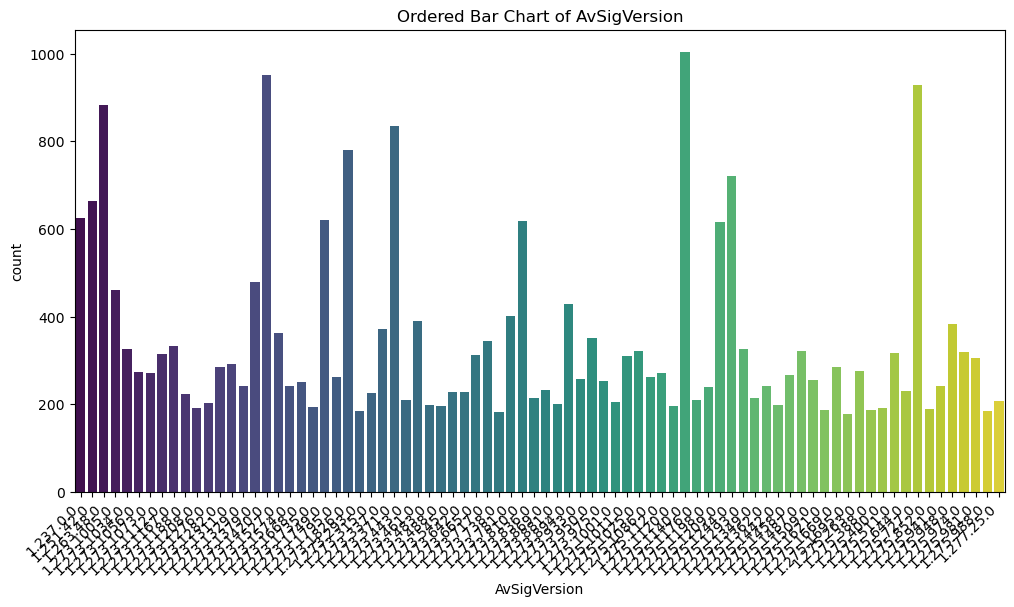

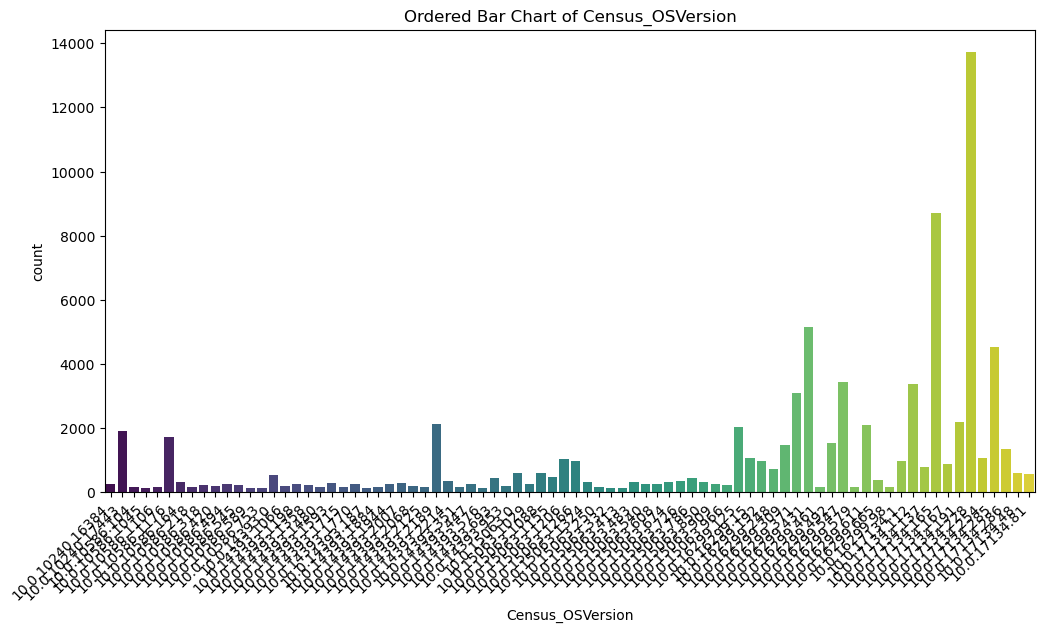

In [15]:
# Specify variables for ordered violin plot
selected_features = ['AvSigVersion', 'Census_OSVersion']

# Create ordered bar chart for each variable
order_dict = {}

for feature in selected_features:
    unique_values = malware_df[feature].value_counts().index[:80]  # Limit to 50 unique values
    ordered_values = sorted(unique_values)  # Sort the unique values in ascending order
    order_dict[feature] = ordered_values

# Plot the bar chart for each feature
for feature in selected_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, data=malware_df, order=order_dict[feature], palette='viridis')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.title(f'Ordered Bar Chart of {feature}')
    plt.show()


AvgSigVersion- There seems to be no significant trend in this distribution.

Census_Os_Version: The count appears to generally be increasing as the Census_OSVersion increases. The highest count for HasDetections from this plot seems to be for the Census_OSVersion 10.0.17134.228

**Now, let's try to look at the OsBuildLab and Census_OSBuildRevision featurs by sampling 75 unique values for better readability and using a stacked chart to understand their distributions**

<Figure size 1600x800 with 0 Axes>

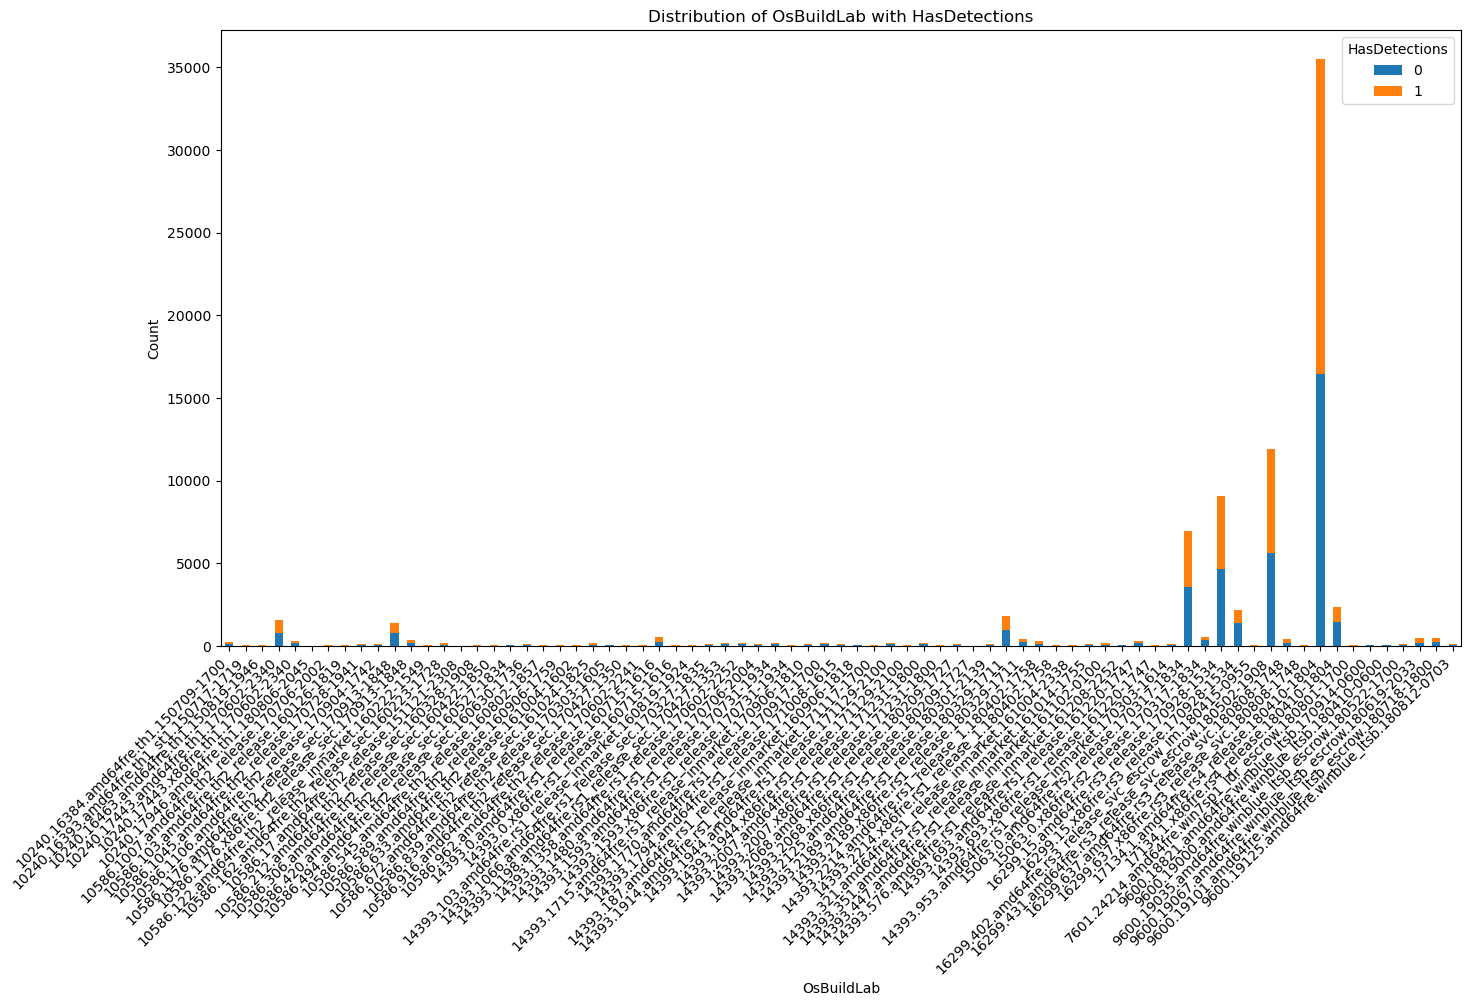

<Figure size 1600x800 with 0 Axes>

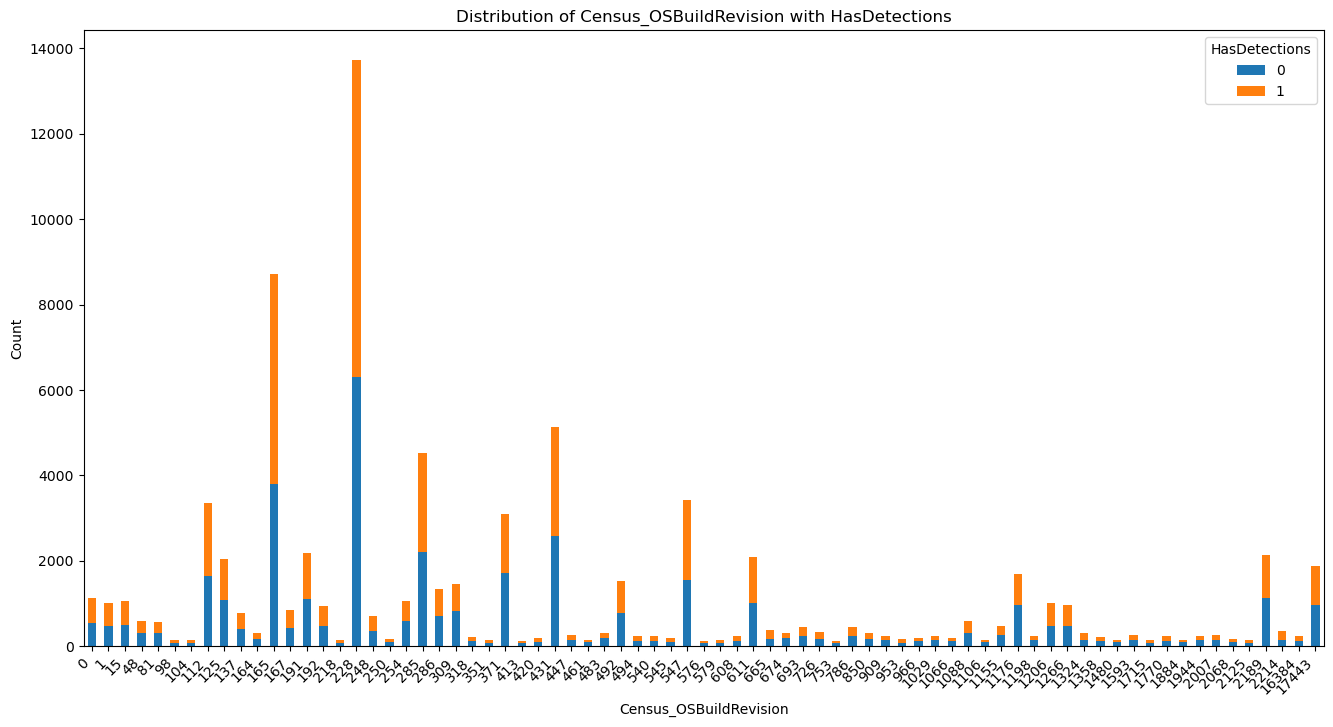

In [16]:
variables_to_adjust = ['OsBuildLab', 'Census_OSBuildRevision']

# Iterate over each feature
for feature in variables_to_adjust:
    plt.figure(figsize=(16, 8))  # Set the figure size
    unique_values_limit = 75  # Limit the number of unique values to display
    top_values = malware_df[feature].value_counts().nlargest(unique_values_limit).index  # Get top values

    # Filter the DataFrame to include only top values
    filtered_df = malware_df[malware_df[feature].isin(top_values)]

    # Create a cross-tabulation of the feature and the target variable
    crosstab = pd.crosstab(filtered_df[feature], filtered_df[target_variable])

    # Plot a stacked bar chart
    crosstab.plot(kind='bar', stacked=True, figsize=(16, 8))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set the title and axis labels
    plt.title(f'Distribution of {feature} with {target_variable}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    # Show the plot
    plt.legend(title=target_variable)
    plt.show()

OsBuildLab shows a loosely increasing distribution, with the highest count in 17134.1.amd64fre.rs4.release.180410-1804. This suggests that this version might be worth looking into during modelling.

Census_OSBuildRevision shows no significant trend but does show a high count for the target variable HasDetections at value=228.

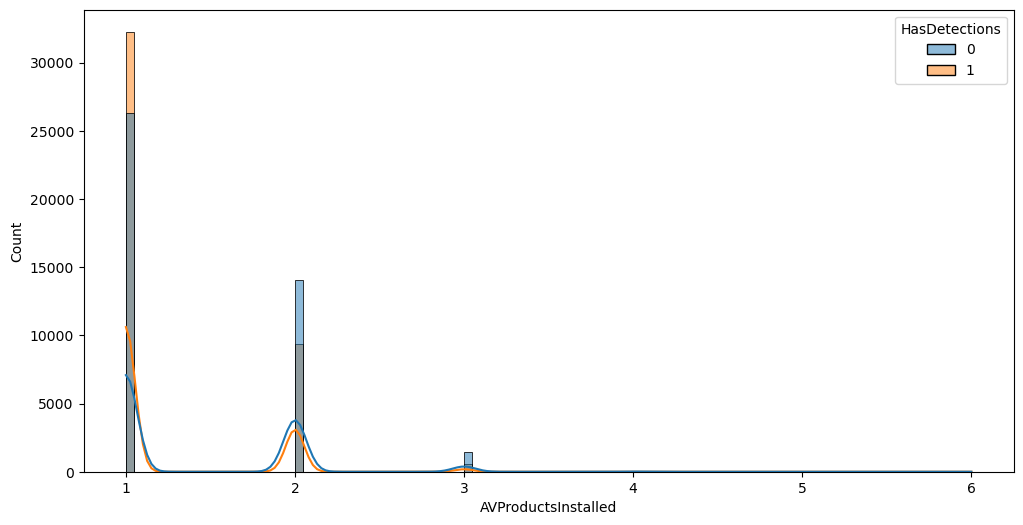

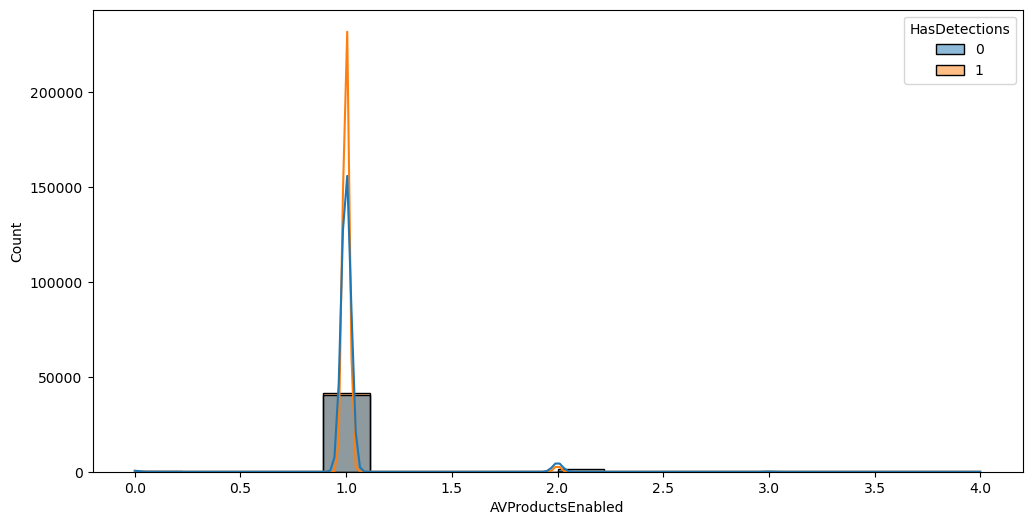

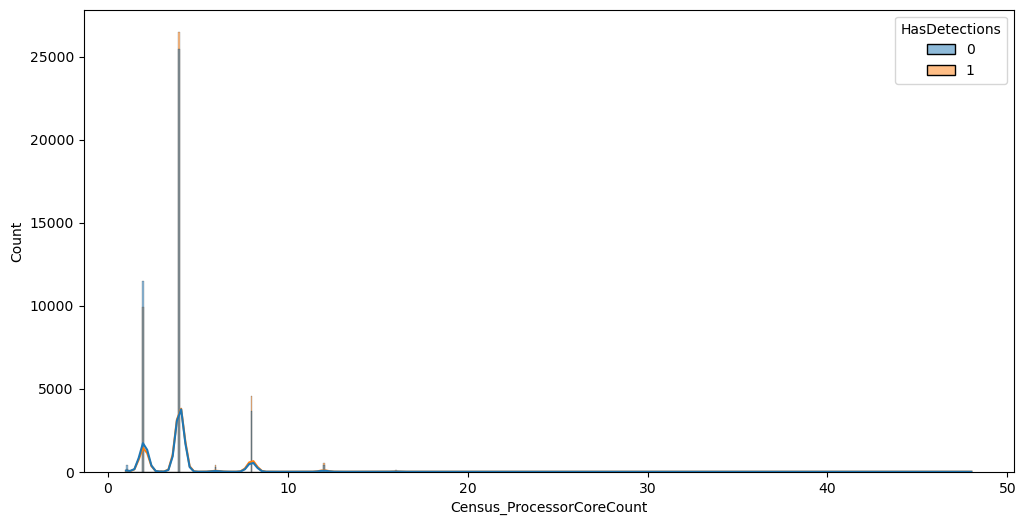

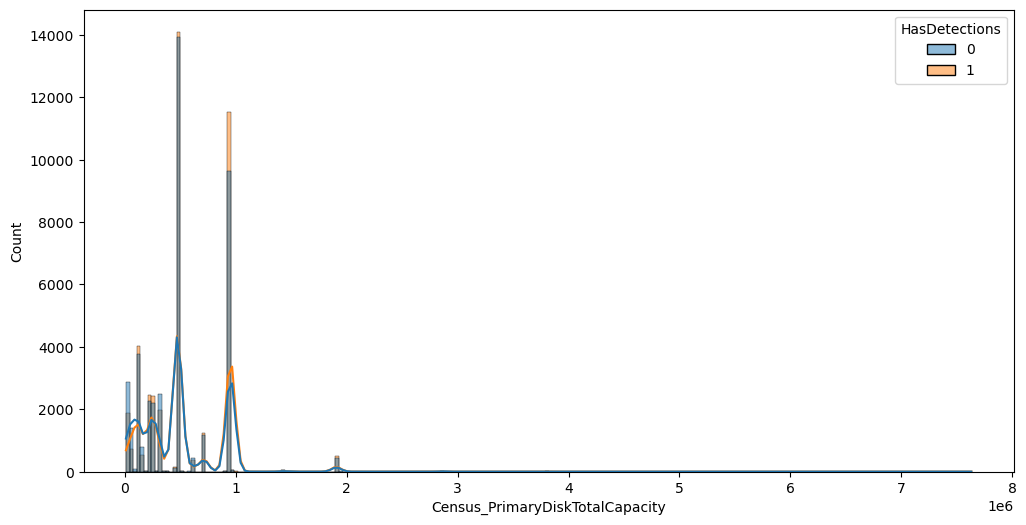

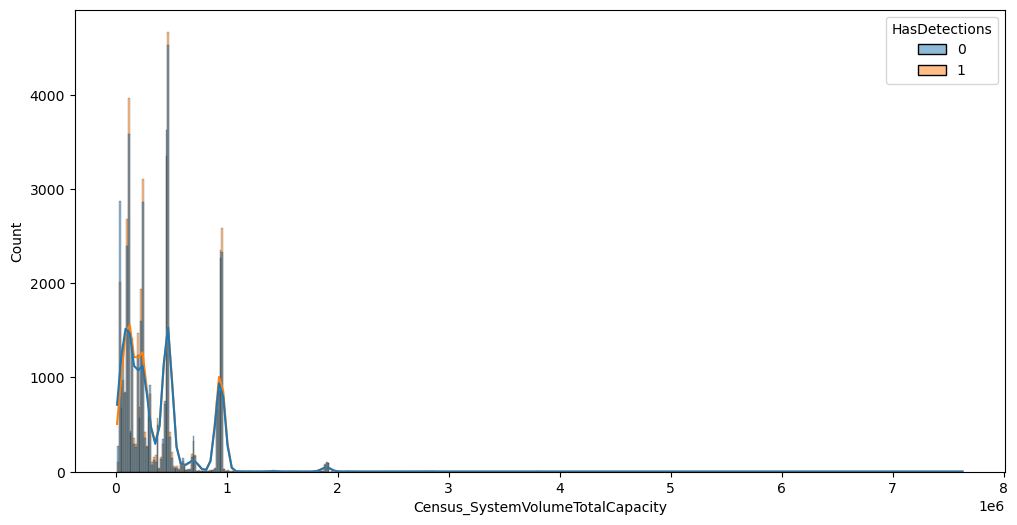

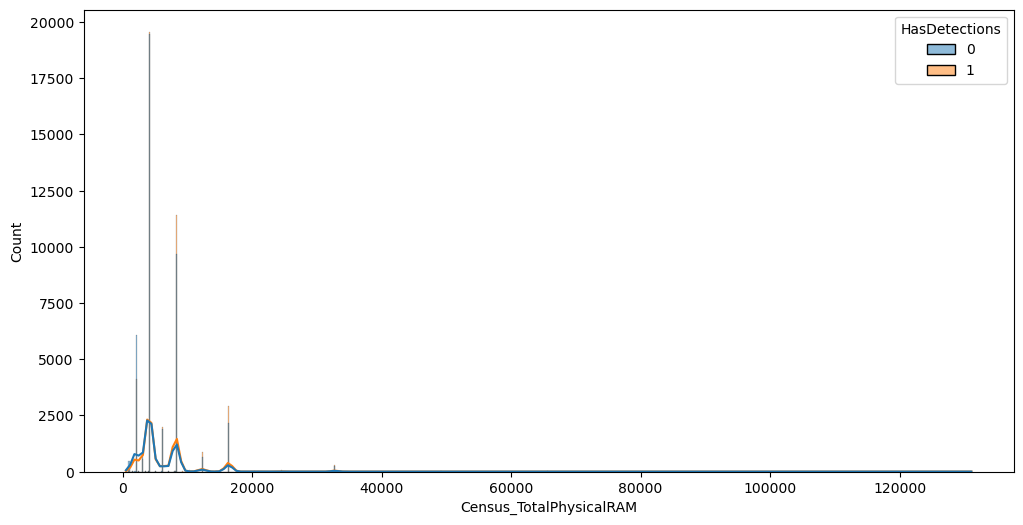

In [17]:
# 2. Distribution of Numerical Variables
for feature in numerical_features:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=malware_df, x=feature, hue=target_variable, kde=True)
    plt.show()




Distribution analysis of **AVProductsInstalled**:

For machines with only one antivirus product installed, there is a significant count of both malware detections and non-detections, with non-detections slightly higher. Machines with two antivirus products installed show a higher count of malware detections compared to non-detections, suggesting that the presence of two antivirus products might be correlated with an increased rate of malware detection, possibly due to better detection capabilities or because machines more at risk are likely to have more antivirus products installed.

Distribution analysis of **AVProductsEnabled**:

The orange line represents machines with detections (1), and the blue line represents machines without detections (0).
The highest peaks for both detections and non-detections occur at the value of 1.0 for AVProductsEnabled, suggesting that most machines operate with one antivirus product regardless of whether malware is detected.

Distribution analysis of **Census_ProcessorCoreCount**:

The majority of machines in this dataset use a 4-core processor. There is no clear indication that having more or fewer cores is associated with a higher likelihood of malware detection. For a more robust analysis, other factors such as the type of activity performed on the machines, operating system vulnerabilities, and user behavior would also need to be considered.

Distribution analysis of **Census_PrimaryDiskTotalCapacity**:

The majority of machines have a primary disk capacity under 500 GB. Malware detection appears roughly proportional across different disk capacities. Larger disk capacities are less common in the dataset and show a lower absolute number of malware detections. However, without context on the relative proportion of disk sizes, it's unclear if larger capacities are correlated with lower detection rates.

Distribution analysis of **Census_SystemVolumeTotalCapacity**:

There is a considerable frequency of systems with a system volume capacity in the range of 0-250 GB, which is a common size for an operating system partition. Beyond this range, the counts for both malware detections and non-detections decrease, which might suggest either improved security measures on systems with larger volumes or simply that these systems are less numerous in the sample.
No significant peak or trend indicates a specific system volume capacity where malware detection is notably higher or lower, which might suggest that system volume capacity is not a major factor in malware detection.

Distribution analysis of **Census_TotalPhysicalRAM**:

The most common amount of RAM where detections are noted is at the lower end of the RAM scale, which is likely around 4,096 MB (4 GB) or 8,192 MB (8 GB), typical for many personal computers. The distribution seems to decrease exponentially with increasing RAM, showing fewer systems with higher RAM capacities. It's noteworthy that the occurrence of malware detections doesn't seem to significantly increase or decrease with higher RAM amounts, suggesting that the likelihood of malware detection may not be solely dependent on the system's RAM size.


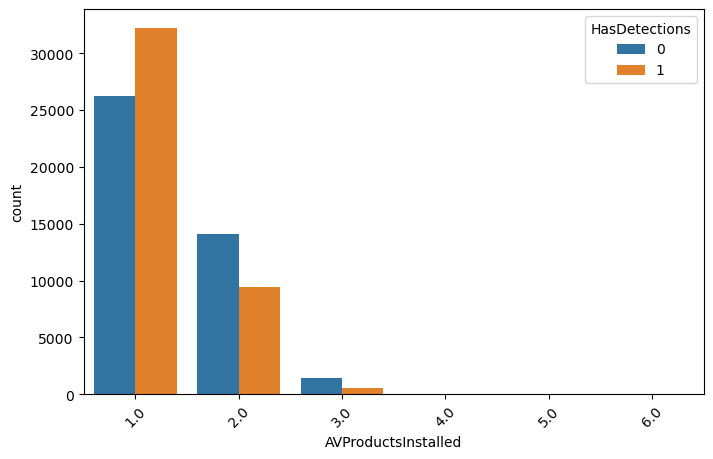

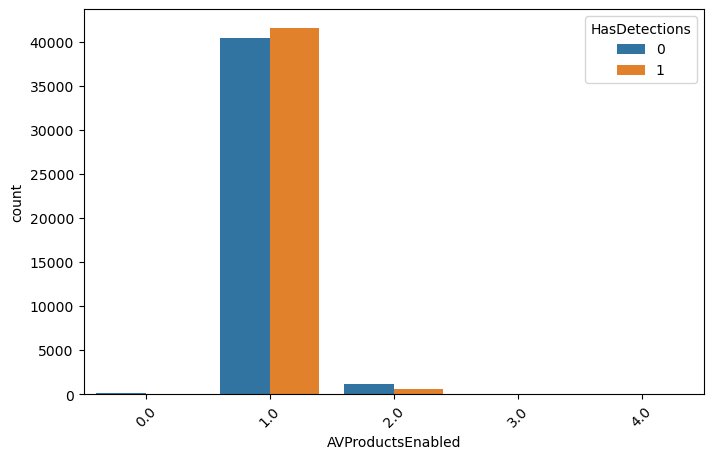

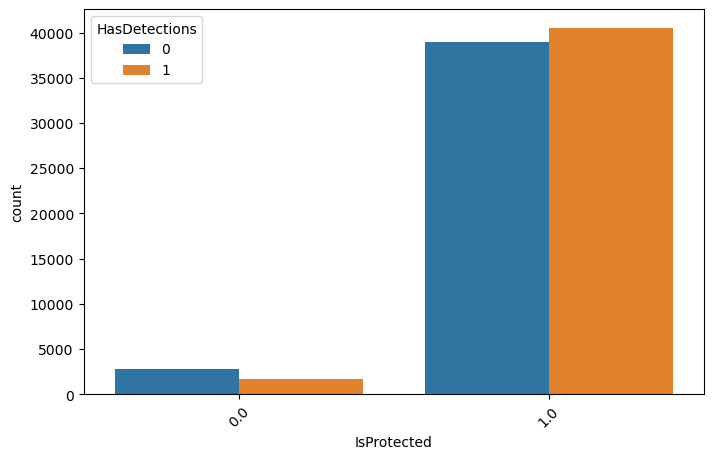

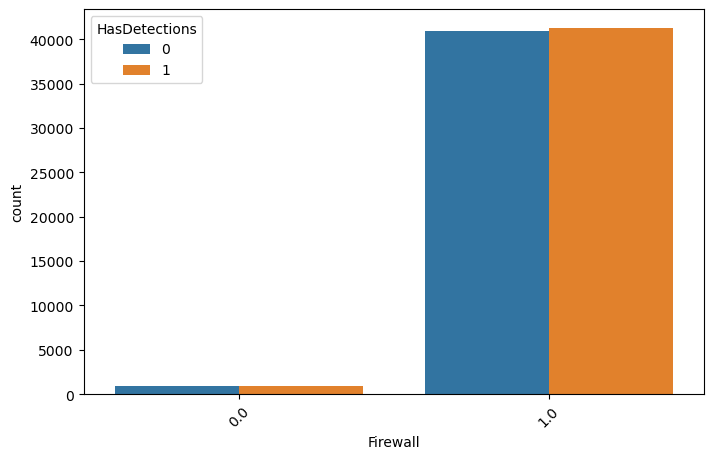

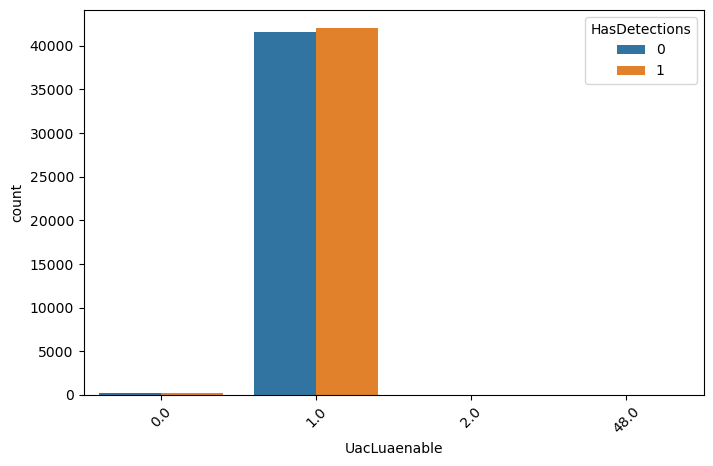

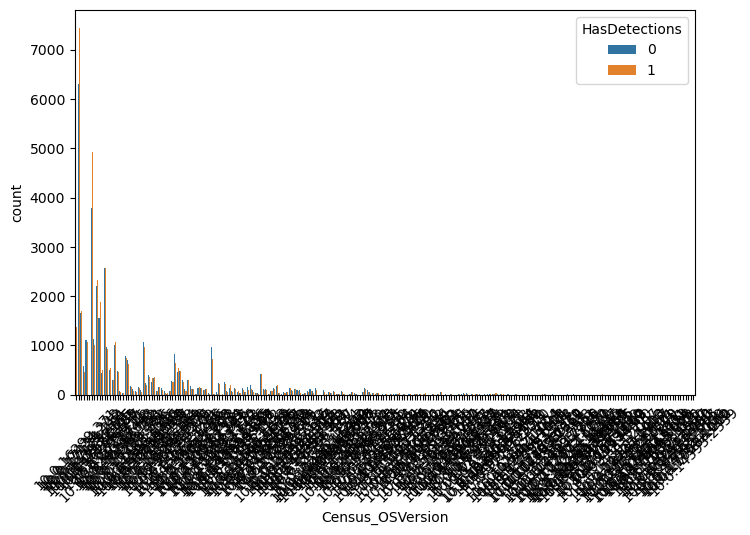

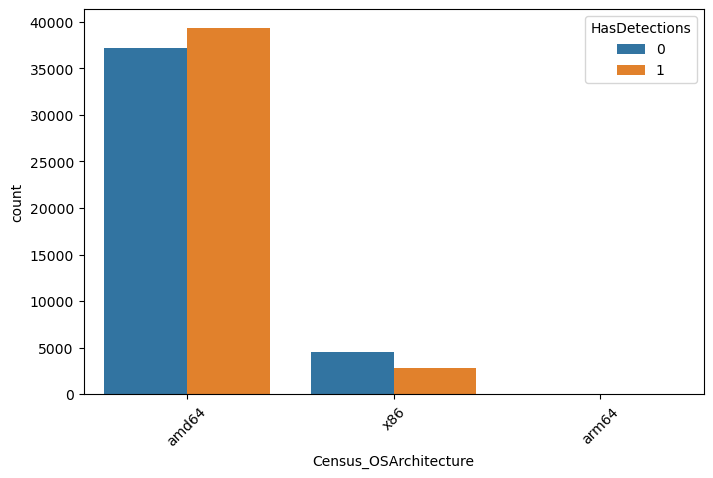

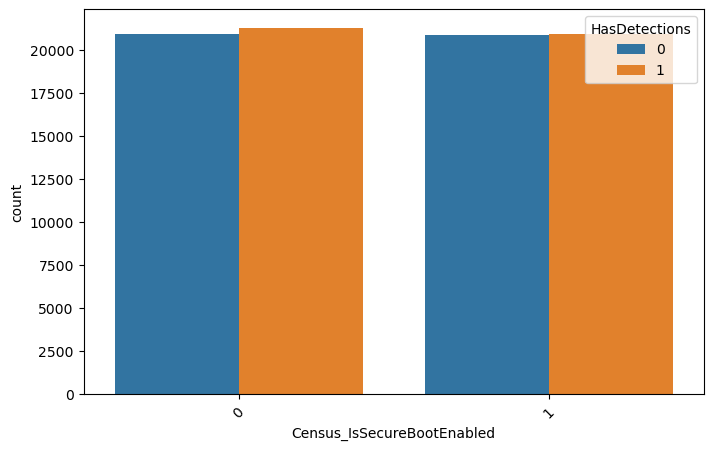

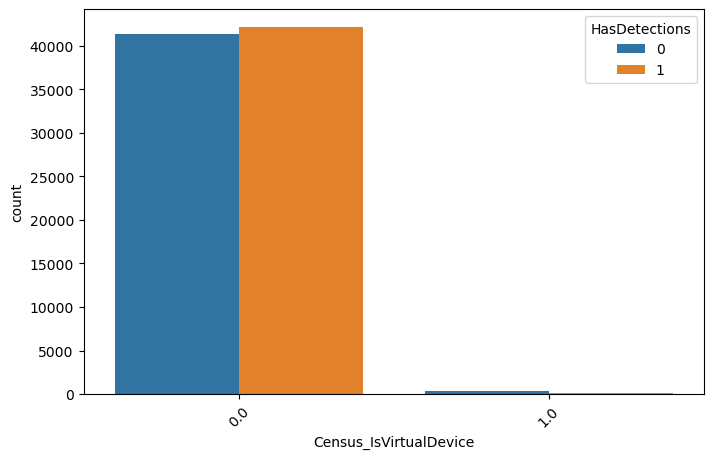

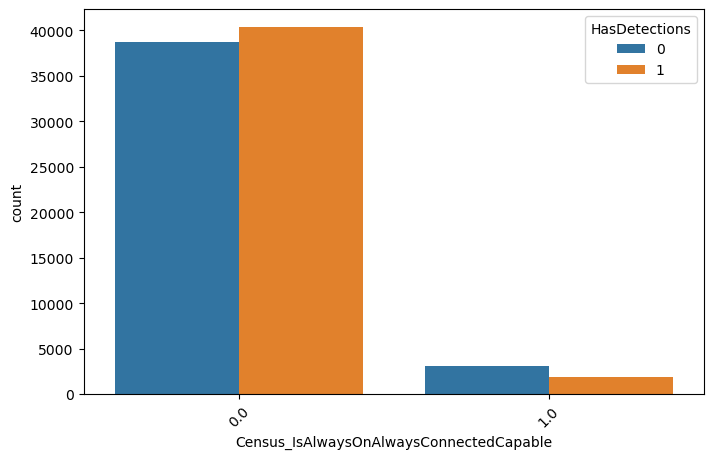

In [18]:

# 3. Correlation of Highly Important Features with the Target
highly_important_features = [
    'AVProductsInstalled', 'AVProductsEnabled', 'IsProtected', 'Firewall', 'UacLuaenable',
    'Census_OSVersion', 'Census_OSArchitecture', 'Census_IsSecureBootEnabled',
    'Census_IsVirtualDevice', 'Census_IsAlwaysOnAlwaysConnectedCapable'
]

for feature in highly_important_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, hue=target_variable, data=malware_df)
    plt.xticks(rotation=45)
    plt.show()



Insights on highly important feature variations with target variable-HasDetections

Insights on **AVProductsInstalled** with target variable-HasDetections:

Most users seem to rely on a single antivirus product. Having more than one antivirus product installed does not necessarily correlate with a higher detection rate of malware. There is a possibility of decreased compatibility or increased conflicts with more antivirus products installed, which could impact detection rates.

Insights on **AVProductsEnabled** with target variable-HasDetections:

Having no AV products enabled is a high risk, as indicated by the high number of detections. Most users seem to use just one AV product, which could imply a reliance on that product’s effectiveness or possibly limitations (e.g., licensing) on the number of products that can be enabled. Systems with 2 or more AV products enabled are significantly less common, which might suggest either increased difficulty in managing multiple AV products or that additional products do not provide perceived added value.

Insights on **IsProtected** with target variable-HasDetections:

The fact that protected systems have a high number of detections could indicate that while protection is enabled, it might not be fully effective, or the systems are encountering a large volume of threats. The presence of detections in unprotected systems is expected, emphasizing the importance of having some form of protection. There is a smaller gap between the number of detections in protected versus unprotected systems than might be expected, which could suggest that the quality or the configuration of the protection is as important as its presence.

Insights on **Firewall** with target variable-HasDetections:

Having a firewall does not guarantee the absence of threats, as shown by the substantial number of detections in systems with a firewall. This might suggest that firewalls are challenged by sophisticated threats or that they need to be properly configured and updated.
The data shows that systems without a firewall have a lower incidence of detections, but this could be misleading as these systems are less in number. It's also possible that these systems could be less exposed or used in a manner that presents fewer risks.
Systems without firewalls being compromised indicates the necessity of firewalls in defense strategies.

Insights on **UacLuaenable** with target variable-HasDetections:

The effectiveness of UAC in preventing threats is not clear-cut from this data alone. While a configuration value of 1 is common, it does not seem to drastically reduce the number of detections. The infrequency of categories 0 and 2 suggests they are less commonly used or represent specific system configurations. Their small sample size makes it difficult to draw firm conclusions about their security impact. The presence of the 48 category may require data cleansing or further investigation to understand its meaning and impact.

Insights on **Census_OSVersion** with target variable-HasDetections:

No single OS version stands out as particularly more or less secure based solely on this chart, as most versions show detections.
There are some OS versions with particularly high counts of devices, which could be standard or very common versions.

Insights on **Census_OSArchitecture** with target variable-HasDetections:

The 64-bit architecture (amd64) is more prevalent among the samples, which might reflect the modern standard in computing compared to the older 32-bit (x86). There does not appear to be a stark contrast in the security between the two architectures based on this data alone. Both show instances of detections, although amd64 shows more due to its higher prevalence.

Insights on **Census_IsSecureBootEnabled** with target variable-HasDetections:

Enabling Secure Boot does not appear to be a definitive factor in avoiding detections since there are substantial instances of detections in both cases. However, it can be observed that systems with Secure Boot enabled (1) have higher counts of both detections and non-detections, which might suggest a higher prevalence of this setting in the dataset.

Insights on **Census_IsVirtualDevice** with target variable-HasDetections:

The majority of devices in the dataset appear to be non-virtual, as indicated by the higher counts for 0. There is a small prevalence of detections over non-detections for virtual devices, which could suggest that virtual devices might be slightly more susceptible to detections, or they are environments where more rigorous detection processes are in place. The close counts of detections and non-detections for non-virtual devices suggest that whether a device is virtual or not is not a strong predictor of detections on its own.

Insights on **Census_IsAlwaysOnAlwaysConnectedCapable** with target variable-HasDetections:

Devices without the always-on and always-connected capability are far more common in this dataset. Interestingly, for devices that do have this capability, it seems there are fewer detections compared to those that don't have it, which could imply that such devices might be less prone to whatever "detections" signify or may be better protected. This feature alone does not seem to be a strong predictor for detections since the distributions of detections and non-detections are quite similar for devices without this capability.

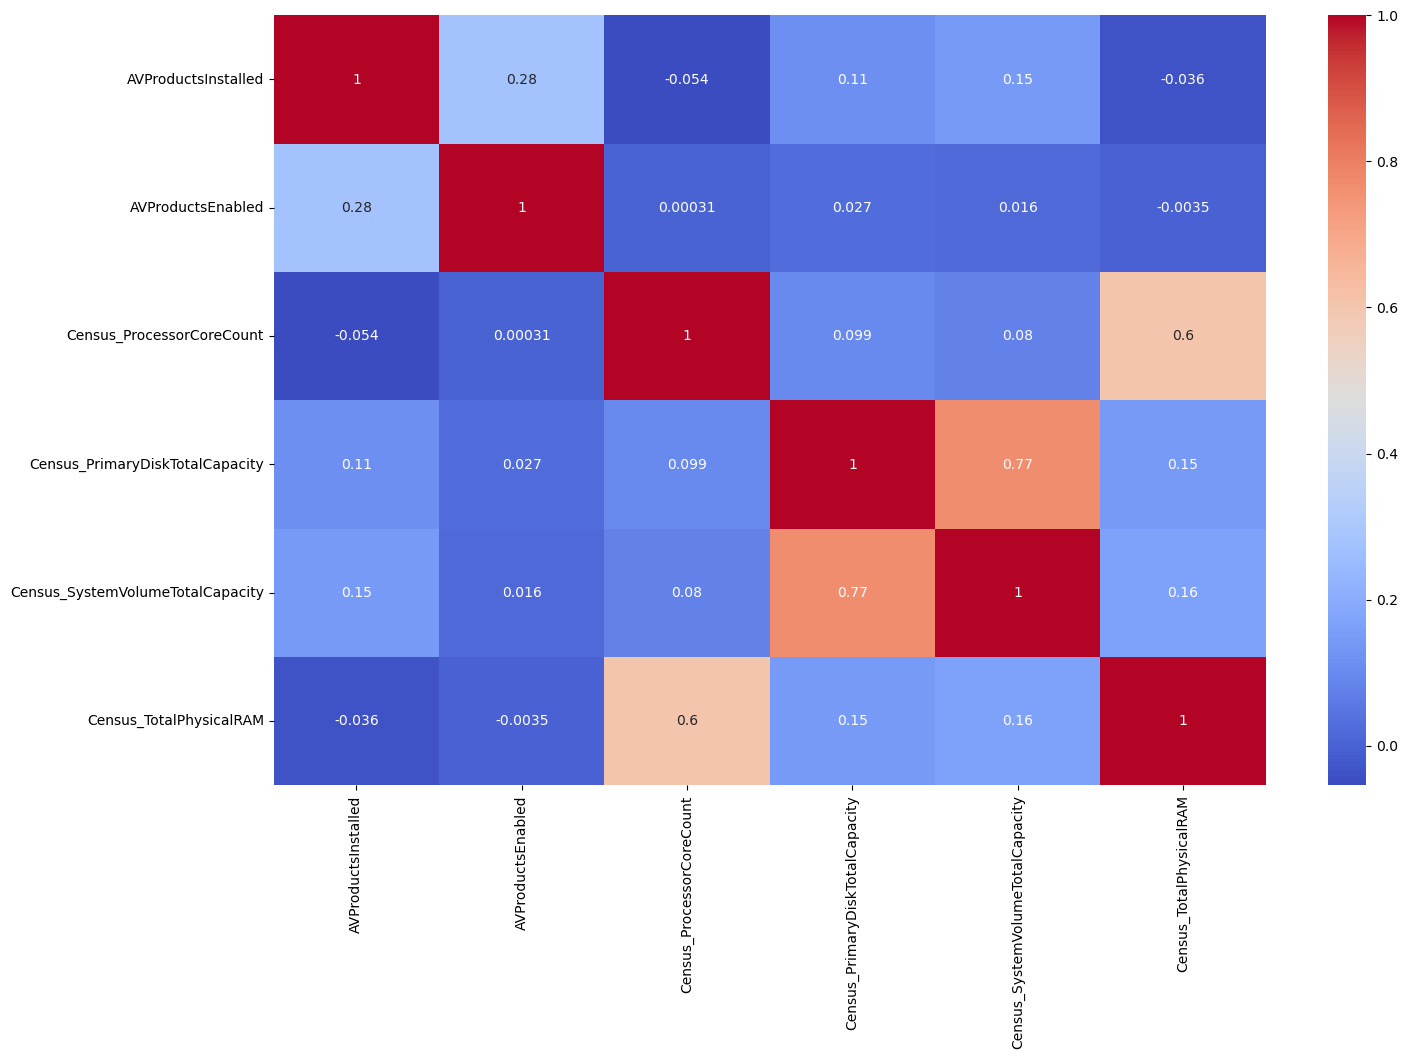

In [19]:
# 4. Correlation Matrix
correlation_matrix = malware_df[numerical_features].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Analysis on Correlation:

`AVProductsInstalled` and `AVProductsEnabled` have a positive correlation of 0.28, which suggests that as the number of antivirus products installed on a system increases, the number of enabled antivirus products tends to increase as well, but it's not a strong relationship.

`Census_ProcessorCoreCount` does not show a strong correlation with any other features, indicating the number of processor cores is relatively independent of these system characteristics.

`Census_PrimaryDiskTotalCapacity` and `Census_SystemVolumeTotalCapacity` show a very high positive correlation of 0.77, which is expected as the system volume is often a part of the primary disk. This suggests redundancy in information provided by these two features.

`Census_PrimaryDiskTotalCapacity` and `Census_TotalPhysicalRAM` have a mild positive correlation of 0.15, which could indicate that systems with larger primary disk capacities also tend to have more RAM, although this relationship is not particularly strong.

`Census_SystemVolumeTotalCapacity` and `Census_TotalPhysicalRAM` also have a positive correlation of 0.16, suggesting a similar trend where systems with more storage also tend to have slightly more RAM.

In [20]:
# Try to find other highly connected features
# Adjusting the threshold to identify a broader set of correlated features
lower_threshold = 0.5

# Extract the upper triangle of the correlation matrix for numerical features
upper_tri_num_lower = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Find features with correlations above the lower threshold
potential_groups = [(var1, var2, upper_tri_num_lower.loc[var1, var2])
                    for var1 in upper_tri_num_lower.columns
                    for var2 in upper_tri_num_lower.index
                    if abs(upper_tri_num_lower.loc[var1, var2]) > lower_threshold]

# Since the analysis might reveal multiple correlated groups, let's focus on identifying a few key groups
potential_groups.sort(key=lambda x: abs(x[2]), reverse=True)

# Display potential groups of correlated features
potential_groups

[('Census_PrimaryDiskTotalCapacity',
  'Census_SystemVolumeTotalCapacity',
  0.7666210338807008),
 ('Census_ProcessorCoreCount', 'Census_TotalPhysicalRAM', 0.6032430848026386)]

As we can see that 'Census_PrimaryDiskTotalCapacity' and 'Census_SystemVolumeTotalCapacity','Census_ProcessorCoreCount' and 'Census_TotalPhysicalRAM' are two other highly correlated features pairs.

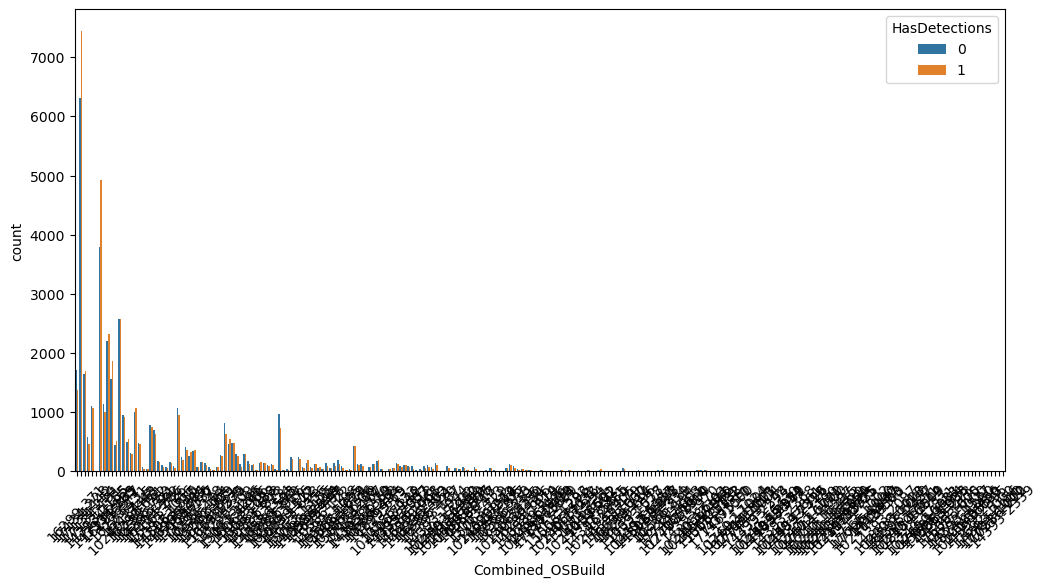

In [21]:
# 5. Grouped Analysis for Highly Connected Features
# Example of grouping correlated features (Census_OSBuildNumber and Census_OSBuildRevision)
grouped_features = ['Census_OSBuildNumber', 'Census_OSBuildRevision']
malware_df['Combined_OSBuild'] = malware_df[grouped_features].astype(str).agg('-'.join, axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(x='Combined_OSBuild', hue=target_variable, data=malware_df)
plt.xticks(rotation=45)
plt.show()

Insights on this Grouped Analysis

The most common OS build version has a significantly higher count of observations where no detections were found (blue bars) compared to those where detections were found (orange bars). This suggests that this particular OS build version might be more secure or less targeted by malware.

There are several peaks visible for both categories (0 and 1), indicating that some specific OS build versions have more instances in the dataset than others. This could be due to the popularity of certain builds or the time period when data was collected.

For nearly all the OS build versions, the number of observations with no detections is equal to or greater than the number with detections. This could imply a generally effective defense against malware across the OS builds or a dataset with a larger proportion of non-infected instances.

The distribution of the OS build versions is very sparse after the first few builds, showing that data for certain builds is much less frequent.

Since the labels on the x-axis are not readable due to the large number of categories, it's difficult to identify which specific OS build versions correspond to the peaks without additional information.

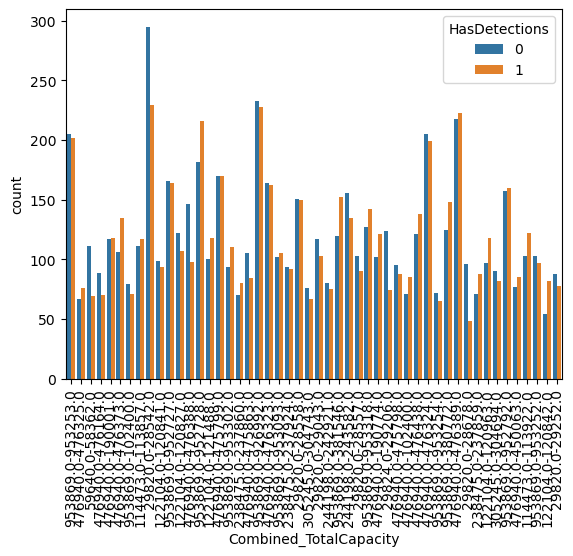

In [22]:
# group correlated features (Census_PrimaryDiskTotalCapacity and Census_SystemVolumeTotalCapacity)
grouped_features = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity']
malware_df['Combined_TotalCapacity'] = malware_df[grouped_features].astype(str).agg('-'.join, axis=1)
# as the whole correlated features will overlap on x axis, so here just take the top 50 categories
top_categories = malware_df['Combined_TotalCapacity'].value_counts().nlargest(50).index
filtered_df = malware_df[malware_df['Combined_TotalCapacity'].isin(top_categories)]

sns.countplot(x='Combined_TotalCapacity', hue=target_variable, data=filtered_df)
plt.xticks(rotation=90)
plt.show()



Insights on this Grouped Analysis

Data Distribution Across Categories: There is a wide distribution of the combined total capacities. It seems that there are many unique combinations resulting in a crowded x-axis.

Category Balance: Both categories (0 and 1) are present across different combined total capacities. However, without clear labels, it is challenging to determine what specific capacities correspond to higher counts.

Trend Observation: There does not appear to be a distinct trend or pattern indicating that one category consistently has a higher count over the other across the various combined total capacities.

Predominance of Certain Values: Certain combined total capacity values have significantly higher counts for both categories, which could indicate common configurations or popular choices of capacity combinations in the dataset.

Label Overlapping: The x-axis labels are overlapping, making it difficult to read individual combined total capacity values. A potential improvement could be to rotate the labels, increase the figure size, or use a subset of the data with top N combined total capacities for clearer visualization.

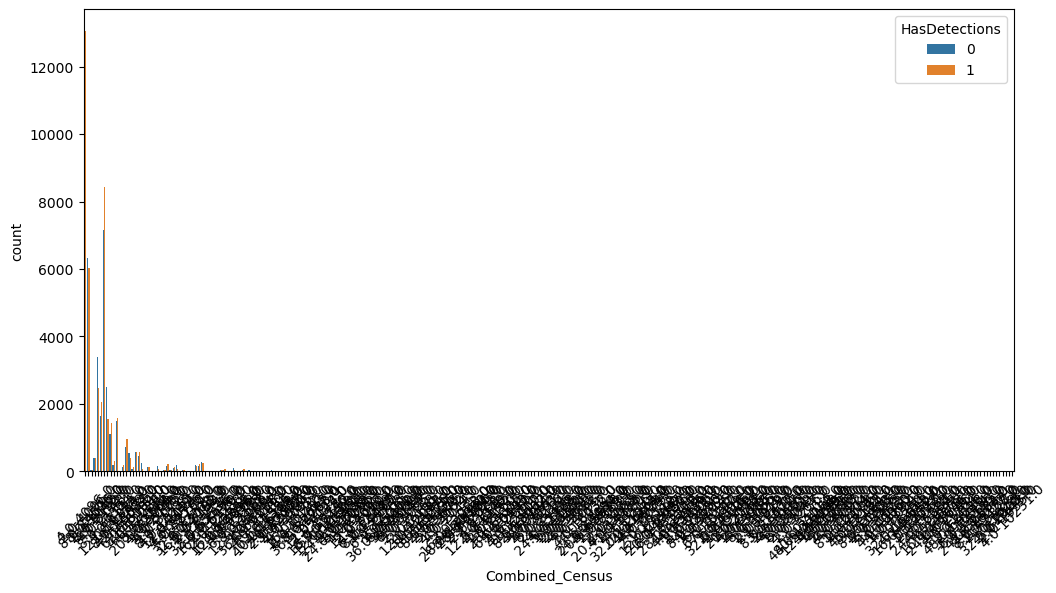

In [23]:
# group correlated features (Census_ProcessorCoreCount and Census_TotalPhysicalRAM)
grouped_features = ['Census_ProcessorCoreCount', 'Census_TotalPhysicalRAM']
malware_df['Combined_Census'] = malware_df[grouped_features].astype(str).agg('-'.join, axis=1)

plt.figure(figsize=(12, 6))
sns.countplot(x='Combined_Census', hue=target_variable, data=malware_df)
plt.xticks(rotation=45)
plt.show()

Insights on this Grouped Analysis

Distribution of Counts: There is a significant number of counts in the lower range of the combined census data, with a sharp decrease as the values increase. This suggests that the lower range values are more common in the dataset.

Presence of Both Categories: Both categories "0" and "1" appear across the range of combined census data. This indicates that the feature being analyzed occurs in both classes of the target variable.

Initial Peaks: There are initial peaks observed in the count for both categories, which then drop off rapidly and spread out for the rest of the values.

Label Readability: The x-axis labels are unreadable due to overlap and density. This makes it difficult to identify which specific combined census values correspond to the counts displayed.

Data Granularity and Variety: The granularity of the combined census values is very high, resulting in a dense clustering of bars that is challenging to interpret visually.

Target Variable - HasDetections: While we can see the distribution of counts for both "0" and "1" across the combined census values, without clearer labels or less granularity, it's challenging to ascertain any specific trends or patterns that might inform us about the relationship between these features and the likelihood of having detections.